In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
feature_names_file = ['thickness', 'myelination', 'curvature', 'sulcus_depth']
brightness = 0.85
thickness_color = [brightness,0.0,0.0]
myelination_color = [0.0,brightness,0.0]
curvature_color = [0.0,0.0,brightness]
sulcus_depth_color = [brightness,0.0,brightness]
j_color = [brightness,brightness,0.0]
fc_color = [0.0,brightness,brightness]
all_color = [0.0, 0.0, 0.0]
crit_color = 'gray'
feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]

In [6]:
plt.rcParams.update({'font.size': 20})
line_width = 3

In [7]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [8]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [9]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [10]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [11]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_and_1 = torch.stack(  ( feature, torch.ones_like(feature) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_and_1, param_col)
    param_pred = torch.matmul(feature_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}, corr.={corr:.3g}')
    
    feature_np = depytorch(feature)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_np, param_np, color='blue')
    ax.plot(feature_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel(f'{param_name}')

In [12]:
def get_correlation_and_p(feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str, num_perms:int=1000000):
    # We assume both Tensors are 1D and the same size.
    
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    num_greater = 0
    num_values = feature.numel()
    corr_abs = corr.abs()
    for _ in range(num_perms):
        perm = torch.randperm( n=num_values, dtype=int_type, device=feature.device )
        perm_corr_abs = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature[perm], dim=0).abs()
        num_greater += (perm_corr_abs >= corr_abs)
    p_value = num_greater/num_perms
    
    print(f'{param_name} v. {feature_name} corr.={corr:.3g}, p-value={p_value:.3g}')
    return corr, p_value

In [13]:
def count_non_nan(m:torch.Tensor):
    return (   torch.count_nonzero(  torch.logical_not( torch.isnan(m) )  )/m.numel()   ).item()

In [14]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
threshold_np = depytorch(threshold)

In [15]:
print( get_closest_match(values=threshold, target=1.0) )

tensor(10, device='cuda:0')


In [16]:
lstsq_corr_group_all_h = torch.load( os.path.join(file_dir, 'lstsq_corr_group_all_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False ).squeeze(dim=-1)
print( lstsq_corr_group_all_h.size() )

torch.Size([31])


In [17]:
lstsq_corr_group_all_mean_state = torch.load( os.path.join(file_dir, 'lstsq_corr_group_all_mean_state_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False ).squeeze(dim=-1)
print( lstsq_corr_group_all_mean_state.size() )

torch.Size([31])


In [18]:
crit_lstsq_corr_group_all_h = torch.load( os.path.join(file_dir, 'crit_val_lstsq_group_all_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_1000000_v2.pt'), weights_only=False ).squeeze(dim=0).squeeze(dim=-1)
print( crit_lstsq_corr_group_all_h.size() )

torch.Size([31])


In [19]:
crit_lstsq_corr_group_all_mean_state = torch.load( os.path.join(file_dir, 'crit_val_lstsq_group_all_mean_state_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_1000000_v3.pt'), weights_only=False ).squeeze(dim=0).squeeze(dim=-1)
print( crit_lstsq_corr_group_all_mean_state.size() )

torch.Size([31])


In [20]:
crit_diff = crit_lstsq_corr_group_all_mean_state - crit_lstsq_corr_group_all_h
# print( crit_diff.tolist() )
for target_threshold in [0.0, 1.0, 1.5]:
    threshold_index = get_closest_match(values=threshold, target=target_threshold)
    selected_threshold = threshold[threshold_index]
    print(f'At threshold {selected_threshold:.3g}, difference between critical values is {crit_diff[threshold_index]:.3g}.')

At threshold 0, difference between critical values is -0.00112.
At threshold 1, difference between critical values is 0.00122.
At threshold 1.5, difference between critical values is 0.0556.


In [21]:
crit_lstsq_corr_group_all_max = torch.maximum(crit_lstsq_corr_group_all_h, crit_lstsq_corr_group_all_mean_state)

Text(0, 0.5, 'group prediction corr.')

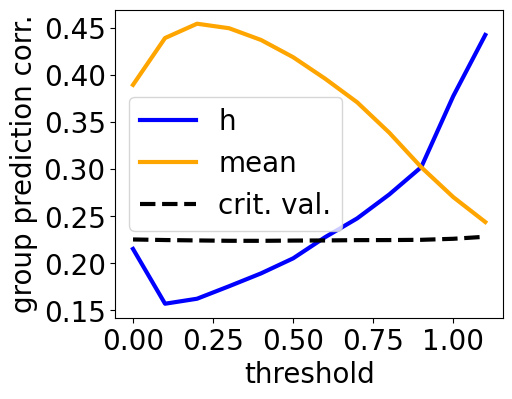

In [22]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
max_threshold = 1.2
max_threshold_index = get_closest_match(values=threshold, target=max_threshold)
axs.plot( threshold_np[:max_threshold_index], depytorch(lstsq_corr_group_all_h[:max_threshold_index]), color='blue', linewidth=line_width, linestyle='solid', label='h' )
# axs.plot( threshold_np[:max_threshold_index], depytorch(crit_lstsq_corr_group_all_h[:max_threshold_index]), color='blue', linewidth=line_width, linestyle='dashed', label='h critical value' )
axs.plot( threshold_np[:max_threshold_index], depytorch(lstsq_corr_group_all_mean_state[:max_threshold_index]), color='orange', linewidth=line_width, linestyle='solid', label='mean' )
# axs.plot( threshold_np[:max_threshold_index], depytorch(crit_lstsq_corr_group_all_mean_state[:max_threshold_index]), color='orange', linewidth=line_width, linestyle='dashed', label='mean state critical value' )
axs.plot( threshold_np[:max_threshold_index], depytorch(crit_lstsq_corr_group_all_max[:max_threshold_index]), color='black', linewidth=line_width, linestyle='dashed', label='crit. val.' )
axs.set_xticks( np.arange(0, max_threshold, 0.25) )
axs.set_yticks( np.arange(0.15, 0.5, 0.05) )
# axs.set_yticks(  np.arange( min( lstsq_corr_group_all_h[:max_threshold_index].min().item(), lstsq_corr_group_all_mean_state[:max_threshold_index].min().item() ), max( lstsq_corr_group_all_h[:max_threshold_index].max().item(), lstsq_corr_group_all_mean_state[:max_threshold_index].max().item() ), 0.05 )  )
axs.legend()
axs.set_xlabel('threshold')
axs.set_ylabel('group prediction corr.')

In [23]:
best_mean_state_index = lstsq_corr_group_all_mean_state.abs().argmax()
print(f'best mean(features) v. mean correlation is {lstsq_corr_group_all_mean_state[best_mean_state_index]:.3g} at threshold {threshold[best_mean_state_index]:.3g}.')

best mean(features) v. mean correlation is 0.557 at threshold 2.9.


In [24]:
next_best_mean_state_index = lstsq_corr_group_all_mean_state[:max_threshold_index].abs().argmax()
print(f'best mean(features) v. mean correlation for threshold less than {threshold[max_threshold_index]:.3g} is {lstsq_corr_group_all_mean_state[next_best_mean_state_index]:.3g} at threshold {threshold[next_best_mean_state_index]:.3g}.')

best mean(features) v. mean correlation for threshold less than 1.2 is 0.455 at threshold 0.2.


In [25]:
corr_group_each_h = torch.load( os.path.join(file_dir, 'corr_group_each_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( corr_group_each_h.size() )

torch.Size([31, 4])


In [26]:
corr_group_each_mean_state = torch.load( os.path.join(file_dir, 'corr_group_each_mean_state_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( corr_group_each_mean_state.size() )

torch.Size([31, 4])


Text(0, 0.5, 'correlation')

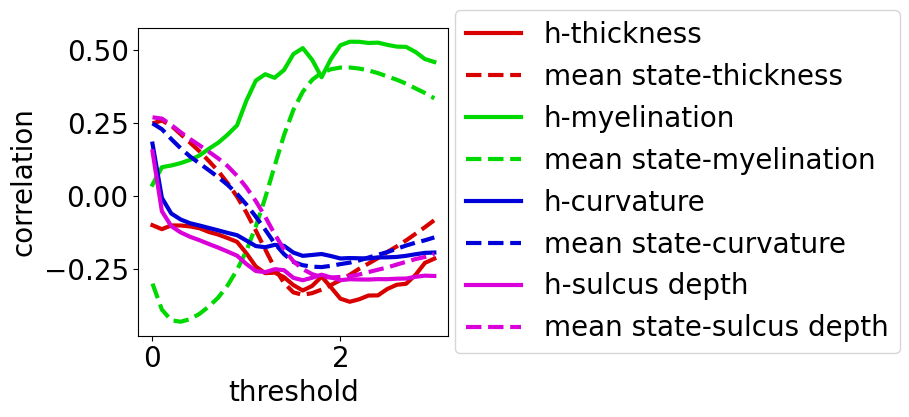

In [27]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 4) )
num_features = len(feature_names)
for feature_index in range(num_features):
    feature_color = feature_colors[feature_index]
    feature_name = feature_names[feature_index]
    axs.plot( threshold_np, depytorch(corr_group_each_h[:,feature_index]), color=feature_color, linewidth=line_width, label=f'h-{feature_name}', linestyle='solid' )
    axs.plot( threshold_np, depytorch(corr_group_each_mean_state[:,feature_index]), color=feature_color, linewidth=line_width, label=f'mean state-{feature_name}', linestyle='dashed' )
axs.legend( loc='center right', bbox_to_anchor=(2.50, 0.5) )
axs.set_xlabel('threshold')
axs.set_ylabel('correlation')

In [28]:
p_value_lstsq_group_all_h = torch.load( os.path.join(file_dir, 'p_value_lstsq_group_all_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_1000000.pt'), weights_only=False )
print( p_value_lstsq_group_all_h.size() )

torch.Size([31, 1])


In [29]:
crit_val_lstsq_group_all_h = torch.load( os.path.join(file_dir, 'crit_val_lstsq_group_all_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_1000000.pt'), weights_only=False ).squeeze(dim=0).squeeze(dim=-1)
print( crit_val_lstsq_group_all_h.size() )

torch.Size([31])


In [30]:
p_value_group_each_h = torch.load( os.path.join(file_dir, 'p_value_group_each_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_1000000.pt'), weights_only=False )
print( p_value_group_each_h.size() )

torch.Size([31, 4])


In [31]:
crit_val_group_each_h = torch.load( os.path.join(file_dir, 'crit_val_group_each_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_1000000.pt'), weights_only=False ).squeeze(dim=0)
print( crit_val_group_each_h.size() )

torch.Size([31, 4])


In [32]:
h_node_corr_critical = torch.cat(  ( crit_val_group_each_h, crit_val_lstsq_group_all_h.unsqueeze(dim=-1) ), dim=-1  )
print(h_node_corr_critical)

tensor([[0.1725, 0.1723, 0.1717, 0.1730, 0.2240],
        [0.1714, 0.1721, 0.1715, 0.1716, 0.2240],
        [0.1723, 0.1728, 0.1717, 0.1722, 0.2241],
        [0.1725, 0.1725, 0.1722, 0.1726, 0.2241],
        [0.1729, 0.1722, 0.1725, 0.1723, 0.2244],
        [0.1728, 0.1720, 0.1724, 0.1721, 0.2247],
        [0.1730, 0.1725, 0.1724, 0.1721, 0.2248],
        [0.1729, 0.1722, 0.1724, 0.1719, 0.2247],
        [0.1727, 0.1725, 0.1722, 0.1720, 0.2249],
        [0.1727, 0.1725, 0.1723, 0.1722, 0.2250],
        [0.1726, 0.1727, 0.1720, 0.1723, 0.2253],
        [0.1725, 0.1723, 0.1723, 0.1723, 0.2249],
        [0.1724, 0.1726, 0.1724, 0.1721, 0.2250],
        [0.1727, 0.1726, 0.1723, 0.1724, 0.2249],
        [0.1727, 0.1726, 0.1724, 0.1725, 0.2246],
        [0.1728, 0.1723, 0.1718, 0.1719, 0.2240],
        [0.1724, 0.1723, 0.1717, 0.1724, 0.2239],
        [0.1727, 0.1723, 0.1721, 0.1720, 0.2243],
        [0.1726, 0.1721, 0.1714, 0.1720, 0.2246],
        [0.1724, 0.1725, 0.1718, 0.1718, 0.2244],


In [33]:
horizontal_crit = crit_val_group_each_h.squeeze(dim=0).max(dim=-1).values
print( horizontal_crit.size(), f'{horizontal_crit.max()-horizontal_crit.min():.3g}' )

torch.Size([31]) 0.000964


In [34]:
print( crit_val_group_each_h.size(), crit_val_group_each_h.min(), crit_val_group_each_h.max() )

torch.Size([31, 4]) tensor(0.1713, device='cuda:0') tensor(0.1730, device='cuda:0')


In [35]:
print( torch.nonzero(lstsq_corr_group_all_h > horizontal_crit).flatten().tolist() )
print( lstsq_corr_group_all_h.flatten().tolist() )
print( horizontal_crit.flatten().tolist() )

[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.2152089923620224, 0.15693572163581848, 0.16225099563598633, 0.17553727328777313, 0.1892477422952652, 0.20520421862602234, 0.2277330458164215, 0.24771228432655334, 0.2731145918369293, 0.3022071421146393, 0.3777683675289154, 0.44282227754592896, 0.46369513869285583, 0.4508278965950012, 0.47342434525489807, 0.5275163054466248, 0.5478624105453491, 0.5120062828063965, 0.45920976996421814, 0.5142329931259155, 0.5593678951263428, 0.5692576766014099, 0.5672909617424011, 0.5609233975410461, 0.5622028112411499, 0.5527939796447754, 0.5459389686584473, 0.5444032549858093, 0.5250537395477295, 0.5050858855247498, 0.4907706677913666]
[0.17295734584331512, 0.17211996018886566, 0.17276158928871155, 0.17258118093013763, 0.1728842407464981, 0.17283135652542114, 0.17297665774822235, 0.1729319989681244, 0.17269110679626465, 0.17268827557563782, 0.17267173528671265, 0.17251944541931152, 0.17264394

In [36]:
max_thresh_index = 17
print( lstsq_corr_group_all_mean_state[:max_thresh_index].max(), lstsq_corr_group_all_h[:max_thresh_index].max() )

tensor(0.4548, device='cuda:0') tensor(0.5479, device='cuda:0')


feature order tensor([1, 2, 3, 0], device='cuda:0')


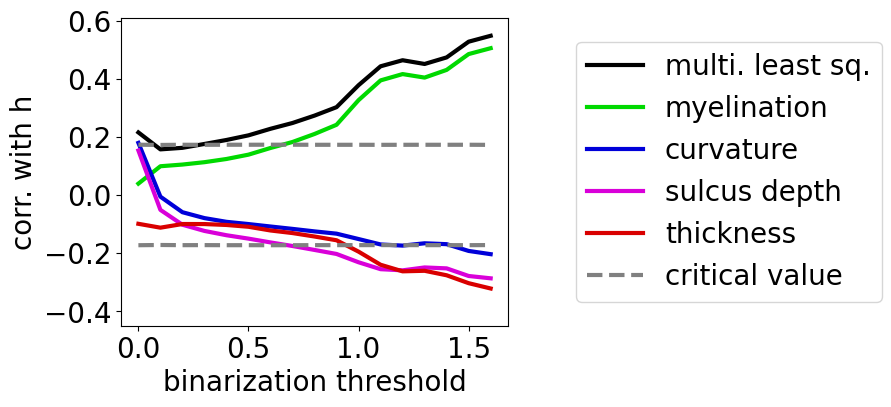

In [37]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(corr_group_each_h[:max_thresh_index,:])
h_pred_corr_np = depytorch(lstsq_corr_group_all_h[:max_thresh_index])
horizontal_crit_np = depytorch(horizontal_crit[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
line_width = 3

axs.plot(threshold_np, h_pred_corr_np, label=f'multi. least sq.', color=all_color, linewidth=line_width)

last_h_node_corr_sorted, feature_indices_sorted = torch.sort(corr_group_each_h[max_thresh_index-1,:], descending=True)
print('feature order', feature_indices_sorted)
feature_names_sorted = [feature_names[i] for i in feature_indices_sorted]
feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_colors_sorted = [feature_colors[i] for i in feature_indices_sorted]
for feature_index, feature_name, feature_color in zip(feature_indices_sorted,feature_names_sorted,feature_colors_sorted):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'{feature_name}', color=feature_color, linewidth=line_width)

axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)

# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.0, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_ylim([-0.45, 0.61])
axs.set_yticks( np.arange(-0.4, 0.7, 0.2) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. with h')
plt.show()

feature order tensor([1, 2, 3, 0], device='cuda:0')


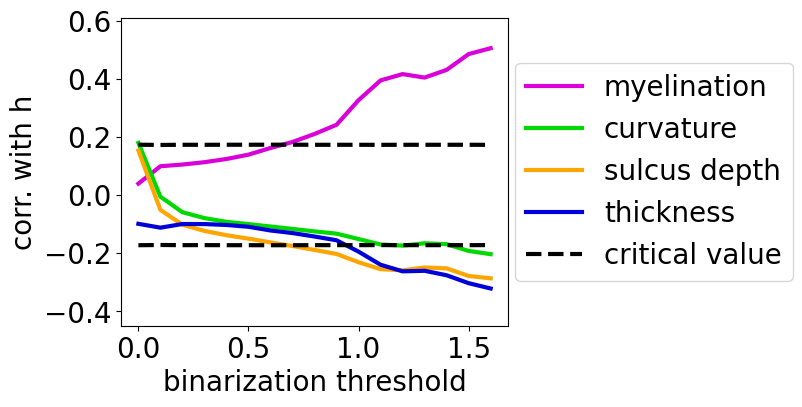

In [45]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(corr_group_each_h[:max_thresh_index,:])
h_pred_corr_np = depytorch(lstsq_corr_group_all_h[:max_thresh_index])
horizontal_crit_np = depytorch(horizontal_crit[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
line_width = 3

# axs.plot(threshold_np, h_pred_corr_np, label=f'multi. least sq.', color=all_color, linewidth=line_width)

last_h_node_corr_sorted, feature_indices_sorted = torch.sort(corr_group_each_h[max_thresh_index-1,:], descending=True)
print('feature order', feature_indices_sorted)
feature_names_sorted = [feature_names[i] for i in feature_indices_sorted]
# just noticed these do not match the cortex maps.
# It is easier to redo this plot than remake them.
feature_colors = [curvature_color,sulcus_depth_color,myelination_color,'orange']
feature_colors_sorted = [feature_colors[i] for i in feature_indices_sorted]
for feature_index, feature_name, feature_color in zip(feature_indices_sorted,feature_names_sorted,feature_colors_sorted):
    axs.plot(threshold_np, h_node_corr_np[:,feature_index], label=f'{feature_name}', color=feature_color, linewidth=line_width)

axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color='black', linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color='black', linewidth=line_width)

# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(1.77, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_ylim([-0.45, 0.61])
axs.set_yticks( np.arange(-0.4, 0.7, 0.2) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. with h')
plt.show()

feature order tensor([1, 2, 3, 0], device='cuda:0')


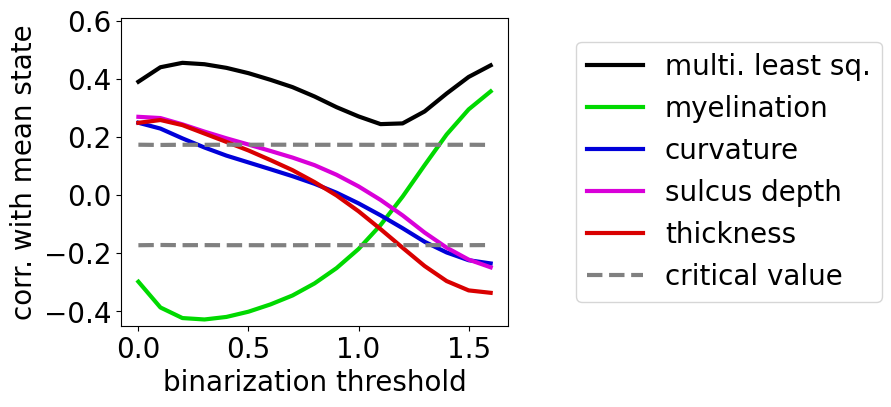

In [38]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
mean_state_node_corr_np = depytorch(corr_group_each_mean_state[:max_thresh_index,:])
mean_state_pred_corr_np = depytorch(lstsq_corr_group_all_mean_state[:max_thresh_index])
horizontal_crit_np = depytorch(horizontal_crit[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
line_width = 3

axs.plot(threshold_np, mean_state_pred_corr_np, label=f'multi. least sq.', color=all_color, linewidth=line_width)

last_mean_state_node_corr_sorted, feature_indices_sorted = torch.sort(corr_group_each_mean_state[max_thresh_index-1,:], descending=True)
print('feature order', feature_indices_sorted)
feature_names_sorted = [feature_names[i] for i in feature_indices_sorted]
feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_colors_sorted = [feature_colors[i] for i in feature_indices_sorted]
for feature_index, feature_name, feature_color in zip(feature_indices_sorted,feature_names_sorted,feature_colors_sorted):
    axs.plot(threshold_np, mean_state_node_corr_np[:,feature_index], label=f'{feature_name}', color=feature_color, linewidth=line_width)

axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)

# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.0, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_ylim([-0.45, 0.61])
axs.set_yticks( np.arange(-0.4, 0.7, 0.2) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. with mean state')
plt.show()

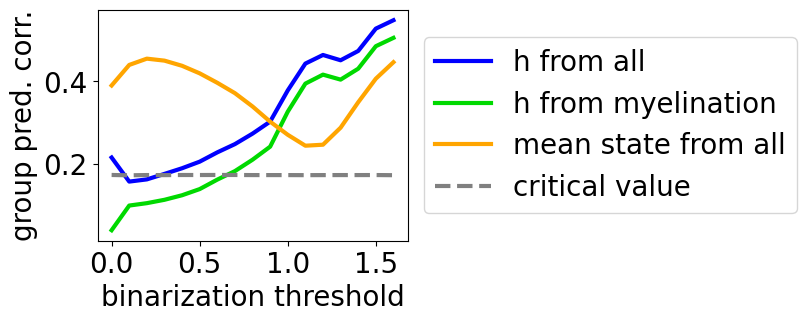

In [43]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(corr_group_each_h[:max_thresh_index,:])
h_pred_corr_np = depytorch(lstsq_corr_group_all_h[:max_thresh_index])
horizontal_crit_np = depytorch(horizontal_crit[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
line_width = 3

axs.plot(threshold_np, h_pred_corr_np, label=f'h from all', color='blue', linewidth=line_width)

feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_index = 1
axs.plot( threshold_np, np.abs(h_node_corr_np[:,feature_index]), label=f'h from {feature_names[feature_index]}', color=feature_colors[feature_index], linewidth=line_width )

axs.plot( threshold_np, depytorch(lstsq_corr_group_all_mean_state[:max_thresh_index]), color='orange', linewidth=line_width, linestyle='solid', label='mean state from all' )

axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
# axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)

# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.3, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('group pred. corr.')
plt.show()

In [87]:
h_all_group_corr_train = torch.load( os.path.join(file_dir, 'lstsq_corrs_train_from_all_to_h_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000.pt'), weights_only=False )
print( h_all_group_corr_train.size() )
h_all_group_corr_train_min, _ = h_all_group_corr_train.min(dim=-1)
print( h_all_group_corr_train_min.tolist() )
h_all_group_corr_train_median, _ = h_all_group_corr_train.median(dim=-1)
print( h_all_group_corr_train_median.tolist() )
h_all_group_corr_train_max, _ = h_all_group_corr_train.max(dim=-1)
print( h_all_group_corr_train_max.tolist() )

torch.Size([31, 10000])
[0.11717169731855392, 0.05597624555230141, 0.07274545729160309, 0.08766648918390274, 0.09488750994205475, 0.11058753728866577, 0.13499322533607483, 0.15561865270137787, 0.1802627593278885, 0.2120688408613205, 0.2964686453342438, 0.36960941553115845, 0.3892380893230438, 0.37480464577674866, 0.39607957005500793, 0.45629289746284485, 0.48242396116256714, 0.435960054397583, 0.37842461466789246, 0.4368743896484375, 0.4934644103050232, 0.5070300698280334, 0.5031541585922241, 0.4950017035007477, 0.4939696788787842, 0.48210829496383667, 0.4732588231563568, 0.4703693985939026, 0.44843795895576477, 0.42183706164360046, 0.41612833738327026]
[0.21946904063224792, 0.1631181538105011, 0.16826222836971283, 0.18107664585113525, 0.19456066191196442, 0.21025046706199646, 0.23212167620658875, 0.2516927123069763, 0.27680182456970215, 0.30568763613700867, 0.3805542588233948, 0.44513919949531555, 0.4658069610595703, 0.45323073863983154, 0.4756186902523041, 0.5291658043861389, 0.54939

In [88]:
h_all_group_corr_test = torch.load( os.path.join(file_dir, 'lstsq_corr_test_from_all_to_h_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000.pt'), weights_only=False )
print( h_all_group_corr_test.size() )
h_all_group_corr_test_min, _ = h_all_group_corr_test.min(dim=-1)
print( h_all_group_corr_test_min.tolist() )
h_all_group_corr_test_median, _ = h_all_group_corr_test.median(dim=-1)
print( h_all_group_corr_test_median.tolist() )
h_all_group_corr_test_max, _ = h_all_group_corr_test.max(dim=-1)
print( h_all_group_corr_test_max.tolist() )

torch.Size([31, 10000])
[-0.22732415795326233, -0.3421092927455902, -0.3204689919948578, -0.315421462059021, -0.32534050941467285, -0.3257288634777069, -0.31165918707847595, -0.2948859632015228, -0.2650142014026642, -0.21814966201782227, -0.09718932211399078, 0.03841501846909523, 0.09809274226427078, 0.07638069987297058, 0.1138383001089096, 0.18396785855293274, 0.20574338734149933, 0.1621169149875641, 0.06365028023719788, 0.1349586844444275, 0.2143487185239792, 0.2244090437889099, 0.22254276275634766, 0.21181587874889374, 0.2140912115573883, 0.21119143068790436, 0.19971269369125366, 0.20347999036312103, 0.1908789724111557, 0.1649535894393921, 0.17147250473499298]
[0.17123109102249146, 0.0950656309723854, 0.0970647782087326, 0.11316874623298645, 0.1308053880929947, 0.1502930074930191, 0.1772603839635849, 0.2009357213973999, 0.22973816096782684, 0.2639133334159851, 0.34794944524765015, 0.4181479811668396, 0.440367192029953, 0.4264037609100342, 0.4508577287197113, 0.5078832507133484, 0.52

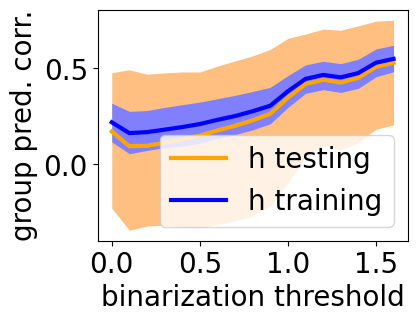

In [95]:
# Order the features in descending order of correlation at max threshold
# so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(corr_group_each_h[:max_thresh_index,:])
h_pred_corr_np = depytorch(lstsq_corr_group_all_h[:max_thresh_index])
horizontal_crit_np = depytorch(horizontal_crit[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
line_width = 3

feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_index = 1
# axs.plot( threshold_np, np.abs(h_node_corr_np[:,feature_index]), label=f'h from {feature_names[feature_index]}', color=feature_colors[feature_index], linewidth=line_width )

axs.fill_between( threshold_np, depytorch(h_all_group_corr_test_min[:max_thresh_index]), depytorch(h_all_group_corr_test_max[:max_thresh_index]), color=[1.0, 0.75, 0.5], linewidth=0 )
axs.plot( threshold_np, depytorch(h_all_group_corr_test_median[:max_thresh_index]), color='orange', linewidth=line_width, linestyle='solid', label='h testing' )

axs.fill_between( threshold_np, depytorch(h_all_group_corr_train_min[:max_thresh_index]), depytorch(h_all_group_corr_train_max[:max_thresh_index]), color=[0.5, 0.5, 1.0], linewidth=0 )
axs.plot( threshold_np, depytorch(h_all_group_corr_train_median[:max_thresh_index]), color='blue', linewidth=line_width, linestyle='solid', label='h training' )

# axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
# axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)

axs.legend()
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='center right', bbox_to_anchor=(2.3, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('group pred. corr.')
plt.show()

In [96]:
h_all_group_corr_train_std, h_all_group_corr_train_mean = torch.std_mean(h_all_group_corr_train, dim=-1)
h_all_group_corr_train_mean_plus_std = h_all_group_corr_train_mean + h_all_group_corr_train_std
h_all_group_corr_train_mean_minus_std = h_all_group_corr_train_mean - h_all_group_corr_train_std
h_all_group_corr_test_std, h_all_group_corr_test_mean = torch.std_mean(h_all_group_corr_test, dim=-1)
h_all_group_corr_test_mean_plus_std = h_all_group_corr_test_mean + h_all_group_corr_test_std
h_all_group_corr_test_mean_minus_std = h_all_group_corr_test_mean - h_all_group_corr_test_std

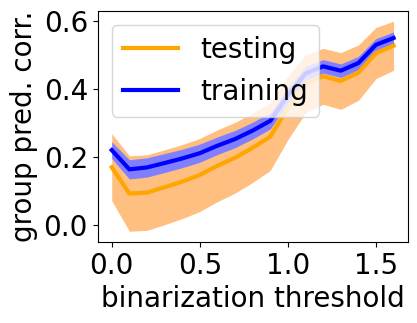

In [103]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
h_node_corr_np = depytorch(corr_group_each_h[:max_thresh_index,:])
h_pred_corr_np = depytorch(lstsq_corr_group_all_h[:max_thresh_index])
horizontal_crit_np = depytorch(horizontal_crit[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
line_width = 3

feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_index = 1
# axs.plot( threshold_np, np.abs(h_node_corr_np[:,feature_index]), label=f'h from {feature_names[feature_index]}', color=feature_colors[feature_index], linewidth=line_width )

axs.fill_between( threshold_np, depytorch(h_all_group_corr_test_mean_minus_std[:max_thresh_index]), depytorch(h_all_group_corr_test_mean_plus_std[:max_thresh_index]), color=[1.0, 0.75, 0.5], linewidth=0 )
axs.plot( threshold_np, depytorch(h_all_group_corr_test_mean[:max_thresh_index]), color='orange', linewidth=line_width, linestyle='solid', label='testing' )

axs.fill_between( threshold_np, depytorch(h_all_group_corr_train_mean_minus_std[:max_thresh_index]), depytorch(h_all_group_corr_train_mean_plus_std[:max_thresh_index]), color=[0.5, 0.5, 1.0], linewidth=0 )
axs.plot( threshold_np, depytorch(h_all_group_corr_train_mean[:max_thresh_index]), color='blue', linewidth=line_width, linestyle='solid', label='training' )

# axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
# axs.plot(threshold_np, -1*horizontal_crit_np, linestyle='--', color=crit_color, linewidth=line_width)

axs.legend()
# axs.legend( loc='best', bbox_to_anchor=(1.0, 0.5, 1.0, 1.0) )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='center right', bbox_to_anchor=(2.3, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('group pred. corr.')
plt.show()

In [136]:
h_all_group_corr_train = torch.load( os.path.join(file_dir, 'lstsq_corrs_train_from_all_to_h_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( h_all_group_corr_train.size() )
h_all_group_corr_test = torch.load( os.path.join(file_dir, 'lstsq_corr_test_from_all_to_h_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( h_all_group_corr_test.size() )

torch.Size([31, 10000])
torch.Size([31, 10000])


In [145]:
h_all_group_corr_train_std, h_all_group_corr_train_mean = torch.std_mean(h_all_group_corr_train, dim=-1)
h_all_group_corr_train_mean_plus_std = h_all_group_corr_train_mean + h_all_group_corr_train_std
h_all_group_corr_train_mean_minus_std = h_all_group_corr_train_mean - h_all_group_corr_train_std
h_all_group_corr_test_std, h_all_group_corr_test_mean = torch.std_mean(h_all_group_corr_test, dim=-1)
h_all_group_corr_test_mean_plus_std = h_all_group_corr_test_mean + h_all_group_corr_test_std
h_all_group_corr_test_mean_minus_std = h_all_group_corr_test_mean - h_all_group_corr_test_std

In [177]:
print( (h_all_group_corr_train - h_all_group_corr_test).max().item(), (h_all_group_corr_train_mean - h_all_group_corr_test_mean).max().item() )

0.5135713815689087 0.11020908504724503


In [137]:
mean_state_all_group_corr_train = torch.load( os.path.join(file_dir, 'lstsq_corrs_train_from_all_to_mean_state_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( mean_state_all_group_corr_train.size() )
mean_state_all_group_corr_test = torch.load( os.path.join(file_dir, 'lstsq_corr_test_from_all_to_mean_state_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( mean_state_all_group_corr_test.size() )

torch.Size([31, 10000])
torch.Size([31, 10000])


In [146]:
mean_state_all_group_corr_train_std, mean_state_all_group_corr_train_mean = torch.std_mean(mean_state_all_group_corr_train, dim=-1)
mean_state_all_group_corr_train_mean_plus_std = mean_state_all_group_corr_train_mean + mean_state_all_group_corr_train_std
mean_state_all_group_corr_train_mean_minus_std = mean_state_all_group_corr_train_mean - mean_state_all_group_corr_train_std
mean_state_all_group_corr_test_std, mean_state_all_group_corr_test_mean = torch.std_mean(mean_state_all_group_corr_test, dim=-1)
mean_state_all_group_corr_test_mean_plus_std = mean_state_all_group_corr_test_mean + mean_state_all_group_corr_test_std
mean_state_all_group_corr_test_mean_minus_std = mean_state_all_group_corr_test_mean - mean_state_all_group_corr_test_std

In [107]:
J_SC_group_corr_train = torch.load( os.path.join(file_dir, 'lstsq_corrs_train_from_SC_to_J_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000.pt'), weights_only=False )
print( J_SC_group_corr_train.size() )
J_SC_group_corr_test = torch.load( os.path.join(file_dir, 'lstsq_corr_test_from_SC_to_J_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000.pt'), weights_only=False )
print( J_SC_group_corr_test.size() )

torch.Size([31, 10000])
torch.Size([31, 10000])


In [138]:
J_SC_group_corr_train = torch.load( os.path.join(file_dir, 'lstsq_corrs_train_from_SC_to_J_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( J_SC_group_corr_train.size() )
J_SC_group_corr_test = torch.load( os.path.join(file_dir, 'lstsq_corr_test_from_SC_to_J_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( J_SC_group_corr_test.size() )

torch.Size([31, 10000])
torch.Size([31, 10000])


In [147]:
J_SC_group_corr_train_std, J_SC_group_corr_train_mean = torch.std_mean(J_SC_group_corr_train, dim=-1)
J_SC_group_corr_train_mean_plus_std = J_SC_group_corr_train_mean + J_SC_group_corr_train_std
J_SC_group_corr_train_mean_minus_std = J_SC_group_corr_train_mean - J_SC_group_corr_train_std
J_SC_group_corr_test_std, J_SC_group_corr_test_mean = torch.std_mean(J_SC_group_corr_test, dim=-1)
J_SC_group_corr_test_mean_plus_std = J_SC_group_corr_test_mean + J_SC_group_corr_test_std
J_SC_group_corr_test_mean_minus_std = J_SC_group_corr_test_mean - J_SC_group_corr_test_std

In [139]:
FC_SC_group_corr_train = torch.load( os.path.join(file_dir, 'lstsq_corrs_train_from_SC_to_FC_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( FC_SC_group_corr_train.size() )
FC_SC_group_corr_test = torch.load( os.path.join(file_dir, 'lstsq_corr_test_from_SC_to_FC_model_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000_even_split_v2.pt'), weights_only=False )
print( FC_SC_group_corr_test.size() )

torch.Size([31, 10000])
torch.Size([31, 10000])


In [148]:
FC_SC_group_corr_train_std, FC_SC_group_corr_train_mean = torch.std_mean(FC_SC_group_corr_train, dim=-1)
FC_SC_group_corr_train_mean_plus_std = FC_SC_group_corr_train_mean + FC_SC_group_corr_train_std
FC_SC_group_corr_train_mean_minus_std = FC_SC_group_corr_train_mean - FC_SC_group_corr_train_std
FC_SC_group_corr_test_std, FC_SC_group_corr_test_mean = torch.std_mean(FC_SC_group_corr_test, dim=-1)
FC_SC_group_corr_test_mean_plus_std = FC_SC_group_corr_test_mean + FC_SC_group_corr_test_std
FC_SC_group_corr_test_mean_minus_std = FC_SC_group_corr_test_mean - FC_SC_group_corr_test_std

In [175]:
h_all_group_corr_mean_diff = h_all_group_corr_train_mean[:max_thresh_index] - h_all_group_corr_test_mean[:max_thresh_index]
print( h_all_group_corr_mean_diff.tolist() )
print( 'min', h_all_group_corr_mean_diff.min().item() )
print( 'max', h_all_group_corr_mean_diff.max().item() )
print( 'value at 0', h_all_group_corr_mean_diff[0].item() )
print( 'value at 1', h_all_group_corr_mean_diff[10].item() )

[0.07657197117805481, 0.10677382349967957, 0.11020908504724503, 0.10589786618947983, 0.10101940482854843, 0.09494425356388092, 0.08692346513271332, 0.08078029751777649, 0.07377535104751587, 0.06682559847831726, 0.052387386560440063, 0.04329770803451538, 0.040877461433410645, 0.04265168309211731, 0.039712995290756226, 0.03248363733291626, 0.02944469451904297]
min 0.02944469451904297
max 0.11020908504724503
value at 0 0.07657197117805481
value at 1 0.052387386560440063


In [162]:
h_all_group_corr_std_diff = h_all_group_corr_train_std - h_all_group_corr_test_std
print( h_all_group_corr_std_diff.tolist() )
print( 'min', h_all_group_corr_std_diff.min().item() )
print( 'max', h_all_group_corr_std_diff.max().item() )
print( 'value at 0', h_all_group_corr_std_diff[0].item() )
print( 'value at 1', h_all_group_corr_std_diff[10].item() )

[-0.004823032766580582, -0.008124154061079025, -0.009707558900117874, -0.009817156940698624, -0.00978318601846695, -0.00943763554096222, -0.008985757827758789, -0.008572902530431747, -0.008136425167322159, -0.0076957568526268005, -0.006175391376018524, -0.005313940346240997, -0.005171623080968857, -0.00548950582742691, -0.0049183666706085205, -0.0036504268646240234, -0.0030645690858364105, -0.003811649978160858, -0.004461001604795456, -0.0034792982041835785, -0.0026746951043605804, -0.0023046843707561493, -0.0021506473422050476, -0.001974020153284073, -0.0020421333611011505, -0.0018057264387607574, -0.0016953200101852417, -0.0017396509647369385, -0.0015567578375339508, -0.0014239437878131866, -0.0014634765684604645]
min -0.009817156940698624
max -0.0014239437878131866
value at 0 -0.004823032766580582
value at 1 -0.006175391376018524


In [152]:
mean_state_all_group_corr_mean_diff = mean_state_all_group_corr_train_mean - mean_state_all_group_corr_test_mean
print( mean_state_all_group_corr_mean_diff.tolist() )
print( 'min', mean_state_all_group_corr_mean_diff.min().item() )
print( 'max', mean_state_all_group_corr_mean_diff.max().item() )
print( 'value at 0', mean_state_all_group_corr_mean_diff[0].item() )
print( 'value at 1', mean_state_all_group_corr_mean_diff[10].item() )

[0.03707769513130188, 0.02989804744720459, 0.02842468023300171, 0.02982950210571289, 0.03190508484840393, 0.034806251525878906, 0.03824135661125183, 0.042259663343429565, 0.04783201217651367, 0.05511048436164856, 0.06353871524333954, 0.07117022573947906, 0.07257063686847687, 0.06387199461460114, 0.052916109561920166, 0.04410207271575928, 0.037536174058914185, 0.03294968605041504, 0.029910117387771606, 0.027910053730010986, 0.026648879051208496, 0.026276320219039917, 0.025810986757278442, 0.025928229093551636, 0.02669641375541687, 0.027202337980270386, 0.029379725456237793, 0.029961496591567993, 0.03223717212677002, 0.03460758924484253, 0.03621727228164673]
min 0.025810986757278442
max 0.07257063686847687
value at 0 0.03707769513130188
value at 1 0.06353871524333954


In [153]:
J_SC_group_corr_mean_diff = J_SC_group_corr_train_mean - J_SC_group_corr_test_mean
print( J_SC_group_corr_mean_diff.tolist() )
print( 'min', J_SC_group_corr_mean_diff.min().item() )
print( 'max', J_SC_group_corr_mean_diff.max().item() )
print( 'value at 0', J_SC_group_corr_mean_diff[0].item() )
print( 'value at 1', J_SC_group_corr_mean_diff[10].item() )

[-0.00031000375747680664, -0.00031125545501708984, -0.00030994415283203125, -0.000307619571685791, -0.00030481815338134766, -0.00030356645584106445, -0.0003001093864440918, -0.0002980232238769531, -0.00029772520065307617, -0.00029337406158447266, -0.0002893209457397461, -0.0002771914005279541, -0.0002646446228027344, -0.0002586543560028076, -0.00025203824043273926, -0.0002498626708984375, -0.00024083256721496582, -0.00023871660232543945, -0.00023832917213439941, -0.00023940205574035645, -0.00024336576461791992, -0.00024402141571044922, -0.00024515390396118164, -0.0002467334270477295, -0.00024577975273132324, -0.0002465248107910156, -0.0002472400665283203, -0.0002472102642059326, -0.00025218725204467773, -0.0002544224262237549, -0.0002524852752685547]
min -0.00031125545501708984
max -0.00023832917213439941
value at 0 -0.00031000375747680664
value at 1 -0.0002893209457397461


In [159]:
J_SC_group_corr_std_diff = J_SC_group_corr_train_std - J_SC_group_corr_test_std
print( J_SC_group_corr_std_diff.tolist() )
print( 'min', J_SC_group_corr_std_diff.min().item() )
print( 'max', J_SC_group_corr_std_diff.max().item() )
print( 'value at 0', J_SC_group_corr_std_diff[0].item() )
print( 'value at 1', J_SC_group_corr_std_diff[10].item() )

[1.4472752809524536e-06, 1.4370307326316833e-06, 1.5916302800178528e-06, 1.9511207938194275e-06, 2.2081658244132996e-06, 2.2435560822486877e-06, 2.3311004042625427e-06, 2.6794150471687317e-06, 3.150664269924164e-06, 3.8156285881996155e-06, 4.511326551437378e-06, 5.208887159824371e-06, 5.812384188175201e-06, 6.07222318649292e-06, 5.976296961307526e-06, 5.815643817186356e-06, 5.109235644340515e-06, 4.6156346797943115e-06, 4.375819116830826e-06, 3.982800990343094e-06, 3.502238541841507e-06, 3.1297095119953156e-06, 2.903863787651062e-06, 2.3632310330867767e-06, 1.952052116394043e-06, 1.4831312000751495e-06, 1.0281801223754883e-06, 5.187466740608215e-07, 1.0523945093154907e-07, -6.472691893577576e-08, -4.833564162254333e-07]
min -4.833564162254333e-07
max 6.07222318649292e-06
value at 0 1.4472752809524536e-06
value at 1 4.511326551437378e-06


In [160]:
FC_SC_group_corr_mean_diff = FC_SC_group_corr_train_mean - FC_SC_group_corr_test_mean
print( FC_SC_group_corr_mean_diff.tolist() )
print( 'min', FC_SC_group_corr_mean_diff.min().item() )
print( 'max', FC_SC_group_corr_mean_diff.max().item() )
print( 'value at 0', FC_SC_group_corr_mean_diff[0].item() )
print( 'value at 1', FC_SC_group_corr_mean_diff[10].item() )

[3.185868263244629e-05, 3.167986869812012e-05, 3.123283386230469e-05, 3.0606985092163086e-05, 3.0279159545898438e-05, 3.007054328918457e-05, 3.001093864440918e-05, 2.9593706130981445e-05, 2.944469451904297e-05, 2.8580427169799805e-05, 2.79843807220459e-05, 2.7477741241455078e-05, 2.8133392333984375e-05, 2.822279930114746e-05, 2.7894973754882812e-05, 2.9027462005615234e-05, 3.007054328918457e-05, 3.165006637573242e-05, 3.311038017272949e-05, 3.451108932495117e-05, 3.579258918762207e-05, 3.591179847717285e-05, 3.88026237487793e-05, 4.032254219055176e-05, 4.1157007217407227e-05, 4.312396049499512e-05, 4.842877388000488e-05, 5.206465721130371e-05, 5.4210424423217773e-05, 5.5670738220214844e-05, 6.243586540222168e-05]
min 2.7477741241455078e-05
max 6.243586540222168e-05
value at 0 3.185868263244629e-05
value at 1 2.79843807220459e-05


In [161]:
FC_SC_group_corr_std_diff = FC_SC_group_corr_train_std - FC_SC_group_corr_test_std
print( FC_SC_group_corr_std_diff.tolist() )
print( 'min', FC_SC_group_corr_std_diff.min().item() )
print( 'max', FC_SC_group_corr_std_diff.max().item() )
print( 'value at 0', FC_SC_group_corr_std_diff[0].item() )
print( 'value at 1', FC_SC_group_corr_std_diff[10].item() )

[-1.7872080206871033e-06, -1.8258579075336456e-06, -1.89291313290596e-06, -1.944601535797119e-06, -2.062879502773285e-06, -2.128537744283676e-06, -2.2905878722667694e-06, -2.427026629447937e-06, -2.5425106287002563e-06, -2.726912498474121e-06, -2.9169023036956787e-06, -3.0957162380218506e-06, -3.2391399145126343e-06, -3.504101186990738e-06, -3.741588443517685e-06, -3.972556442022324e-06, -4.176981747150421e-06, -4.4442713260650635e-06, -4.7995708882808685e-06, -5.0747767090797424e-06, -5.421694368124008e-06, -5.636364221572876e-06, -5.916226655244827e-06, -6.172340363264084e-06, -6.511807441711426e-06, -6.7604705691337585e-06, -7.200054824352264e-06, -7.45011493563652e-06, -7.61495903134346e-06, -7.657334208488464e-06, -7.905066013336182e-06]
min -7.905066013336182e-06
max -1.7872080206871033e-06
value at 0 -1.7872080206871033e-06
value at 1 -2.9169023036956787e-06


In [158]:
print(  stats.wilcoxon( depytorch(J_SC_group_corr_train_mean), depytorch(J_SC_group_corr_test_mean), alternative='less' )  )

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(4.656612873077393e-10))


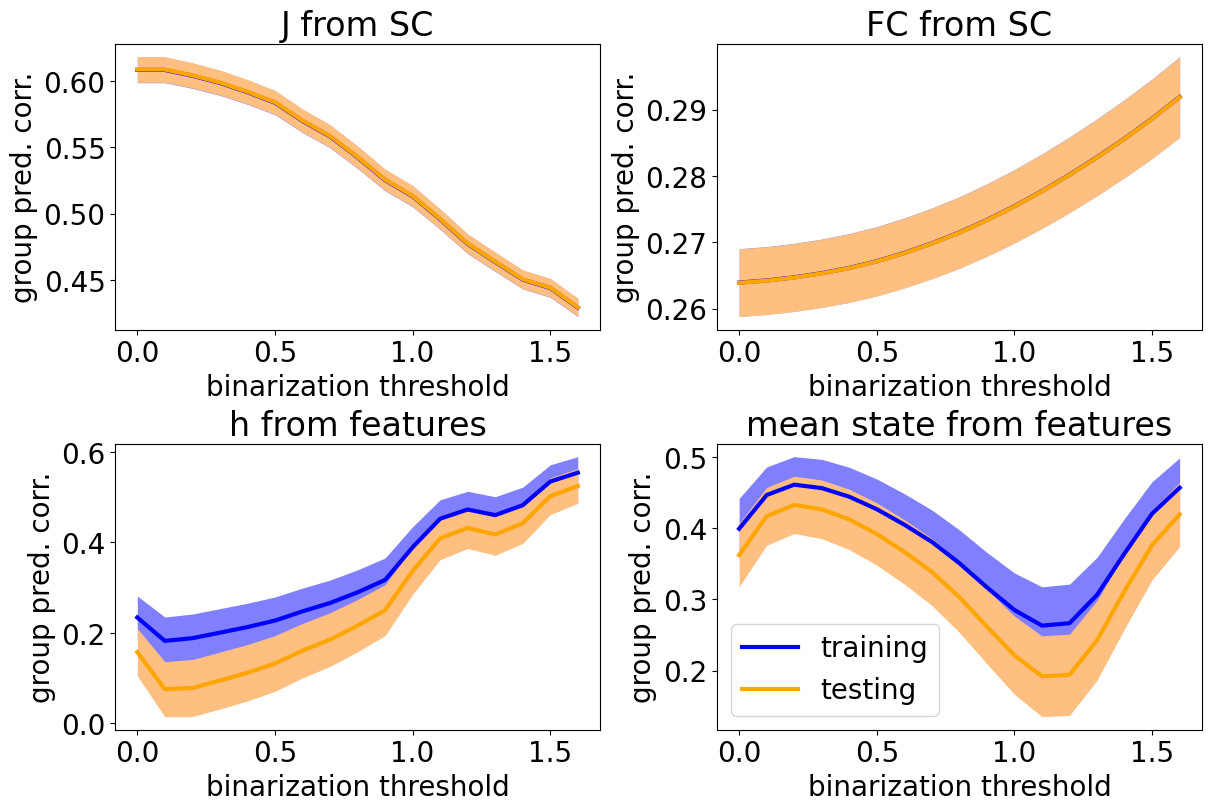

<Figure size 640x480 with 0 Axes>

In [172]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])

fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(12, 8), layout="constrained" )
line_width = 3

train_corr_list = [J_SC_group_corr_train, FC_SC_group_corr_train, h_all_group_corr_train, mean_state_all_group_corr_train]
test_corr_list = [J_SC_group_corr_test, FC_SC_group_corr_test, h_all_group_corr_test, mean_state_all_group_corr_test]
corr_name_list = ['J from SC', 'FC from SC', 'h from features', 'mean state from features']
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(train_corr_list, test_corr_list, [0, 0, 1, 1], [0, 1, 0, 1], corr_name_list):
    train_corr_std, train_corr_mean = torch.std_mean(train_corr, dim=-1)
    train_corr_mean_minus_std = train_corr_mean - train_corr_std
    train_corr_mean_plus_std = train_corr_mean + train_corr_std
    test_corr_std, test_corr_mean = torch.std_mean(test_corr, dim=-1)
    test_corr_mean_minus_std = test_corr_mean - test_corr_std
    test_corr_mean_plus_std = test_corr_mean + test_corr_std
    ax = axs[plot_row, plot_col]
    ax.fill_between( threshold_np, depytorch(train_corr_mean_minus_std[:max_thresh_index]), depytorch(train_corr_mean_plus_std[:max_thresh_index]), color=[0.5, 0.5, 1.0], linewidth=0 )
    ax.plot( threshold_np, depytorch(train_corr_mean[:max_thresh_index]), color='blue', linewidth=line_width, linestyle='solid', label='training' )
    ax.fill_between( threshold_np, depytorch(test_corr_mean_minus_std[:max_thresh_index]), depytorch(test_corr_mean_plus_std[:max_thresh_index]), color=[1.0, 0.75, 0.5], linewidth=0 )
    ax.plot( threshold_np, depytorch(test_corr_mean[:max_thresh_index]), color='orange', linewidth=line_width, linestyle='solid', label='testing' )
    ax.set_xlabel('binarization threshold')
    ax.set_ylabel('group pred. corr.')
    ax.set_title(corr_name)
plt.legend()
# axs.legend( loc='best', bbox_to_anchor=(1.0, 0.5, 1.0, 1.0) )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='center right', bbox_to_anchor=(2.3, 0.5) )
# axs.set_xticks( np.arange(0, max_threshold, 0.5) )
plt.show()
plt.tight_layout()

In [171]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])

train_corr_list = [h_all_group_corr_train, mean_state_all_group_corr_train, J_SC_group_corr_train, FC_SC_group_corr_train]
test_corr_list = [h_all_group_corr_test, mean_state_all_group_corr_test, J_SC_group_corr_test, FC_SC_group_corr_test]
corr_name_list = ['h from features', 'mean state from features', 'J from SC', 'FC from SC']
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(train_corr_list, test_corr_list, [0, 0, 1, 1], [0, 1, 0, 1], corr_name_list):
    p = stats.wilcoxon( depytorch(train_corr), depytorch(test_corr), alternative='greater', axis=1 ).pvalue
    print( corr_name, (train_corr[:max_thresh_index] - test_corr[:max_thresh_index]).abs().max().item(), p.min().item(), p.max().item() )

h from features 0.5135713815689087 0.0 1.2635910481377817e-239
mean state from features 0.49152106046676636 0.0 2.983551397757065e-115
J from SC 0.0809754729270935 0.9557458975068139 0.9713375157142085
FC from SC 0.05092516541481018 0.3099455013942201 0.36708270877943694


In [173]:
print( J_SC_group_corr_train_std.max().item(), J_SC_group_corr_test_std.max().item() )

0.009679027833044529 0.009677580557763577


In [174]:
print( FC_SC_group_corr_train_std.max().item(), FC_SC_group_corr_test_std.max().item() )

0.007490281946957111 0.0074981870129704475


In [170]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])

train_corr_list = [h_all_group_corr_train, mean_state_all_group_corr_train, J_SC_group_corr_train, FC_SC_group_corr_train]
test_corr_list = [h_all_group_corr_test, mean_state_all_group_corr_test, J_SC_group_corr_test, FC_SC_group_corr_test]
corr_name_list = ['h from features', 'mean state from features', 'J from SC', 'FC from SC']
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(train_corr_list, test_corr_list, [0, 0, 1, 1], [0, 1, 0, 1], corr_name_list):
    p = stats.wilcoxon( depytorch(train_corr), depytorch(test_corr), alternative='two-sided', axis=1 ).pvalue
    print( corr_name, (train_corr[:max_thresh_index] - test_corr[:max_thresh_index]).abs().max().item(), p.min().item(), p.max().item() )

h from features 0.5135713815689087 0.0 2.5271820962755635e-239
mean state from features 0.49152106046676636 0.0 5.96710279551413e-115
J from SC 0.0809754729270935 0.05732496857158314 0.08850820498637221
FC from SC 0.05092516541481018 0.6198910027884402 0.7341654175588739


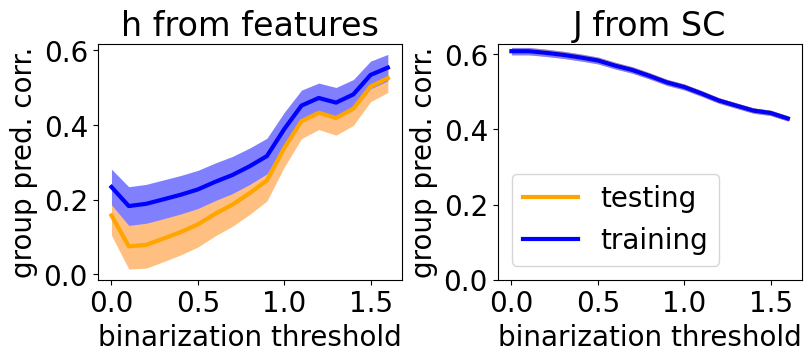

In [134]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])

fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(8, 3.5), layout="constrained" )
line_width = 3

train_corr_list = [h_all_group_corr_train, J_SC_group_corr_train]
test_corr_list = [h_all_group_corr_test, J_SC_group_corr_test]
corr_name_list = ['h from features', 'J from SC']
for train_corr, test_corr, plot_col, corr_name in zip(train_corr_list, test_corr_list, [0, 1], corr_name_list):
    train_corr_std, train_corr_mean = torch.std_mean(train_corr, dim=-1)
    train_corr_mean_minus_std = train_corr_mean - train_corr_std
    train_corr_mean_plus_std = train_corr_mean + train_corr_std
    test_corr_std, test_corr_mean = torch.std_mean(test_corr, dim=-1)
    test_corr_mean_minus_std = test_corr_mean - test_corr_std
    test_corr_mean_plus_std = test_corr_mean + test_corr_std
    ax = axs[plot_col]
    ax.fill_between( threshold_np, depytorch(test_corr_mean_minus_std[:max_thresh_index]), depytorch(test_corr_mean_plus_std[:max_thresh_index]), color=[1.0, 0.75, 0.5], linewidth=0 )
    ax.plot( threshold_np, depytorch(test_corr_mean[:max_thresh_index]), color='orange', linewidth=line_width, linestyle='solid', label='testing' )
    ax.fill_between( threshold_np, depytorch(train_corr_mean_minus_std[:max_thresh_index]), depytorch(train_corr_mean_plus_std[:max_thresh_index]), color=[0.5, 0.5, 1.0], linewidth=0 )
    ax.plot( threshold_np, depytorch(train_corr_mean[:max_thresh_index]), color='blue', linewidth=line_width, linestyle='solid', label='training' )
    ax.set_xticks([0.0, 0.5, 1.0, 1.5])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6])
    ax.set_xlabel('binarization threshold')
    ax.set_ylabel('group pred. corr.')
    ax.set_title(corr_name)
plt.legend()
# axs.legend( loc='best', bbox_to_anchor=(1.0, 0.5, 1.0, 1.0) )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='center right', bbox_to_anchor=(2.3, 0.5) )
# axs.set_xticks( np.arange(0, max_threshold, 0.5) )
plt.show()
# plt.tight_layout()

feature order tensor([1, 2, 3, 0], device='cuda:0')


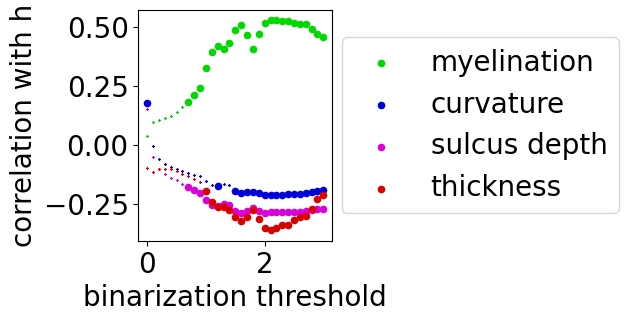

In [64]:
# Order the features in descending order of correlation at max threshold so that it will be easier to match the legend to the lines.
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(2.5, 3) )
# axs.plot(threshold_np, h_pred_corr_np, label=f'linear model', color='orange', linewidth=line_width)

last_h_node_corr_sorted, feature_indices_sorted = torch.sort(corr_group_each_h[max_thresh_index-1,:], descending=True)
print('feature order', feature_indices_sorted)
feature_names_sorted = [feature_names[i] for i in feature_indices_sorted]
feature_colors = [thickness_color,myelination_color,curvature_color,sulcus_depth_color]
feature_colors_sorted = [feature_colors[i] for i in feature_indices_sorted]
for feature_index, feature_name, feature_color in zip(feature_indices_sorted,feature_names_sorted,feature_colors_sorted):
    corr_at_feature = corr_group_each_h[:,feature_index]
    crit_val_at_feature = crit_val_group_each_h[:,feature_index]
    is_sig_at_feature = corr_at_feature.abs() > crit_val_at_feature.abs()
    is_not_sig_at_feature = torch.logical_not(is_sig_at_feature)
    threshold_not_sig = threshold[is_not_sig_at_feature]
    corr_not_sig = corr_at_feature[is_not_sig_at_feature]
    axs.scatter( depytorch(threshold_not_sig), depytorch(corr_not_sig), color=feature_color, s=1, marker='x')
    threshold_sig = threshold[is_sig_at_feature]
    corr_sig = corr_at_feature[is_sig_at_feature]
    axs.scatter( depytorch(threshold_sig), depytorch(corr_sig), color=feature_color, s=20, marker='o', label=feature_name)

# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.55, 0.5) )
# axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation with h')
plt.show()

In [46]:
corr_group_SC_J = torch.load( os.path.join(file_dir, 'corr_group_SC_J_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False ).squeeze()
print( corr_group_SC_J.size() )

torch.Size([31])


In [47]:
corr_group_SC_FC = torch.load( os.path.join(file_dir, 'corr_group_SC_FC_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False ).squeeze()
print( corr_group_SC_FC.size() )

torch.Size([31])


In [48]:
crit_val_group_SC_J = torch.load( os.path.join(file_dir, 'crit_val_group_SC_J_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000.pt'), weights_only=False ).squeeze(dim=0).squeeze(dim=-1)
print( crit_val_group_SC_J.size() )

torch.Size([31])


In [49]:
crit_val_group_SC_FC = torch.load( os.path.join(file_dir, 'crit_val_group_SC_FC_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_perms_10000.pt'), weights_only=False ).squeeze(dim=0).squeeze(dim=-1)
print( crit_val_group_SC_FC.size() )

torch.Size([31])


In [50]:
print( crit_val_group_SC_J.min(), crit_val_group_SC_J.max(), crit_val_group_SC_FC.min(), crit_val_group_SC_FC.max() )

tensor(0.0118, device='cuda:0') tensor(0.0135, device='cuda:0') tensor(0.0124, device='cuda:0') tensor(0.0130, device='cuda:0')


In [51]:
print( torch.stack( (crit_val_group_SC_J, crit_val_group_SC_FC), dim=0 ) )
crit_val_group_SC_max = torch.maximum(crit_val_group_SC_J, crit_val_group_SC_FC)
print( crit_val_group_SC_max.size() )

tensor([[0.0134, 0.0135, 0.0134, 0.0133, 0.0133, 0.0132, 0.0130, 0.0129, 0.0127,
         0.0125, 0.0123, 0.0124, 0.0123, 0.0123, 0.0120, 0.0120, 0.0118, 0.0118,
         0.0119, 0.0121, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0121, 0.0121,
         0.0122, 0.0121, 0.0120, 0.0121],
        [0.0128, 0.0128, 0.0127, 0.0127, 0.0127, 0.0126, 0.0127, 0.0127, 0.0127,
         0.0127, 0.0127, 0.0127, 0.0129, 0.0128, 0.0128, 0.0127, 0.0128, 0.0129,
         0.0130, 0.0129, 0.0130, 0.0130, 0.0129, 0.0128, 0.0126, 0.0125, 0.0124,
         0.0125, 0.0125, 0.0124, 0.0125]], device='cuda:0')
torch.Size([31])


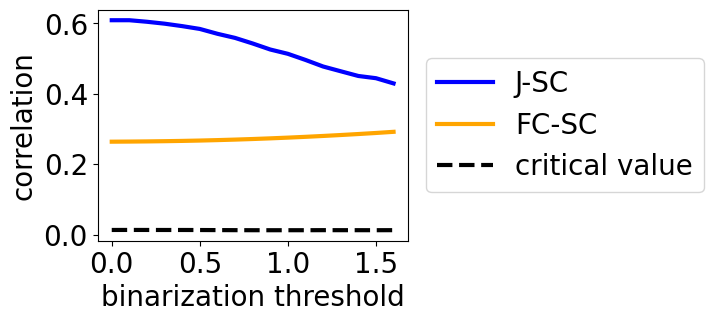

In [52]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
J_sc_corr_np = depytorch(corr_group_SC_J[:max_thresh_index])
fc_sc_corr_np = depytorch(corr_group_SC_FC[:max_thresh_index])
horizontal_crit_np = depytorch(crit_val_group_SC_max[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
line_width = 3
axs.plot(threshold_np, J_sc_corr_np, label='J-SC', color='blue', linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC-SC', color='orange', linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color='black', linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.0, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

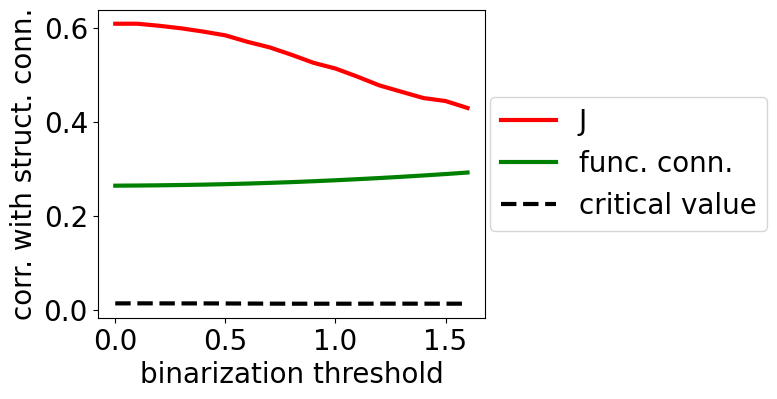

In [68]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
J_sc_corr_np = depytorch(corr_group_SC_J[:max_thresh_index])
fc_sc_corr_np = depytorch(corr_group_SC_FC[:max_thresh_index])
horizontal_crit_np = depytorch(crit_val_group_SC_max[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
line_width = 3
axs.plot(threshold_np, J_sc_corr_np, label='J', color='red', linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='func. conn.', color='green', linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color='black', linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center', bbox_to_anchor=(1.37, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. with struct. conn.')
plt.show()

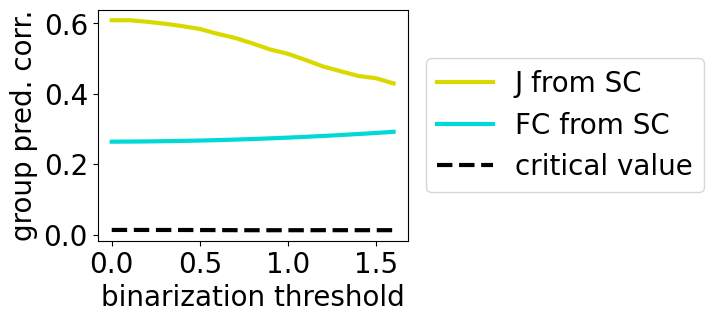

In [62]:
max_threshold = 1.6
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
J_sc_corr_np = depytorch(corr_group_SC_J[:max_thresh_index])
fc_sc_corr_np = depytorch(corr_group_SC_FC[:max_thresh_index])
horizontal_crit_np = depytorch(crit_val_group_SC_max[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
line_width = 3
axs.plot(threshold_np, J_sc_corr_np, label='J from SC', color=j_color, linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC from SC', color=fc_color, linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label=f'critical value', color=crit_color, linewidth=line_width)
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
# axs.legend( loc='right', bbox_to_anchor=(1.47, 0.5) )
axs.legend( loc='center right', bbox_to_anchor=(2.0, 0.5) )
axs.set_xticks( np.arange(0, max_threshold, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('group pred. corr.')
plt.show()

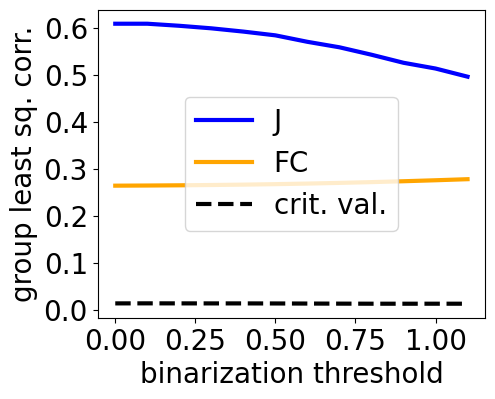

In [51]:
max_threshold = 1.2
max_thresh_index = get_closest_match(values=threshold, target=max_threshold)
threshold_np = depytorch(threshold[:max_thresh_index])
J_sc_corr_np = depytorch(corr_group_SC_J[:max_thresh_index])
fc_sc_corr_np = depytorch(corr_group_SC_FC[:max_thresh_index])
horizontal_crit_np = depytorch(crit_val_group_SC_max[:max_thresh_index])
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
line_width = 3
axs.plot(threshold_np, J_sc_corr_np, label='J', color='blue', linewidth=line_width)
axs.plot(threshold_np, fc_sc_corr_np, label='FC', color='orange', linewidth=line_width)
axs.plot(threshold_np, horizontal_crit_np, linestyle='--', label='crit. val.', color='black', linewidth=line_width)
axs.legend(loc='center')
axs.set_xticks( np.arange(0, max_threshold, 0.25) )
axs.set_yticks( np.arange(0, 0.61, 0.1) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('group least sq. corr.')
plt.show()

In [67]:
lstsq_corr_all_mean_state_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_all_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( lstsq_corr_all_mean_state_1.size() )

torch.Size([360])


In [68]:
lstsq_corr_all_mean_state_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_all_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=True )
print( lstsq_corr_all_mean_state_0.size() )

torch.Size([360])


In [69]:
lstsq_corr_all_h_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_all_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=True )
print( lstsq_corr_all_h_1.size() )

torch.Size([360])


In [70]:
lstsq_corr_all_h_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_all_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=True )
print( lstsq_corr_all_h_0.size() )

torch.Size([360])


Text(0, 0.5, 'h-h(features) correlation')

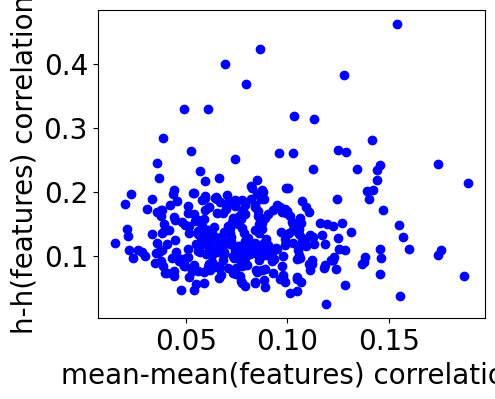

In [67]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
axs.scatter( depytorch(lstsq_corr_all_mean_state_1), depytorch(lstsq_corr_all_h_1), color='blue' )
axs.set_xlabel('mean-mean(features) correlation')
axs.set_ylabel('h-h(features) correlation')

In [68]:
print(  stats.wilcoxon( depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_1), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(58714.0), pvalue=np.float64(1.6853471971717013e-40))


In [69]:
print(  stats.wilcoxon( depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_mean_state_0), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(30544.0), pvalue=np.float64(0.8376543992722232))


In [157]:
corr_SC_J_1 = torch.load( f=os.path.join(file_dir, 'corr_SC_J_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_SC_J_1.size() )
p_SC_J_1 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_J_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=True )
print( p_SC_J_1.size() )
is_sig_SC_J_1 = p_SC_J_1.abs() < 0.025/p_SC_J_1.numel()
sig_corr_SC_J_1 = corr_SC_J_1[is_sig_SC_J_1]
print( torch.count_nonzero(is_sig_SC_J_1).item(), sig_corr_SC_J_1.min().item() )

torch.Size([64620])
torch.Size([64620])
495 0.12089823931455612


In [156]:
corr_SC_J_0 = torch.load( f=os.path.join(file_dir, 'corr_SC_J_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=True )
print( corr_SC_J_0.size() )
p_SC_J_0 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_J_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=True )
print( p_SC_J_0.size() )
is_sig_SC_J_0 = p_SC_J_0.abs() < 0.025/p_SC_J_0.numel()
sig_corr_SC_J_0 = corr_SC_J_0[is_sig_SC_J_0]
print( torch.count_nonzero(is_sig_SC_J_0).item(), sig_corr_SC_J_0.min().item() )

torch.Size([64620])
torch.Size([64620])
602 0.12353548407554626


In [155]:
corr_SC_FC_1 = torch.load( f=os.path.join(file_dir, 'corr_SC_FC_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_SC_FC_1.size() )
p_SC_FC_1 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_FC_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=True )
print( p_SC_FC_1.size() )
is_sig_SC_FC_1 = p_SC_FC_1.abs() < 0.025/p_SC_FC_1.numel()
sig_corr_SC_FC_1 = corr_SC_FC_1[is_sig_SC_FC_1]
print( torch.count_nonzero(is_sig_SC_FC_1).item(), sig_corr_SC_FC_1.min().item() )

torch.Size([64620])
torch.Size([64620])
310 0.12167048454284668


In [154]:
corr_SC_FC_0 = torch.load( f=os.path.join(file_dir, 'corr_SC_FC_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=True )
print( corr_SC_FC_0.size() )
p_SC_FC_0 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=True )
print( p_SC_FC_0.size() )
is_sig_SC_FC_0 = p_SC_FC_0.abs() < 0.025/p_SC_FC_0.numel()
sig_corr_SC_FC_0 = corr_SC_FC_0[is_sig_SC_FC_0]
print( torch.count_nonzero(is_sig_SC_FC_0).item(), sig_corr_SC_FC_0.min().item() )

torch.Size([64620])
torch.Size([64620])
360 0.12271099537611008


In [58]:
print( torch.median(corr_SC_J_1).item(), torch.median(corr_SC_FC_1).item(), torch.median(corr_SC_J_0).item(), torch.median(corr_SC_FC_0).item() )

0.0022402373142540455 8.851283200783655e-05 0.003580274060368538 0.0024125706404447556


In [59]:
print(  ( torch.count_nonzero(corr_SC_J_1 > corr_SC_FC_1)/corr_SC_J_1.numel() ).item(), ( torch.count_nonzero(corr_SC_J_0 > corr_SC_FC_0)/corr_SC_J_0.numel() ).item()  )

0.5201640129089355 0.5150572657585144


In [60]:
print(  stats.wilcoxon(  depytorch(corr_SC_FC_1), depytorch(corr_SC_J_1), alternative='two-sided' )  )

WilcoxonResult(statistic=np.float64(985072142.5), pvalue=np.float64(2.123148670822421e-35))


In [61]:
print(  stats.wilcoxon(  depytorch(corr_SC_J_0), depytorch(corr_SC_J_1), alternative='two-sided' )  )

WilcoxonResult(statistic=np.float64(994501508.0), pvalue=np.float64(1.84409911440682e-25))


In [62]:
print(  stats.wilcoxon(  depytorch(corr_SC_FC_0), depytorch(corr_SC_J_0), alternative='two-sided' )  )

WilcoxonResult(statistic=np.float64(997735590.5), pvalue=np.float64(1.9156915129507407e-22))


In [63]:
print(  stats.wilcoxon(  depytorch(corr_SC_FC_0), depytorch(corr_SC_FC_1), alternative='two-sided' )  )

WilcoxonResult(statistic=np.float64(897747724.5), pvalue=np.float64(9.887790961306353e-209))


In [76]:
corr_SC_J_1_abs = corr_SC_J_1.abs()
corr_SC_FC_1_abs = corr_SC_FC_1.abs()
corr_SC_J_0_abs = corr_SC_J_0.abs()
corr_SC_FC_0_abs = corr_SC_FC_0.abs()

In [77]:
print(  stats.wilcoxon(  depytorch(corr_SC_FC_1_abs), depytorch(corr_SC_J_1_abs), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(1121461633.5), pvalue=np.float64(2.3543310773321662e-60))


In [78]:
print(  stats.wilcoxon(  depytorch(corr_SC_FC_0_abs), depytorch(corr_SC_J_0_abs), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(1118573942.0), pvalue=np.float64(4.270239318242465e-56))


In [79]:
print( torch.median(corr_SC_J_1_abs).item(), torch.median(corr_SC_FC_1_abs).item(), torch.median(corr_SC_J_0_abs).item(), torch.median(corr_SC_FC_0_abs).item() )

0.025754306465387344 0.028191231191158295 0.026090163737535477 0.02864052727818489


In [44]:
corr_thickness_h_0 = torch.load( f=os.path.join(file_dir, 'corr_thickness_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_thickness_h_0.size() )
corr_myelination_h_0 = torch.load( f=os.path.join(file_dir, 'corr_myelination_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_myelination_h_0.size() )
corr_curvature_h_0 = torch.load( f=os.path.join(file_dir, 'corr_curvature_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_curvature_h_0.size() )
corr_sulcus_depth_h_0 = torch.load( f=os.path.join(file_dir, 'corr_sulcus_depth_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_sulcus_depth_h_0.size() )

torch.Size([360])
torch.Size([360])
torch.Size([360])
torch.Size([360])


In [45]:
corr_thickness_h_1 = torch.load( f=os.path.join(file_dir, 'corr_thickness_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_thickness_h_1.size() )
corr_myelination_h_1 = torch.load( f=os.path.join(file_dir, 'corr_myelination_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_myelination_h_1.size() )
corr_curvature_h_1 = torch.load( f=os.path.join(file_dir, 'corr_curvature_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_curvature_h_1.size() )
corr_sulcus_depth_h_1 = torch.load( f=os.path.join(file_dir, 'corr_sulcus_depth_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_sulcus_depth_h_1.size() )

torch.Size([360])
torch.Size([360])
torch.Size([360])
torch.Size([360])


In [46]:
corr_thickness_mean_state_0 = torch.load( f=os.path.join(file_dir, 'corr_thickness_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_thickness_mean_state_0.size() )
corr_myelination_mean_state_0 = torch.load( f=os.path.join(file_dir, 'corr_myelination_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_myelination_mean_state_0.size() )
corr_curvature_mean_state_0 = torch.load( f=os.path.join(file_dir, 'corr_curvature_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_curvature_mean_state_0.size() )
corr_sulcus_depth_mean_state_0 = torch.load( f=os.path.join(file_dir, 'corr_sulcus_depth_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_v2.pt'), weights_only=True )
print( corr_sulcus_depth_mean_state_0.size() )

torch.Size([360])
torch.Size([360])
torch.Size([360])
torch.Size([360])


In [47]:
corr_thickness_mean_state_1 = torch.load( f=os.path.join(file_dir, 'corr_thickness_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_thickness_mean_state_1.size() )
corr_myelination_mean_state_1 = torch.load( f=os.path.join(file_dir, 'corr_myelination_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_myelination_mean_state_1.size() )
corr_curvature_mean_state_1 = torch.load( f=os.path.join(file_dir, 'corr_curvature_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_curvature_mean_state_1.size() )
corr_sulcus_depth_mean_state_1 = torch.load( f=os.path.join(file_dir, 'corr_sulcus_depth_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_v2.pt'), weights_only=True )
print( corr_sulcus_depth_mean_state_1.size() )

torch.Size([360])
torch.Size([360])
torch.Size([360])
torch.Size([360])


thickness=1thickness+-4.59e-10, R^2=1, corr.=0.997
myelination=-0.255thickness+0.0208, R^2=0.0276, corr.=-0.166
curvature=0.236thickness+0.0427, R^2=0.0207, corr.=0.143
sulcus depth=0.313thickness+0.0181, R^2=0.0331, corr.=0.181
thickness=-0.108myelination+0.0426, R^2=0.0276, corr.=-0.166
myelination=1myelination+7.97e-10, R^2=1, corr.=0.997
curvature=-0.341myelination+0.056, R^2=0.102, corr.=-0.318
sulcus depth=-0.434myelination+0.0355, R^2=0.149, corr.=-0.385
thickness=0.0876curvature+0.0369, R^2=0.0207, corr.=0.143
myelination=-0.298curvature+0.0259, R^2=0.102, corr.=-0.318
curvature=1curvature+5.07e-10, R^2=1, corr.=0.997
sulcus depth=0.949curvature+-0.0187, R^2=0.817, corr.=0.901
thickness=0.106sulcus depth+0.0382, R^2=0.0331, corr.=0.181
myelination=-0.344sulcus depth+0.0209, R^2=0.149, corr.=-0.385
curvature=0.861sulcus depth+0.0257, R^2=0.817, corr.=0.901
sulcus depth=1sulcus depth+-7.53e-10, R^2=1, corr.=0.997


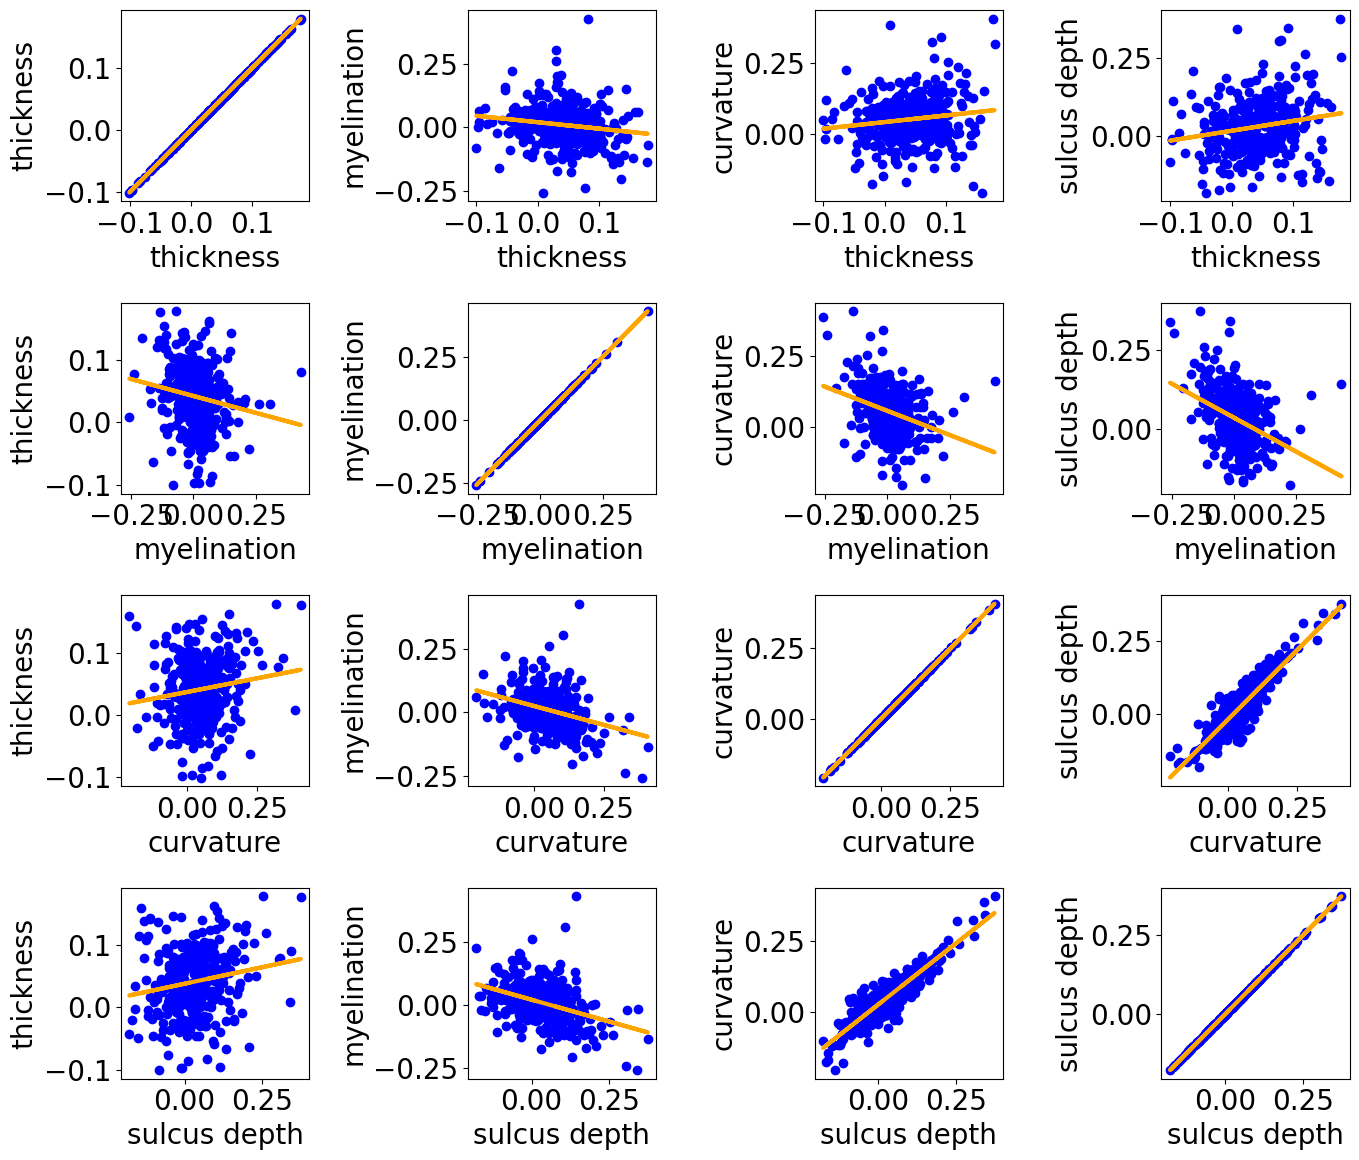

In [51]:
all_direct_corrs = [corr_thickness_h_1, corr_myelination_h_1, corr_curvature_h_1, corr_sulcus_depth_h_1]
corr_labels = ['thickness', 'myelination', 'curvature', 'sulcus depth']
plot_indices = [0, 1, 2, 3]
fig, axs = plt.subplots( nrows=4, ncols=4, figsize=(14, 12) )
for direct_corr_1, plot_row, corr_name_1 in zip(all_direct_corrs,plot_indices,corr_labels):
    for direct_corr_2, plot_col, corr_name_2 in zip(all_direct_corrs,plot_indices,corr_labels):
        ax = axs[plot_row,plot_col]
        make_scatter_plot_with_regression_line(ax, feature=direct_corr_1, param=direct_corr_2, feature_name=corr_name_1, param_name=corr_name_2)
plt.tight_layout()

myelination=-0.255thickness+0.0208, R^2=0.0276, corr.=-0.166
curvature=0.236thickness+0.0427, R^2=0.0207, corr.=0.143
sulcus depth=0.313thickness+0.0181, R^2=0.0331, corr.=0.181
curvature=-0.341myelination+0.056, R^2=0.102, corr.=-0.318
sulcus depth=-0.434myelination+0.0355, R^2=0.149, corr.=-0.385
sulcus depth=0.949curvature+-0.0187, R^2=0.817, corr.=0.901


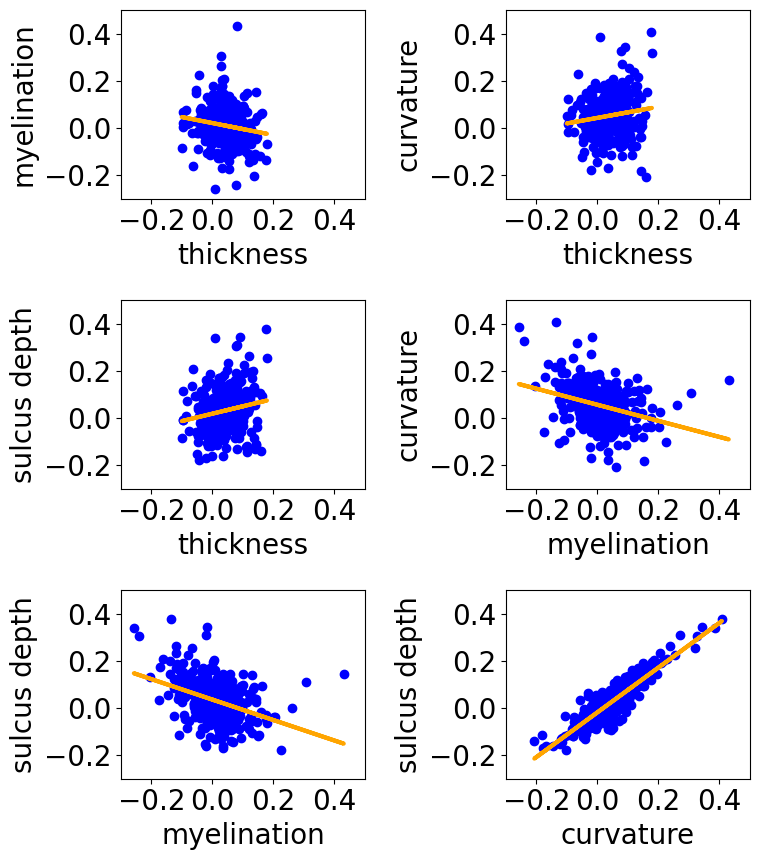

In [70]:
feature_pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
all_direct_corrs = [corr_thickness_h_1, corr_myelination_h_1, corr_curvature_h_1, corr_sulcus_depth_h_1]
corr_labels = ['thickness', 'myelination', 'curvature', 'sulcus depth']
plot_indices = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(8, 9) )
for feature_pair, plot_index_pair in zip(feature_pairs, plot_indices):
    plot_row = plot_index_pair[0]
    plot_col = plot_index_pair[1]
    ax = axs[plot_row,plot_col]
    feature_index_1 = feature_pair[0]
    direct_corr_1 = all_direct_corrs[feature_index_1]
    corr_name_1 = corr_labels[feature_index_1]
    feature_index_2 = feature_pair[1]
    direct_corr_2 = all_direct_corrs[feature_index_2]
    corr_name_2 = corr_labels[feature_index_2]
    make_scatter_plot_with_regression_line(ax, feature=direct_corr_1, param=direct_corr_2, feature_name=corr_name_1, param_name=corr_name_2)
    ax.set_xlim([-0.3, 0.5])
    ax.set_xticks([-0.2, 0.0, 0.2, 0.4])
    ax.set_ylim([-0.3, 0.5])
    ax.set_yticks([-0.2, 0.0, 0.2, 0.4])
plt.tight_layout()

([<matplotlib.patches.Wedge at 0x1be8c402320>,
 [Text(0.777817442305461, 0.7778174763049434, 'thickness'),
  Text(-0.669637599942226, 0.872688652810162, 'myelination'),
  Text(-0.7501984110654047, -0.8044888712934084, 'curvature'),
  Text(0.8955272914322183, -0.638772941114505, 'sulcus depth')],
 [Text(0.4242640594393423, 0.4242640779845145, '25%'),
  Text(-0.3652568726957596, 0.47601199244190645, '20.8%'),
  Text(-0.4091991333084025, -0.43881211161458633, '34.4%'),
  Text(0.4884694316903008, -0.34842160424427543, '19.7%')])

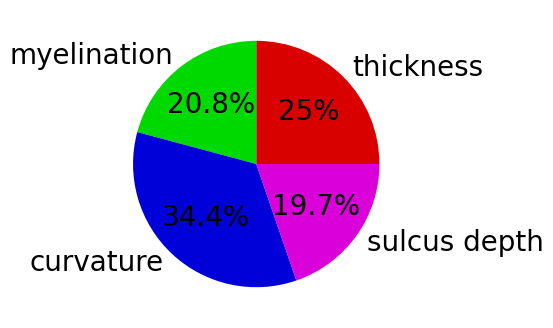

In [143]:
direct_corrs_tensor = torch.stack( (corr_thickness_h_1, corr_myelination_h_1, corr_curvature_h_1, corr_sulcus_depth_h_1), dim=0 )
num_features = len(corr_labels)
biggest_abs_corr, biggest_abs_corr_index = direct_corrs_tensor.abs().max(dim=0)
biggest_abs_corr_counts = [ torch.count_nonzero(biggest_abs_corr_index == feature_index).item() for feature_index in range(num_features) ]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
num_nodes = biggest_abs_corr_index.numel()
autopct = lambda x: f'{x:.3g}%'
axs.pie(biggest_abs_corr_counts, labels=corr_labels, autopct=autopct, colors=[thickness_color, myelination_color, curvature_color, sulcus_depth_color])

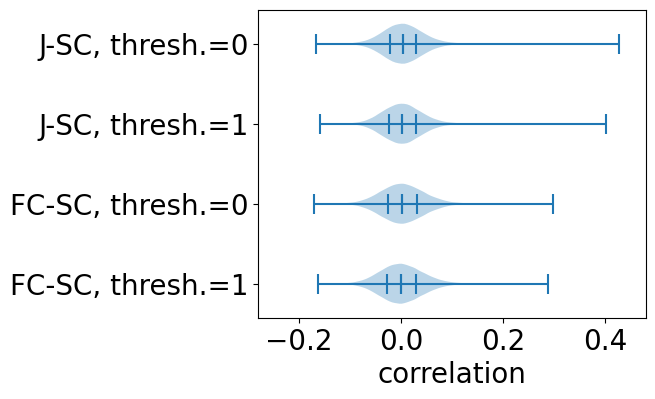

In [116]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J-SC, thresh.=0', 'J-SC, thresh.=1', 'FC-SC, thresh.=0', 'FC-SC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_SC_J_0), depytorch(corr_SC_J_1), depytorch(corr_SC_FC_0), depytorch(corr_SC_FC_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

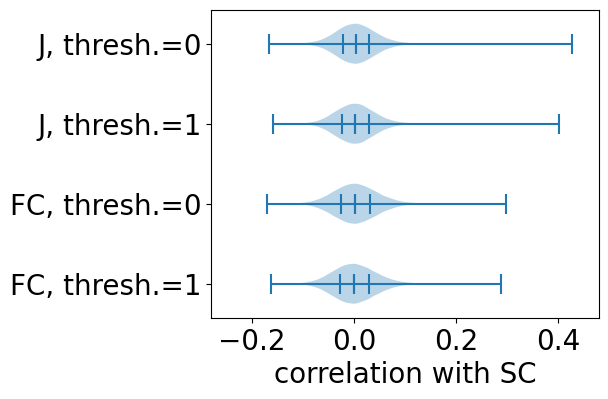

In [117]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_SC_J_0), depytorch(corr_SC_J_1), depytorch(corr_SC_FC_0), depytorch(corr_SC_FC_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation with SC')
plt.show()

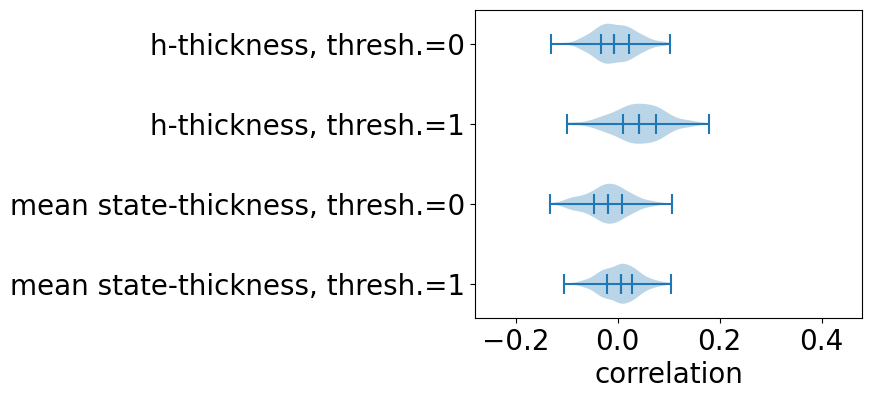

In [118]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h-thickness, thresh.=0', 'h-thickness, thresh.=1', 'mean state-thickness, thresh.=0', 'mean state-thickness, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_thickness_h_0), depytorch(corr_thickness_h_1), depytorch(corr_thickness_mean_state_0), depytorch(corr_thickness_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_xlim([-0.28, 0.48])
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

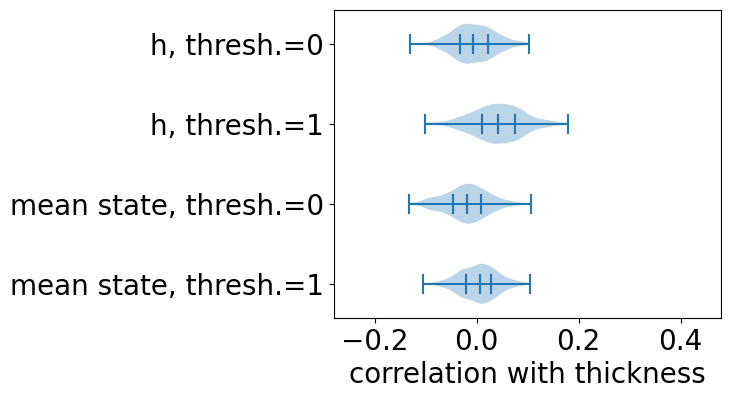

In [119]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_thickness_h_0), depytorch(corr_thickness_h_1), depytorch(corr_thickness_mean_state_0), depytorch(corr_thickness_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_xlim([-0.28, 0.48])
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation with thickness')
plt.show()

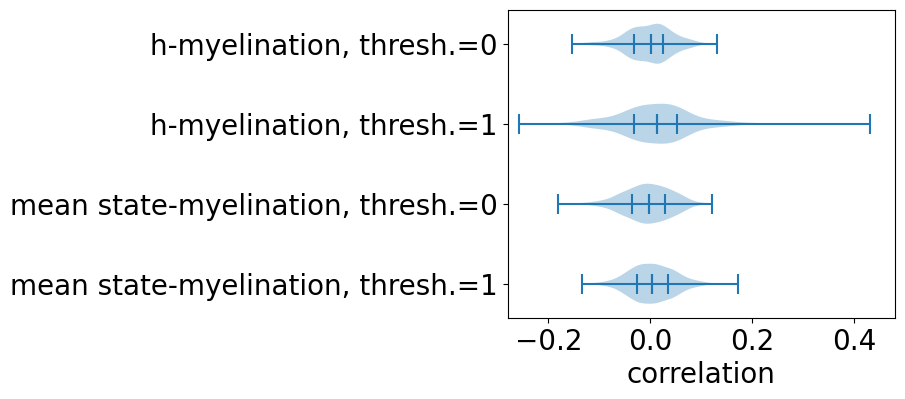

In [114]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h-myelination, thresh.=0', 'h-myelination, thresh.=1', 'mean state-myelination, thresh.=0', 'mean state-myelination, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_myelination_h_0), depytorch(corr_myelination_h_1), depytorch(corr_myelination_mean_state_0), depytorch(corr_myelination_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

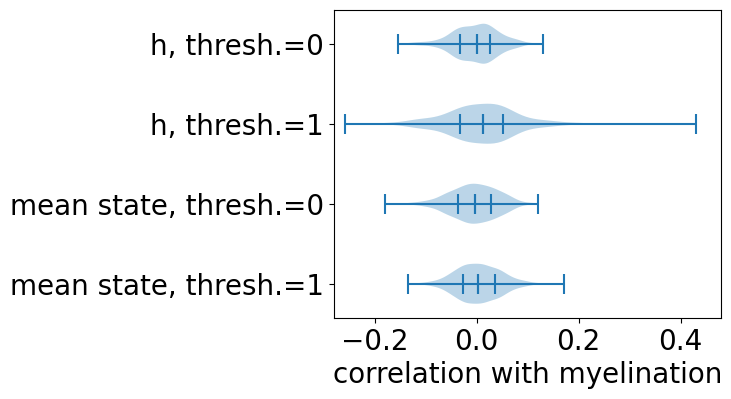

In [120]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_myelination_h_0), depytorch(corr_myelination_h_1), depytorch(corr_myelination_mean_state_0), depytorch(corr_myelination_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation with myelination')
plt.show()

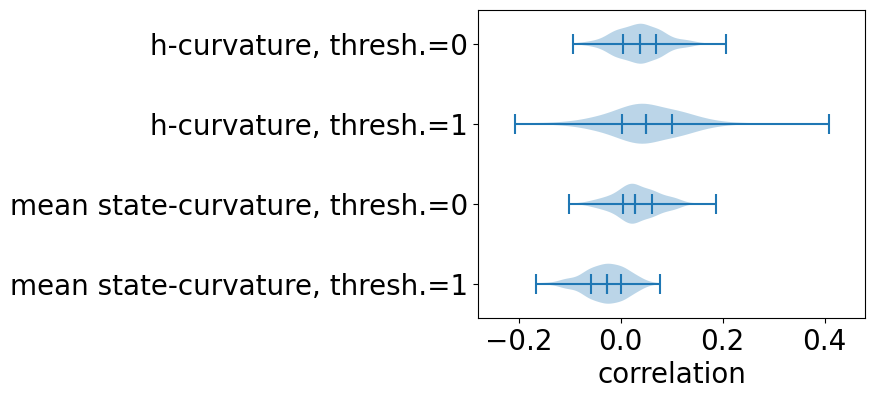

In [113]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h-curvature, thresh.=0', 'h-curvature, thresh.=1', 'mean state-curvature, thresh.=0', 'mean state-curvature, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_curvature_h_0), depytorch(corr_curvature_h_1), depytorch(corr_curvature_mean_state_0), depytorch(corr_curvature_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

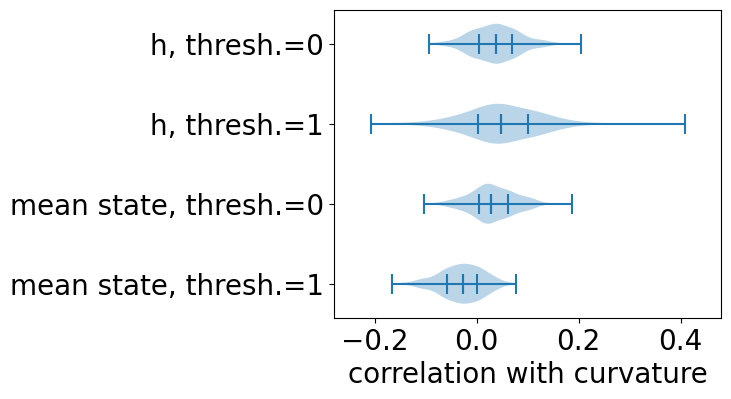

In [121]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_curvature_h_0), depytorch(corr_curvature_h_1), depytorch(corr_curvature_mean_state_0), depytorch(corr_curvature_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation with curvature')
plt.show()

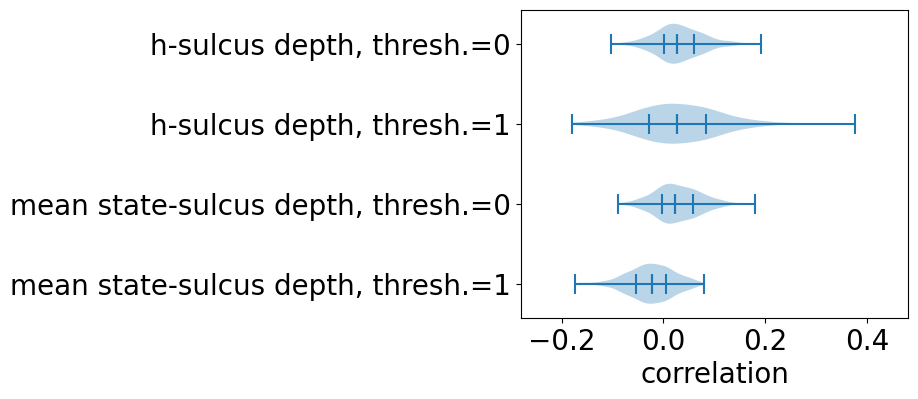

In [112]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h-sulcus depth, thresh.=0', 'h-sulcus depth, thresh.=1', 'mean state-sulcus depth, thresh.=0', 'mean state-sulcus depth, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_sulcus_depth_h_0), depytorch(corr_sulcus_depth_h_1), depytorch(corr_sulcus_depth_mean_state_0), depytorch(corr_sulcus_depth_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

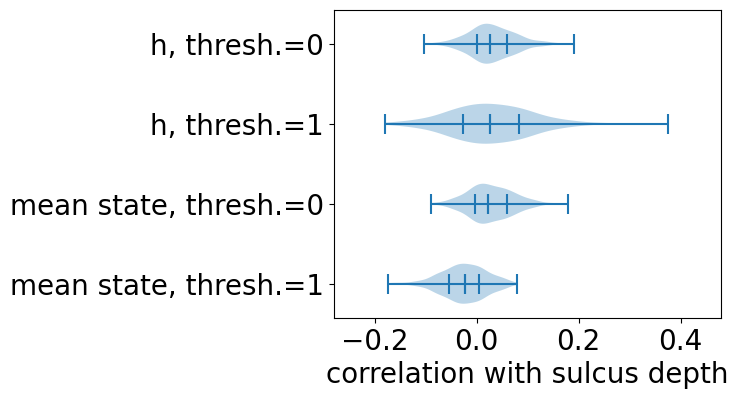

In [122]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_sulcus_depth_h_0), depytorch(corr_sulcus_depth_h_1), depytorch(corr_sulcus_depth_mean_state_0), depytorch(corr_sulcus_depth_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation with sulcus depth')
plt.show()

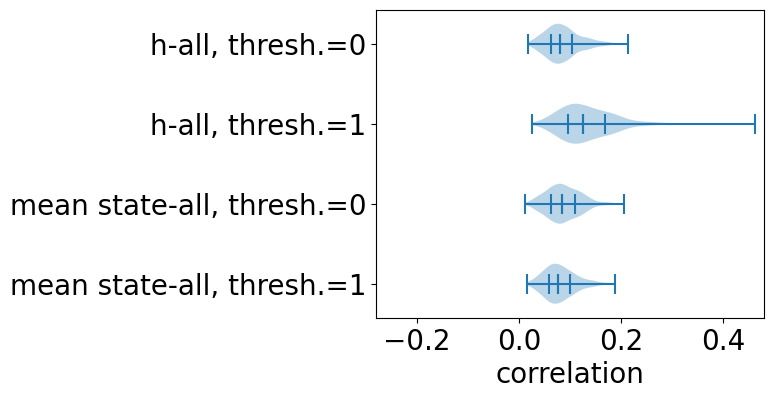

In [111]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h-all, thresh.=0', 'h-all, thresh.=1', 'mean state-all, thresh.=0', 'mean state-all, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_0), depytorch(lstsq_corr_all_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

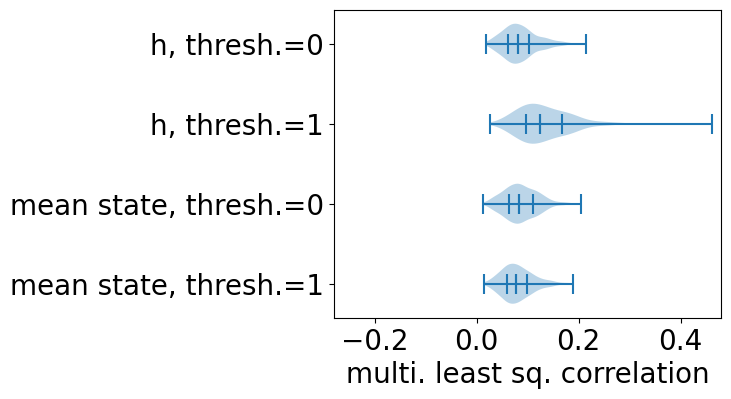

In [143]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_0), depytorch(lstsq_corr_all_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xlim([-0.28, 0.48])
axs.set_xticks( np.arange(-0.2, 0.45, 0.2) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('multi. least sq. correlation')
plt.show()

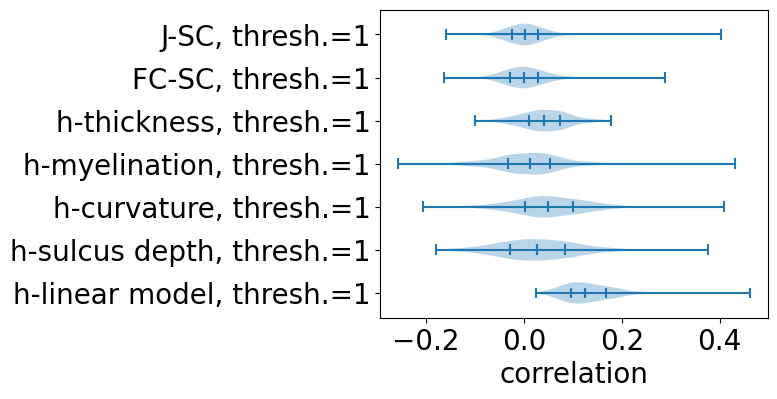

In [71]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J-SC, thresh.=1', 'FC-SC, thresh.=1', 'h-thickness, thresh.=1', 'h-myelination, thresh.=1', 'h-curvature, thresh.=1', 'h-sulcus depth, thresh.=1', 'h-linear model, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_SC_J_1), depytorch(corr_SC_FC_1), depytorch(corr_thickness_h_1), depytorch(corr_myelination_h_1), depytorch(corr_curvature_h_1), depytorch(corr_sulcus_depth_h_1), depytorch(lstsq_corr_all_h_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
# axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

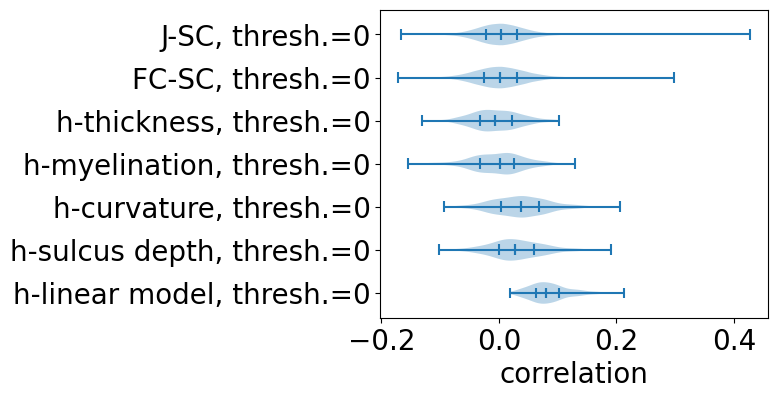

In [73]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J-SC, thresh.=0', 'FC-SC, thresh.=0', 'h-thickness, thresh.=0', 'h-myelination, thresh.=0', 'h-curvature, thresh.=0', 'h-sulcus depth, thresh.=0', 'h-linear model, thresh.=0']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_SC_J_0), depytorch(corr_SC_FC_0), depytorch(corr_thickness_h_0), depytorch(corr_myelination_h_0), depytorch(corr_curvature_h_0), depytorch(corr_sulcus_depth_h_0), depytorch(lstsq_corr_all_h_0)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
# axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

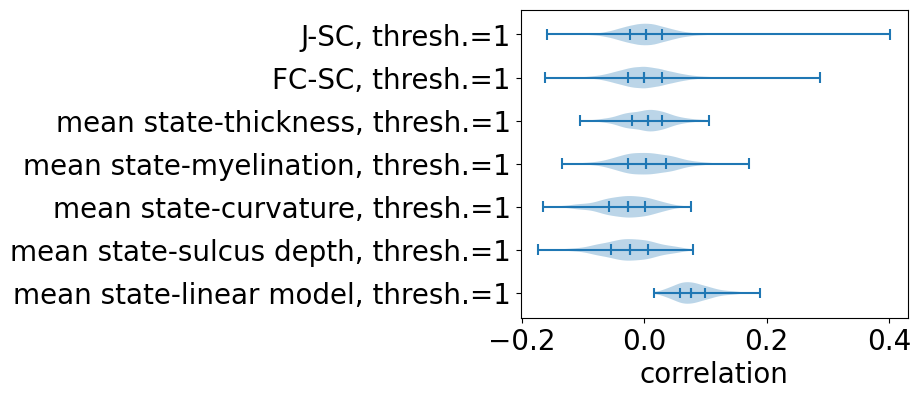

In [79]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J-SC, thresh.=1', 'FC-SC, thresh.=1', 'mean state-thickness, thresh.=1', 'mean state-myelination, thresh.=1', 'mean state-curvature, thresh.=1', 'mean state-sulcus depth, thresh.=1', 'mean state-linear model, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_SC_J_1), depytorch(corr_SC_FC_1), depytorch(corr_thickness_mean_state_1), depytorch(corr_myelination_mean_state_1), depytorch(corr_curvature_mean_state_1), depytorch(corr_sulcus_depth_mean_state_1), depytorch(lstsq_corr_all_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
# axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

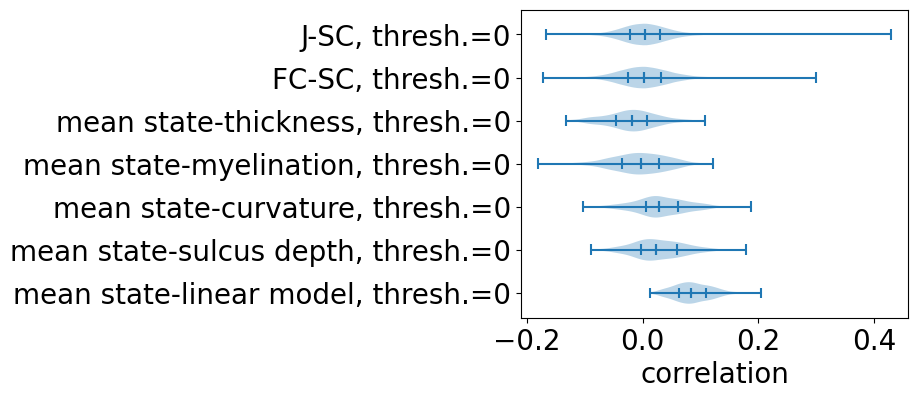

In [76]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J-SC, thresh.=0', 'FC-SC, thresh.=0', 'mean state-thickness, thresh.=0', 'mean state-myelination, thresh.=0', 'mean state-curvature, thresh.=0', 'mean state-sulcus depth, thresh.=0', 'mean state-linear model, thresh.=0']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_SC_J_0), depytorch(corr_SC_FC_0), depytorch(corr_thickness_mean_state_0), depytorch(corr_myelination_mean_state_0), depytorch(corr_curvature_mean_state_0), depytorch(corr_sulcus_depth_mean_state_0), depytorch(lstsq_corr_all_mean_state_0)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
# axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

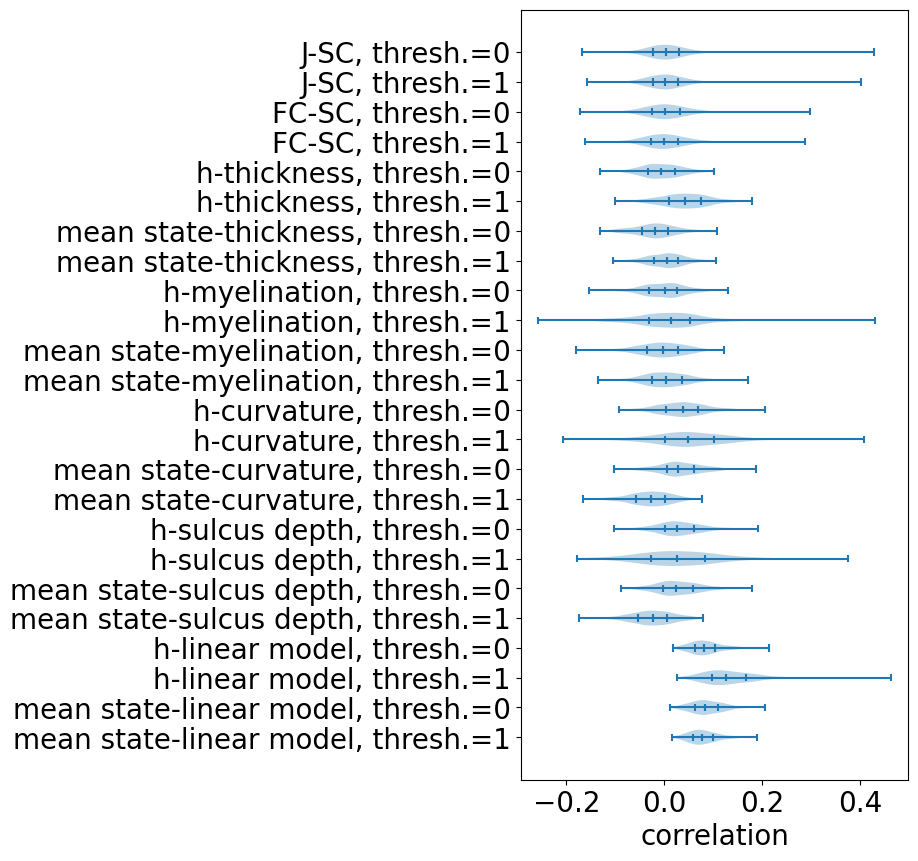

In [84]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 10) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J-SC, thresh.=0', 'J-SC, thresh.=1', 'FC-SC, thresh.=0', 'FC-SC, thresh.=1', 'h-thickness, thresh.=0', 'h-thickness, thresh.=1', 'mean state-thickness, thresh.=0', 'mean state-thickness, thresh.=1', 'h-myelination, thresh.=0', 'h-myelination, thresh.=1', 'mean state-myelination, thresh.=0', 'mean state-myelination, thresh.=1', 'h-curvature, thresh.=0', 'h-curvature, thresh.=1', 'mean state-curvature, thresh.=0', 'mean state-curvature, thresh.=1', 'h-sulcus depth, thresh.=0', 'h-sulcus depth, thresh.=1', 'mean state-sulcus depth, thresh.=0', 'mean state-sulcus depth, thresh.=1', 'h-linear model, thresh.=0', 'h-linear model, thresh.=1', 'mean state-linear model, thresh.=0', 'mean state-linear model, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(corr_SC_J_0), depytorch(corr_SC_J_1), depytorch(corr_SC_FC_0), depytorch(corr_SC_FC_1), depytorch(corr_thickness_h_0), depytorch(corr_thickness_h_1), depytorch(corr_thickness_mean_state_0), depytorch(corr_thickness_mean_state_1), depytorch(corr_myelination_h_0), depytorch(corr_myelination_h_1), depytorch(corr_myelination_mean_state_0), depytorch(corr_myelination_mean_state_1), depytorch(corr_curvature_h_0), depytorch(corr_curvature_h_1), depytorch(corr_curvature_mean_state_0), depytorch(corr_curvature_mean_state_1), depytorch(corr_sulcus_depth_h_0), depytorch(corr_sulcus_depth_h_1), depytorch(corr_sulcus_depth_mean_state_0), depytorch(corr_sulcus_depth_mean_state_1), depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_0), depytorch(lstsq_corr_all_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
# axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

Text(0, 0.5, 'SC-J correlation')

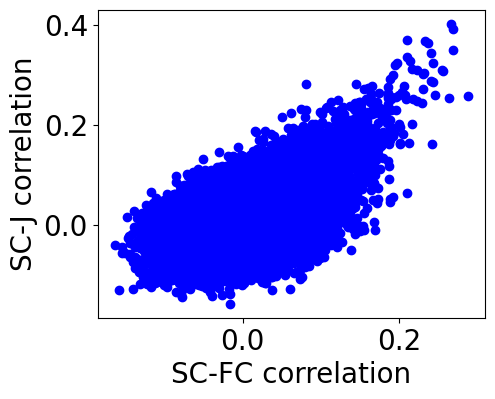

In [80]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
axs.scatter( depytorch(corr_SC_FC_1), depytorch(corr_SC_J_1), color='blue' )
axs.set_xlabel('SC-FC correlation')
axs.set_ylabel('SC-J correlation')

Text(0, 0.5, '|SC-J correlation|')

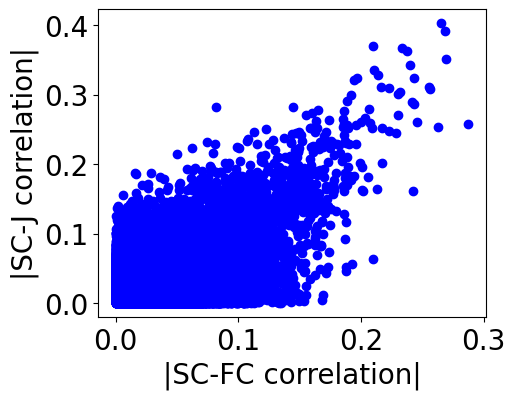

In [81]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
axs.scatter( depytorch(corr_SC_FC_1_abs), depytorch(corr_SC_J_1_abs), color='blue' )
axs.set_xlabel('|SC-FC correlation|')
axs.set_ylabel('|SC-J correlation|')

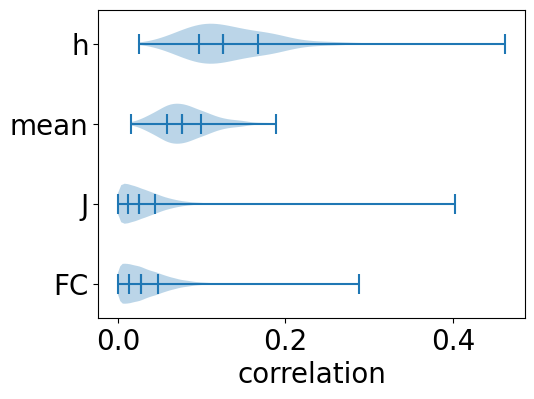

In [82]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h', 'mean', 'J', 'FC']
label_x = range( 1, len(corr_labels)+1 )
# all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(h_node_feature_corr_tensor[:,feature_index]) for feature_index in range( h_node_feature_corr_tensor.size(dim=-1) )] + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
all_corrs = [depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_1), depytorch(corr_SC_J_1_abs), depytorch(corr_SC_FC_1_abs)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [ ]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J-SC, thresh.=0', 'J-SC, thresh.=1', 'FC-SC, thresh.=0', 'FC-SC, thresh.=1', 'h from all, thresh.=0', 'h from all, thresh.=1', 'mean state from all, thresh.=0', 'mean state from all, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
# all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(h_node_feature_corr_tensor[:,feature_index]) for feature_index in range( h_node_feature_corr_tensor.size(dim=-1) )] + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
all_corrs = [depytorch(corr_SC_J_0), depytorch(corr_SC_J_1), depytorch(corr_SC_FC_0), depytorch(corr_SC_FC_1), depytorch(corr_each_h_0), depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_0), depytorch(lstsq_corr_all_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('individual pred. corr.')
plt.show()

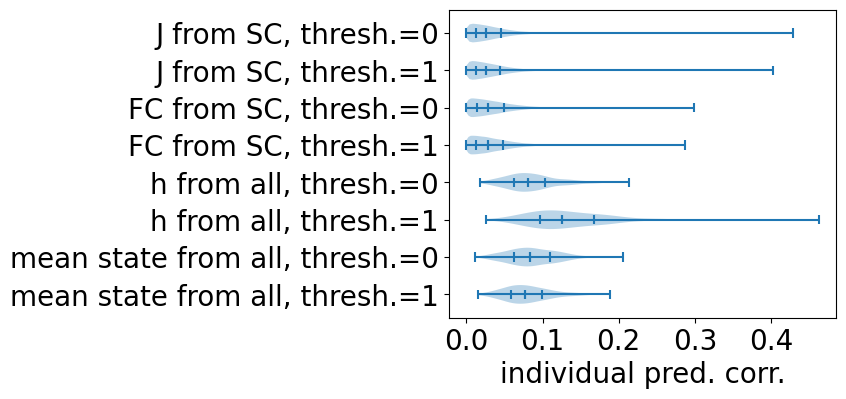

In [147]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J from SC, thresh.=0', 'J from SC, thresh.=1', 'FC from SC, thresh.=0', 'FC from SC, thresh.=1', 'h from all, thresh.=0', 'h from all, thresh.=1', 'mean state from all, thresh.=0', 'mean state from all, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
# all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(h_node_feature_corr_tensor[:,feature_index]) for feature_index in range( h_node_feature_corr_tensor.size(dim=-1) )] + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
all_corrs = [depytorch(corr_SC_J_0_abs), depytorch(corr_SC_J_1_abs), depytorch(corr_SC_FC_0_abs), depytorch(corr_SC_FC_1_abs), depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_0), depytorch(lstsq_corr_all_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('individual pred. corr.')
plt.show()

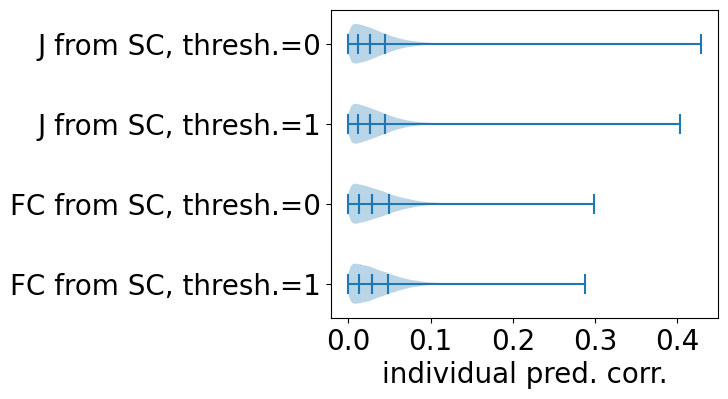

In [151]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J from SC, thresh.=0', 'J from SC, thresh.=1', 'FC from SC, thresh.=0', 'FC from SC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
# all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(h_node_feature_corr_tensor[:,feature_index]) for feature_index in range( h_node_feature_corr_tensor.size(dim=-1) )] + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
all_corrs = [depytorch(corr_SC_J_0_abs), depytorch(corr_SC_J_1_abs), depytorch(corr_SC_FC_0_abs), depytorch(corr_SC_FC_1_abs)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xticks( np.arange(0, 0.41, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('individual pred. corr.')
plt.show()

In [161]:
p_J_SC_0 = torch.load( os.path.join(file_dir, 'p_value_corr_SC_J_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=False )
print( p_J_SC_0.size() )
p_J_SC_1 = torch.load( os.path.join(file_dir, 'p_value_corr_SC_J_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=False )
print( p_J_SC_1.size() )
p_FC_SC_0 = torch.load( os.path.join(file_dir, 'p_value_corr_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=False )
print( p_FC_SC_0.size() )
p_FC_SC_1 = torch.load( os.path.join(file_dir, 'p_value_corr_SC_FC_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=False )
print( p_FC_SC_1.size() )

torch.Size([64620])
torch.Size([64620])
torch.Size([64620])
torch.Size([64620])


In [164]:
num_edges = p_J_SC_0.numel()
alpha = 0.05/num_edges
print( alpha )
print( torch.count_nonzero(p_J_SC_0 < alpha) )
print( torch.count_nonzero(p_J_SC_1 < alpha) )
print( torch.count_nonzero(p_FC_SC_0 < alpha) )
print( torch.count_nonzero(p_FC_SC_1 < alpha) )

7.737542556484061e-07
tensor(602, device='cuda:0')
tensor(495, device='cuda:0')
tensor(360, device='cuda:0')
tensor(310, device='cuda:0')


In [165]:
corr_SC_J_0_abs_sig = corr_SC_J_0_abs[p_J_SC_0 < alpha]
corr_SC_J_1_abs_sig = corr_SC_J_1_abs[p_J_SC_1 < alpha]
corr_SC_FC_0_abs_sig = corr_SC_FC_0_abs[p_FC_SC_0 < alpha]
corr_SC_FC_1_abs_sig = corr_SC_FC_1_abs[p_FC_SC_1 < alpha]

In [167]:
print(  stats.mannwhitneyu( depytorch(corr_SC_J_0_abs_sig), depytorch(corr_SC_FC_0_abs_sig), alternative='greater' )  )
print(  stats.mannwhitneyu( depytorch(corr_SC_J_1_abs_sig), depytorch(corr_SC_FC_1_abs_sig), alternative='greater' )  )

MannwhitneyuResult(statistic=np.float64(134589.0), pvalue=np.float64(1.5946332522340058e-10))
MannwhitneyuResult(statistic=np.float64(94389.0), pvalue=np.float64(1.8780972670298774e-08))


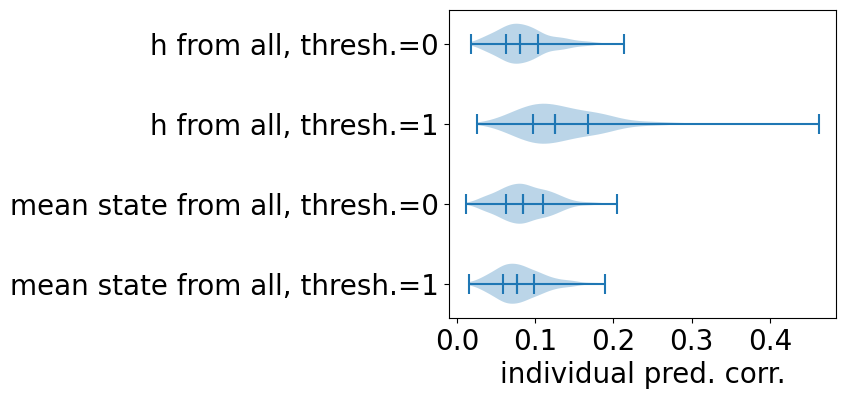

In [149]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['h from all, thresh.=0', 'h from all, thresh.=1', 'mean state from all, thresh.=0', 'mean state from all, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
# all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(h_node_feature_corr_tensor[:,feature_index]) for feature_index in range( h_node_feature_corr_tensor.size(dim=-1) )] + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
all_corrs = [depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_0), depytorch(lstsq_corr_all_mean_state_1)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('individual pred. corr.')
plt.show()

In [169]:
p_lstsq_corr_all_h_0 = torch.load( os.path.join(file_dir, 'p_value_lstsq_corr_all_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=False )
print( p_lstsq_corr_all_h_0.size() )
p_lstsq_corr_all_h_1 = torch.load( os.path.join(file_dir, 'p_value_lstsq_corr_all_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=False )
print( p_lstsq_corr_all_h_1.size() )
p_lstsq_corr_all_mean_state_0 = torch.load( os.path.join(file_dir, 'p_value_lstsq_corr_all_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=False )
print( p_lstsq_corr_all_mean_state_0.size() )
p_lstsq_corr_all_mean_state_1 = torch.load( os.path.join(file_dir, 'p_value_lstsq_corr_all_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=False )
print( p_lstsq_corr_all_mean_state_1.size() )

torch.Size([360])
torch.Size([360])
torch.Size([360])
torch.Size([360])


In [170]:
num_nodes = p_lstsq_corr_all_h_0.numel()
alpha = 0.05/num_nodes
print( alpha )
print( torch.count_nonzero(p_lstsq_corr_all_h_0 < alpha) )
print( torch.count_nonzero(p_lstsq_corr_all_h_1 < alpha) )
print( torch.count_nonzero(p_lstsq_corr_all_mean_state_0 < alpha) )
print( torch.count_nonzero(p_lstsq_corr_all_mean_state_1 < alpha) )

0.0001388888888888889
tensor(12, device='cuda:0')
tensor(96, device='cuda:0')
tensor(9, device='cuda:0')
tensor(5, device='cuda:0')


In [84]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_mean_state_0), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(30544.0), pvalue=np.float64(0.8376543992722232))


In [85]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_all_mean_state_1), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(58714.0), pvalue=np.float64(1.6853471971717013e-40))


In [86]:
crit_corr_SC_J_1 = torch.load( f=os.path.join(file_dir, 'crit_value_corr_SC_J_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_SC_J_1.size() )
print_stats(name='SC-J(1) corr. crit. val.', values=crit_corr_SC_J_1)

torch.Size([64620])
The distribution of SC-J(1) corr. crit. val. values has median 0.139 with 95% CI [0.124, 0.167] and range [0.105, 0.255].


In [87]:
crit_corr_SC_FC_1 = torch.load( f=os.path.join(file_dir, 'crit_value_corr_SC_FC_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_SC_FC_1.size() )
print_stats(name='SC-FC(1) corr. crit. val.', values=crit_corr_SC_FC_1)

torch.Size([64620])
The distribution of SC-FC(1) corr. crit. val. values has median 0.14 with 95% CI [0.124, 0.167] and range [0.0974, 0.237].


In [88]:
crit_corr_SC_J_0 = torch.load( f=os.path.join(file_dir, 'crit_value_corr_SC_J_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_SC_J_0.size() )
print_stats(name='SC-J(0) corr. crit. val.', values=crit_corr_SC_J_0)

torch.Size([64620])
The distribution of SC-J(0) corr. crit. val. values has median 0.138 with 95% CI [0.123, 0.165] and range [0.109, 0.234].


In [89]:
crit_corr_SC_FC_0 = torch.load( f=os.path.join(file_dir, 'crit_value_corr_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_SC_FC_0.size() )
print_stats(name='SC-FC(0) corr. crit. val.', values=crit_corr_SC_FC_0)

torch.Size([64620])
The distribution of SC-FC(0) corr. crit. val. values has median 0.138 with 95% CI [0.122, 0.163] and range [0.0937, 0.215].


In [90]:
p_value_SC_J_1 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_J_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_SC_J_1.size() )

torch.Size([64620])


In [91]:
p_value_SC_FC_1 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_FC_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_SC_FC_1.size() )

torch.Size([64620])


In [92]:
p_value_SC_J_0 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_J_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_SC_J_0.size() )

torch.Size([64620])


In [93]:
p_value_SC_FC_0 = torch.load( f=os.path.join(file_dir, 'p_value_corr_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_20000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_SC_FC_0.size() )

torch.Size([64620])


In [94]:
num_edges = p_value_SC_J_1.size(dim=-1)
alpha = 0.05/num_edges
print(f'edge correlation alpha={alpha:.3g}')

edge correlation alpha=7.74e-07


In [95]:
is_sig_SC_J_1 = p_value_SC_J_1 < alpha
print(f'num significant SC-J(1) correlations {torch.count_nonzero(is_sig_SC_J_1)}')
is_sig_SC_FC_1 = p_value_SC_FC_1 < alpha
print(f'num significant SC-FC(1) correlations {torch.count_nonzero(is_sig_SC_FC_1)}')
is_sig_SC_J_0 = p_value_SC_J_0 < alpha
print(f'num significant SC-J(0) correlations {torch.count_nonzero(is_sig_SC_J_0)}')
is_sig_SC_FC_0 = p_value_SC_FC_0 < alpha
print(f'num significant SC-FC(0) correlations {torch.count_nonzero(is_sig_SC_FC_0)}')

num significant SC-J(1) correlations 495
num significant SC-FC(1) correlations 310
num significant SC-J(0) correlations 602
num significant SC-FC(0) correlations 360


In [96]:
is_sig_SC_J_and_FC_1 = torch.logical_and(is_sig_SC_J_1, is_sig_SC_FC_1)
print(f'num edges with both SC-J(1) and SC-FC(1) correlations significant {torch.count_nonzero(is_sig_SC_J_and_FC_1)}')
is_sig_SC_J_and_FC_0 = torch.logical_and(is_sig_SC_J_0, is_sig_SC_FC_0)
print(f'num edges with both SC-J(0) and SC-FC(0) correlations significant {torch.count_nonzero(is_sig_SC_J_and_FC_0)}')

num edges with both SC-J(1) and SC-FC(1) correlations significant 207
num edges with both SC-J(0) and SC-FC(0) correlations significant 227


In [97]:
both_sig_abs_SC_J_1 = corr_SC_J_1_abs[is_sig_SC_J_and_FC_1]
print(f'median abs SC-J(1) correlation at double-signicant edge {both_sig_abs_SC_J_1.median():.3g}')
both_sig_abs_SC_FC_1 = corr_SC_FC_1_abs[is_sig_SC_J_and_FC_1]
print(f'median abs SC-FC(1) correlation at double-signicant edge {both_sig_abs_SC_FC_1.median():.3g}')
both_sig_abs_SC_J_0 = corr_SC_J_0_abs[is_sig_SC_J_and_FC_0]
print(f'median abs SC-J(0) correlation at double-signicant edge {both_sig_abs_SC_J_0.median():.3g}')
both_sig_abs_SC_FC_0 = corr_SC_FC_0_abs[is_sig_SC_J_and_FC_0]
print(f'median abs SC-FC(0) correlation at double-signicant edge {both_sig_abs_SC_FC_0.median():.3g}')

median abs SC-J(1) correlation at double-signicant edge 0.191
median abs SC-FC(1) correlation at double-signicant edge 0.164
median abs SC-J(0) correlation at double-signicant edge 0.208
median abs SC-FC(0) correlation at double-signicant edge 0.168


In [98]:
print(  stats.wilcoxon(  depytorch(both_sig_abs_SC_J_1), depytorch(both_sig_abs_SC_FC_1), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(19261.0), pvalue=np.float64(3.510050232492423e-23))


In [99]:
print(  stats.wilcoxon(  depytorch(both_sig_abs_SC_J_0), depytorch(both_sig_abs_SC_FC_0), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(24031.0), pvalue=np.float64(2.0919161000790926e-29))


In [159]:
crit_corr_all_h_1 = torch.load( f=os.path.join(file_dir, 'crit_value_lstsq_corr_all_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_all_h_1.size() )
print_stats(name='all-h(1) crit. corr.', values=crit_corr_all_h_1)

torch.Size([360])
The distribution of all-h(1) crit. corr. values has median 0.164 with 95% CI [0.163, 0.166] and range [0.162, 0.189].


In [160]:
crit_corr_all_mean_1 = torch.load( f=os.path.join(file_dir, 'crit_value_lstsq_corr_all_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_all_mean_1.size() )
print_stats(name='all-mean(1) crit. corr.', values=crit_corr_all_mean_1)

torch.Size([360])
The distribution of all-mean(1) crit. corr. values has median 0.164 with 95% CI [0.163, 0.169] and range [0.162, 0.255].


In [161]:
crit_corr_all_h_0 = torch.load( f=os.path.join(file_dir, 'crit_value_lstsq_corr_all_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_all_h_0.size() )
print_stats(name='all-h(0) crit. corr.', values=crit_corr_all_h_0)

torch.Size([360])
The distribution of all-h(0) crit. corr. values has median 0.164 with 95% CI [0.163, 0.166] and range [0.162, 0.168].


In [162]:
crit_corr_all_mean_0 = torch.load( f=os.path.join(file_dir, 'crit_value_lstsq_corr_all_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( crit_corr_all_mean_0.size() )
print_stats(name='all-mean(0) crit. corr.', values=crit_corr_all_mean_0)

torch.Size([360])
The distribution of all-mean(0) crit. corr. values has median 0.164 with 95% CI [0.163, 0.166] and range [0.162, 0.169].


In [163]:
p_value_all_h_1 = torch.load( f=os.path.join(file_dir, 'p_value_lstsq_corr_all_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_all_h_1.size() )
print_stats(name='all-h(1) corr. p-value', values=p_value_all_h_1)

torch.Size([360])
The distribution of all-h(1) corr. p-value values has median 0.0104 with 95% CI [0, 0.607] and range [0, 0.969].


In [164]:
p_value_all_mean_1 = torch.load( f=os.path.join(file_dir, 'p_value_lstsq_corr_all_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_all_mean_1.size() )
print_stats(name='all-mean(1) corr. p-value', values=p_value_all_mean_1)

torch.Size([360])
The distribution of all-mean(1) corr. p-value values has median 0.283 with 95% CI [0.00044, 0.935] and range [6e-06, 0.989].


In [165]:
p_value_all_h_0 = torch.load( f=os.path.join(file_dir, 'p_value_lstsq_corr_all_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_all_h_0.size() )
print_stats(name='all-h(0) corr. p-value', values=p_value_all_h_0)

torch.Size([360])
The distribution of all-h(0) corr. p-value values has median 0.239 with 95% CI [9.29e-05, 0.921] and range [0, 0.991].


In [166]:
p_value_all_mean_0 = torch.load( f=os.path.join(file_dir, 'p_value_lstsq_corr_all_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True ).squeeze(dim=0)
print( p_value_all_mean_0.size() )
print_stats(name='all-mean(0) corr. p-value', values=p_value_all_mean_0)

torch.Size([360])
The distribution of all-mean(0) corr. p-value values has median 0.205 with 95% CI [0.000196, 0.935] and range [0, 0.998].


In [167]:
num_nodes = p_value_all_h_1.size(dim=-1)
alpha_node = 0.05/num_nodes
print(f'node correlation alpha={alpha_node:.3g}')

node correlation alpha=0.000139


In [168]:
is_sig_all_h_1 = p_value_all_h_1 < alpha_node
print(f'num significant all-h(1) correlations {torch.count_nonzero(is_sig_all_h_1)}')
is_sig_all_mean_1 = p_value_all_mean_1 < alpha_node
print(f'num significant all-mean(1) correlations {torch.count_nonzero(is_sig_all_mean_1)}')
is_sig_all_h_0 = p_value_all_h_0 < alpha_node
print(f'num significant all-h(0) correlations {torch.count_nonzero(is_sig_all_h_0)}')
is_sig_all_mean_0 = p_value_all_mean_0 < alpha_node
print(f'num significant all-mean(0) correlations {torch.count_nonzero(is_sig_all_mean_0)}')

num significant all-h(1) correlations 96
num significant all-mean(1) correlations 5
num significant all-h(0) correlations 12
num significant all-mean(0) correlations 9


In [169]:
is_sig_all_h_and_mean_1 = torch.logical_and(is_sig_all_h_1, is_sig_all_mean_1)
print(f'num nodes with both all-h(1) and all-mean(1) correlations significant {torch.count_nonzero(is_sig_all_h_and_mean_1)}')
is_sig_all_h_and_mean_0 = torch.logical_and(is_sig_all_h_0, is_sig_all_mean_0)
print(f'num nodes with both all-h(0) and all-mean(0) correlations significant {torch.count_nonzero(is_sig_all_h_and_mean_0)}')

num nodes with both all-h(1) and all-mean(1) correlations significant 2
num nodes with both all-h(0) and all-mean(0) correlations significant 7


In [170]:
both_sig_all_h_1 = lstsq_corr_all_h_1[is_sig_all_h_and_mean_1]
print( f'all-h(1) correlations at double-signicant nodes ', both_sig_all_h_1.tolist() )
both_sig_all_mean_1 = lstsq_corr_all_mean_state_1[is_sig_all_h_and_mean_1]
print( f'all-mean(1) correlations at double-signicant nodes ', both_sig_all_mean_1.tolist() )
both_sig_all_h_0 = lstsq_corr_all_h_0[is_sig_all_h_and_mean_0]
print( f'all-h(0) correlations at double-signicant nodes ', both_sig_all_h_0.tolist() )
both_sig_all_mean_0 = lstsq_corr_all_mean_state_0[is_sig_all_h_and_mean_0]
print( f'all-mean(0) correlations at double-signicant nodes ', both_sig_all_mean_0.tolist() )

all-h(1) correlations at double-signicant nodes  [0.24317781627178192, 0.21444553136825562]
all-mean(1) correlations at double-signicant nodes  [0.17414557933807373, 0.1888543665409088]
all-h(0) correlations at double-signicant nodes  [0.1675787717103958, 0.1901436150074005, 0.16672129929065704, 0.17134705185890198, 0.21065551042556763, 0.16542167961597443, 0.176320880651474]
all-mean(0) correlations at double-signicant nodes  [0.16615109145641327, 0.17319101095199585, 0.1673012524843216, 0.17198002338409424, 0.19175000488758087, 0.16417169570922852, 0.1758691370487213]


In [171]:
lstsq_corr_thickness_h_1 = torch.load( os.path.join(file_dir, 'lstsq_corr_thickness_h_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( lstsq_corr_thickness_h_1.size() )
lstsq_corr_myelination_h_1 = torch.load( os.path.join(file_dir, 'lstsq_corr_myelination_h_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( lstsq_corr_myelination_h_1.size() )
lstsq_corr_curvature_h_1 = torch.load( os.path.join(file_dir, 'lstsq_corr_curvature_h_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( lstsq_corr_curvature_h_1.size() )
lstsq_corr_sulcus_depth_h_1 = torch.load( os.path.join(file_dir, 'lstsq_corr_sulcus_depth_h_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( lstsq_corr_curvature_h_1.size() )

torch.Size([360])
torch.Size([360])
torch.Size([360])
torch.Size([360])


In [172]:
def print_range(vals:torch.Tensor):
    print( vals.min().item(), vals.median().item(), vals.max().item() )
print_range( lstsq_corr_thickness_h_1 )
print_range( lstsq_corr_myelination_h_1 )
print_range( lstsq_corr_curvature_h_1 )
print_range( lstsq_corr_sulcus_depth_h_1 )
print_range( lstsq_corr_all_h_1 )

0.0010190213797613978 0.04793845862150192 0.17866230010986328
-0.0006011640070937574 0.04358377680182457 0.43030792474746704
0.0 0.05960753187537193 0.4080893397331238
0.000602139625698328 0.05560022592544556 0.3751738667488098
0.02561304345726967 0.12505768239498138 0.4623930752277374


In [173]:
print_range( lstsq_corr_all_h_1 - lstsq_corr_thickness_h_1 )
print_range( lstsq_corr_all_h_1 - lstsq_corr_myelination_h_1 )
print_range( lstsq_corr_all_h_1 - lstsq_corr_curvature_h_1 )
print_range( lstsq_corr_all_h_1 - lstsq_corr_sulcus_depth_h_1 )

0.0014276131987571716 0.07553242892026901 0.39183732867240906
0.0012630447745323181 0.07480204850435257 0.3521461486816406
0.001217968761920929 0.05097121000289917 0.30098956823349
0.00043530017137527466 0.05813111364841461 0.31877291202545166


In [174]:
print_range( lstsq_corr_all_h_1 / lstsq_corr_thickness_h_1 )
print_range( lstsq_corr_all_h_1 / lstsq_corr_myelination_h_1 )
print_range( lstsq_corr_all_h_1 / lstsq_corr_curvature_h_1 )
print_range( lstsq_corr_all_h_1 / lstsq_corr_sulcus_depth_h_1 )

1.0123322010040283 2.4801862239837646 185.6311492919922
-200.78610229492188 2.5630099773406982 309.2776184082031
1.010425090789795 1.823357343673706 inf
1.003705620765686 2.097625970840454 521.1806640625


In [175]:
print_range( lstsq_corr_thickness_h_1 / lstsq_corr_all_h_1 )
print_range( lstsq_corr_myelination_h_1 / lstsq_corr_all_h_1 )
print_range( lstsq_corr_curvature_h_1 / lstsq_corr_all_h_1 )
print_range( lstsq_corr_sulcus_depth_h_1 / lstsq_corr_all_h_1 )

0.005387027282267809 0.39850953221321106 0.9878180027008057
-0.004980424419045448 0.38028573989868164 0.9800899028778076
0.0 0.5439746379852295 0.9896824955940247
0.0019187205471098423 0.4758242964744568 0.9963080883026123


In [176]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_thickness_h_1), alternative='greater' )  )
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_myelination_h_1), alternative='greater' )  )
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_curvature_h_1), alternative='greater' )  )
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_1), depytorch(lstsq_corr_sulcus_depth_h_1), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61))
WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61))
WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61))
WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61))


In [177]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_curvature_h_1), depytorch(lstsq_corr_thickness_h_1), alternative='greater' )  )
print(  stats.wilcoxon(  depytorch(lstsq_corr_curvature_h_1), depytorch(lstsq_corr_myelination_h_1), alternative='greater' )  )
print(  stats.wilcoxon(  depytorch(lstsq_corr_curvature_h_1), depytorch(lstsq_corr_sulcus_depth_h_1), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(43971.0), pvalue=np.float64(3.1144887855466683e-09))
WilcoxonResult(statistic=np.float64(42638.0), pvalue=np.float64(1.4042464225412644e-07))
WilcoxonResult(statistic=np.float64(38418.0), pvalue=np.float64(0.001349283492919275))


In [178]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_sulcus_depth_h_1), depytorch(lstsq_corr_thickness_h_1), alternative='greater' )  )
print(  stats.wilcoxon(  depytorch(lstsq_corr_sulcus_depth_h_1), depytorch(lstsq_corr_myelination_h_1), alternative='greater' )  )
print(  stats.wilcoxon(  depytorch(lstsq_corr_sulcus_depth_h_1), depytorch(lstsq_corr_curvature_h_1), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(40461.0), pvalue=np.float64(2.7406759898812113e-05))
WilcoxonResult(statistic=np.float64(39814.0), pvalue=np.float64(0.00010500981218207742))
WilcoxonResult(statistic=np.float64(26562.0), pvalue=np.float64(0.9986507165070807))


In [181]:
corr_curvature_gt_thickness = lstsq_corr_curvature_h_1 > lstsq_corr_thickness_h_1
print( torch.count_nonzero(corr_curvature_gt_thickness).item() )
corr_curvature_gt_myelination = lstsq_corr_curvature_h_1 > lstsq_corr_myelination_h_1
print( torch.count_nonzero(corr_curvature_gt_myelination).item() )
corr_curvature_gt_sulcus_depth = lstsq_corr_curvature_h_1 > lstsq_corr_sulcus_depth_h_1
print( torch.count_nonzero(corr_curvature_gt_sulcus_depth).item() )

227
226
212


In [186]:
p_value_corr_thickness_h_1 = torch.load( os.path.join(file_dir, 'p_value_corr_thickness_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=False )
print( p_value_corr_thickness_h_1.size() )
p_value_corr_myelination_h_1 = torch.load( os.path.join(file_dir, 'p_value_corr_myelination_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=False )
print( p_value_corr_myelination_h_1.size() )
p_value_corr_curvature_h_1 = torch.load( os.path.join(file_dir, 'p_value_corr_curvature_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=False )
print( p_value_corr_curvature_h_1.size() )
p_value_corr_sulcus_depth_h_1 = torch.load( os.path.join(file_dir, 'p_value_corr_sulcus_depth_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=False )
print( p_value_corr_curvature_h_1.size() )

torch.Size([360])
torch.Size([360])
torch.Size([360])
torch.Size([360])


In [187]:
alpha = 0.05/p_value_corr_thickness_h_1.numel()
print( torch.count_nonzero(p_value_corr_thickness_h_1 < alpha) )
print( torch.count_nonzero(p_value_corr_myelination_h_1 < alpha) )
print( torch.count_nonzero(p_value_corr_curvature_h_1 < alpha) )
print( torch.count_nonzero(p_value_corr_sulcus_depth_h_1 < alpha) )

tensor(18, device='cuda:0')
tensor(23, device='cuda:0')
tensor(54, device='cuda:0')
tensor(43, device='cuda:0')


In [189]:
feature_corr_list = [lstsq_corr_thickness_h_1, lstsq_corr_myelination_h_1, lstsq_corr_curvature_h_1, lstsq_corr_sulcus_depth_h_1]
for more_feature_corr in feature_corr_list:
    print([ torch.count_nonzero(more_feature_corr > less_feature_corr).item() for less_feature_corr in feature_corr_list])

[0, 188, 133, 152]
[172, 0, 134, 152]
[227, 226, 0, 212]
[208, 208, 148, 0]


In [193]:
lstsq_corr_features_h_1_stack = torch.stack(feature_corr_list, dim=0)
print( lstsq_corr_features_h_1_stack.size() )
lstsq_corr_sorted, lstsq_corr_sort_index = torch.sort(lstsq_corr_features_h_1_stack, dim=0, descending=True)
lstsq_corr_first_index = lstsq_corr_sort_index[0,:]
lstsq_corr_num_first = [ torch.count_nonzero(feature_index == lstsq_corr_first_index).item() for feature_index in range( len(feature_corr_list) ) ]
print(lstsq_corr_num_first)

torch.Size([4, 360])
[90, 75, 124, 71]


In [190]:
for more_feature_corr in feature_corr_list:
    print([ torch.mean(more_feature_corr - less_feature_corr).item() for less_feature_corr in feature_corr_list])

[0.0, -0.003911339212208986, -0.021610338240861893, -0.016420794650912285]
[0.003911339212208986, 0.0, -0.017699001356959343, -0.012509455904364586]
[0.021610338240861893, 0.017699001356959343, 0.0, 0.0051895445212721825]
[0.016420794650912285, 0.012509455904364586, -0.0051895445212721825, 0.0]


In [182]:
print(   torch.count_nonzero(  torch.logical_and( torch.logical_and(corr_curvature_gt_thickness, corr_curvature_gt_myelination), corr_curvature_gt_sulcus_depth )  ).item()   )

124


In [112]:
perm_lstsq_corr_all_mean_state_1 = torch.load( os.path.join(file_dir, 'perm_lstsq_corr_all_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000_v2.pt'), weights_only=False )
print( perm_lstsq_corr_all_mean_state_1.size() )

torch.Size([360, 1000000])


In [113]:
num_perms = perm_lstsq_corr_all_mean_state_1.size(dim=-1)
lstsq_corr_all_mean_state_1_p_value = torch.count_nonzero( perm_lstsq_corr_all_mean_state_1 >= lstsq_corr_all_mean_state_1.unsqueeze(dim=-1), dim=-1 )/num_perms
print( lstsq_corr_all_mean_state_1_p_value.min().item(), lstsq_corr_all_mean_state_1_p_value.median().item(), lstsq_corr_all_mean_state_1_p_value.max().item() )

3.000000106112566e-06 0.2823989987373352 0.9893069863319397


In [114]:
num_regions = perm_lstsq_corr_all_mean_state_1.size(dim=0)
alpha = 0.05/num_regions
print( torch.count_nonzero(lstsq_corr_all_mean_state_1_p_value < alpha)/lstsq_corr_all_mean_state_1_p_value.numel() )

tensor(0.0139, device='cuda:0')


In [115]:
lstsq_corr_train_all_mean_state_1  = torch.load( f=os.path.join(file_dir, 'lstsq_corr_train_all_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_train_all_mean_state_1 .size() )

torch.Size([360, 1000000])


In [116]:
lstsq_corr_test_all_mean_state_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_test_all_mean_state_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_train_all_mean_state_1.size() )

torch.Size([360, 1000000])


In [117]:
print( torch.count_nonzero(lstsq_corr_train_all_mean_state_1 > lstsq_corr_test_all_mean_state_1)/torch.numel(lstsq_corr_test_all_mean_state_1) )

tensor(0.6844, device='cuda:0')


In [17]:
lstsq_corr_train_all_h_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_train_all_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_train_all_h_1.size() )

torch.Size([360, 1000000])


In [18]:
lstsq_corr_test_all_h_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_test_all_h_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_test_all_h_1.size() )

torch.Size([360, 1000000])


In [19]:
print( torch.count_nonzero(lstsq_corr_train_all_h_1 > lstsq_corr_test_all_h_1)/torch.numel(lstsq_corr_test_all_h_1) )

tensor(0.6150, device='cuda:0')


In [20]:
lstsq_corr_train_all_mean_state_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_train_all_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_train_all_mean_state_0.size() )

torch.Size([360, 1000000])


In [21]:
lstsq_corr_test_all_mean_state_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_test_all_mean_state_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_train_all_mean_state_0.size() )

torch.Size([360, 1000000])


In [22]:
print( torch.count_nonzero(lstsq_corr_train_all_mean_state_0 > lstsq_corr_test_all_mean_state_0)/torch.numel(lstsq_corr_test_all_mean_state_0) )

tensor(0.6725, device='cuda:0')


In [23]:
lstsq_corr_train_all_h_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_train_all_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_train_all_h_0.size() )

torch.Size([360, 1000000])


In [24]:
lstsq_corr_test_all_h_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_test_all_h_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_1000000.pt'), weights_only=True )
print( lstsq_corr_train_all_h_0.size() )

torch.Size([360, 1000000])


In [25]:
print( torch.count_nonzero(lstsq_corr_train_all_h_0 > lstsq_corr_test_all_h_0)/torch.numel(lstsq_corr_test_all_h_0) )

tensor(0.6744, device='cuda:0')


In [26]:
lstsq_corr_train_all_mean_state_1_mean = lstsq_corr_train_all_mean_state_1.mean(dim=-1)
lstsq_corr_test_all_mean_state_1_mean = lstsq_corr_test_all_mean_state_1.mean(dim=-1)
lstsq_corr_train_all_h_1_mean = lstsq_corr_train_all_h_1.mean(dim=-1)
lstsq_corr_test_all_h_1_mean = lstsq_corr_test_all_h_1.mean(dim=-1)
lstsq_corr_train_all_mean_state_0_mean = lstsq_corr_train_all_mean_state_0.mean(dim=-1)
lstsq_corr_test_all_mean_state_0_mean = lstsq_corr_test_all_mean_state_0.mean(dim=-1)
lstsq_corr_train_all_h_0_mean = lstsq_corr_train_all_h_0.mean(dim=-1)
lstsq_corr_test_all_h_0_mean = lstsq_corr_test_all_h_0.mean(dim=-1)

In [17]:
model_1_str = 'ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000'
lstsq_corr_train_all_mean_state_1_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_train_all_mean_state_{model_1_str}_perms_1000000.pt'), weights_only=False )
lstsq_corr_test_all_mean_state_1_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_test_all_mean_state_{model_1_str}_perms_1000000.pt'), weights_only=False )
lstsq_corr_train_all_h_1_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_train_all_h_{model_1_str}_perms_1000000.pt'), weights_only=False )
lstsq_corr_test_all_h_1_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_test_all_h_{model_1_str}_perms_1000000.pt'), weights_only=False )
model_0_str = 'ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000'
lstsq_corr_train_all_mean_state_0_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_train_all_mean_state_{model_0_str}_perms_1000000.pt'), weights_only=False )
lstsq_corr_test_all_mean_state_0_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_test_all_mean_state_{model_0_str}_perms_1000000.pt'), weights_only=False )
lstsq_corr_train_all_h_0_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_train_all_h_{model_0_str}_perms_1000000.pt'), weights_only=False )
lstsq_corr_test_all_h_0_mean = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_test_all_h_{model_0_str}_perms_1000000.pt'), weights_only=False )

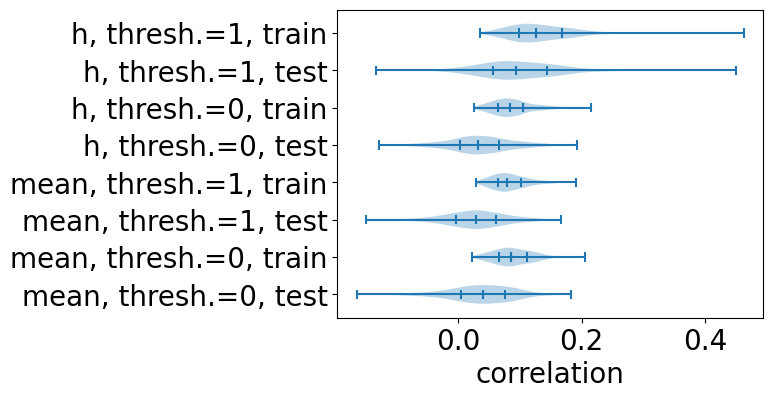

In [18]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 4) )
corr_labels = ['h, thresh.=1, train', 'h, thresh.=1, test', 'h, thresh.=0, train', 'h, thresh.=0, test', 'mean, thresh.=1, train', 'mean, thresh.=1, test', 'mean, thresh.=0, train', 'mean, thresh.=0, test']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(lstsq_corr_train_all_h_1_mean), depytorch(lstsq_corr_test_all_h_1_mean), depytorch(lstsq_corr_train_all_h_0_mean), depytorch(lstsq_corr_test_all_h_0_mean), depytorch(lstsq_corr_train_all_mean_state_1_mean), depytorch(lstsq_corr_test_all_mean_state_1_mean), depytorch(lstsq_corr_train_all_mean_state_0_mean), depytorch(lstsq_corr_test_all_mean_state_0_mean)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('correlation')
plt.show()

In [19]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_train_all_h_1_mean), depytorch(lstsq_corr_test_all_h_1_mean), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(64980.0), pvalue=np.float64(4.7017897367405964e-61))


In [20]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_test_all_h_1_mean), depytorch(lstsq_corr_test_all_h_0_mean), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(57088.0), pvalue=np.float64(7.084312145975301e-36))


In [21]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_test_all_h_1_mean), depytorch(lstsq_corr_test_all_mean_state_1_mean), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(58516.0), pvalue=np.float64(6.387739661237391e-40))


In [22]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_test_all_h_1_mean), depytorch(lstsq_corr_test_all_mean_state_0_mean), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(55821.0), pvalue=np.float64(1.7801775558757388e-32))


In [32]:
cross_val_lim = [-0.21, 0.48]
cross_val_ticks = np.arange(-0.2, 0.45, 0.2)

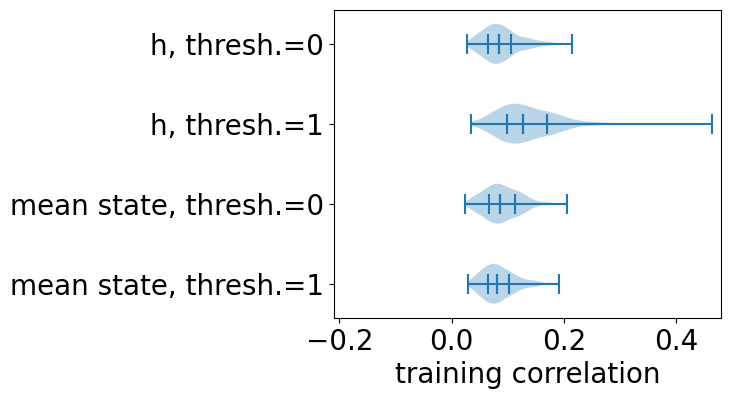

In [33]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(lstsq_corr_train_all_h_0_mean), depytorch(lstsq_corr_train_all_h_1_mean), depytorch(lstsq_corr_train_all_mean_state_0_mean), depytorch(lstsq_corr_train_all_mean_state_1_mean)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_xlim(cross_val_lim)
axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

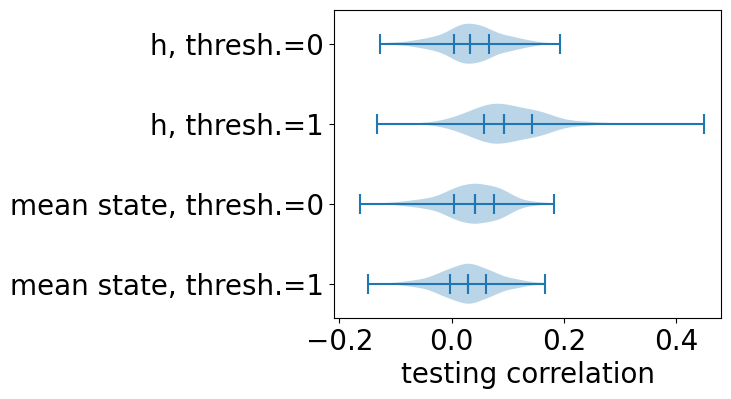

In [34]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [depytorch(lstsq_corr_test_all_h_0_mean), depytorch(lstsq_corr_test_all_h_1_mean), depytorch(lstsq_corr_test_all_mean_state_0_mean), depytorch(lstsq_corr_test_all_mean_state_1_mean)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_xlim(cross_val_lim)
axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

In [43]:
model_1_str = 'light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000'
lstsq_corr_train_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_SC_FC_{model_1_str}_perms_1000.pt'), weights_only=False )
print( lstsq_corr_train_sc_fc_1.size() )
lstsq_corr_test_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_SC_FC_{model_1_str}_perms_1000.pt'), weights_only=False )
print( lstsq_corr_test_sc_fc_1.size() )
lstsq_corr_train_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_SC_J_{model_1_str}_perms_1000.pt'), weights_only=False )
print( lstsq_corr_train_sc_J_1.size() )
lstsq_corr_test_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_SC_J_{model_1_str}_perms_1000.pt'), weights_only=False )
print( lstsq_corr_test_sc_J_1.size() )
# model_0_str = 'ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000'
# lstsq_corr_train_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_SC_FC_{model_0_str}_perms_1000.pt'), weights_only=False )
# print( lstsq_corr_train_sc_fc_0.size() )
# lstsq_corr_test_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_SC_FC_{model_0_str}_perms_1000.pt'), weights_only=False )
# print( lstsq_corr_test_sc_fc_0.size() )

torch.Size([64620, 1000])
torch.Size([64620, 1000])
torch.Size([64620, 1000])
torch.Size([64620, 1000])


In [42]:
model_0_str = 'ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000'
mean_lstsq_corr_train_sc_J_0 = torch.load( os.path.join(file_dir,f'mean_lstsq_corr_train_SC_J_{model_0_str}_perms_1000.pt'), weights_only=False )
print( mean_lstsq_corr_train_sc_J_0.size() )

torch.Size([64620])


In [ ]:
# model_1_str = 'ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000'
lstsq_corr_train_sc_fc_1_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_train_sc_fc_{model_1_str}_perms_1000.pt'), weights_only=False )
lstsq_corr_test_sc_fc_1_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_test_sc_fc_{model_1_str}_perms_1000.pt'), weights_only=False )
lstsq_corr_train_sc_J_1_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_train_sc_J_{model_1_str}_perms_1000.pt'), weights_only=False )
lstsq_corr_test_sc_J_1_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_test_sc_J_{model_1_str}_perms_1000.pt'), weights_only=False )
# model_0_str = 'ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000'
lstsq_corr_train_sc_fc_0_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_train_sc_fc_{model_0_str}_perms_1000.pt'), weights_only=False )
lstsq_corr_test_sc_fc_0_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_test_sc_fc_{model_0_str}_perms_1000.pt'), weights_only=False )
lstsq_corr_train_sc_J_0_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_train_sc_J_{model_0_str}_perms_1000.pt'), weights_only=False )
lstsq_corr_test_sc_J_0_mean = torch.load( os.path.join(file_dir,f'lstsq_corr_test_sc_J_{model_0_str}_perms_1000.pt'), weights_only=False )

In [141]:
h = torch.load( os.path.join(other_file_dir,'light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).h
print( h.size() )

torch.Size([5, 837, 360])


In [142]:
h = h.mean(dim=0)

In [143]:
myelination = torch.load( os.path.join(file_dir, 'node_features_all_as_is.pt'), weights_only=False )[:,:,1]
print( myelination.size() )

torch.Size([837, 360])


In [144]:
myelination_mean = myelination.mean(dim=0)
h_std = h.std(dim=0)
mmhs_corr = isingmodellight.get_pairwise_correlation(myelination_mean, h_std)
print(mmhs_corr)

tensor(-0.5245, device='cuda:0')


In [22]:
mean_state_as_is = torch.load( os.path.join(file_dir, 'mean_state_all_as_is.pt'), weights_only=False ).mean(dim=0).transpose(dim0=0, dim1=1).unsqueeze(dim=-1)
print( mean_state_as_is.size() )

torch.Size([360, 837, 1])


In [23]:
region_features = torch.cat(   (  torch.load( os.path.join(file_dir, 'node_features_all_as_is.pt'), weights_only=False )[:,:,:4].transpose(dim0=0, dim1=1), torch.ones_like(mean_state_as_is)  ), dim=-1   )
print( region_features.size() )

torch.Size([360, 837, 5])


In [29]:
mean_state_pred = torch.matmul( region_features, torch.linalg.lstsq(region_features, mean_state_as_is).solution )# .transpose(dim0=0, dim1=1)
print( mean_state_pred.size(), count_non_nan(mean_state_pred) )

torch.Size([360, 837, 1]) 1.0


In [30]:
mean_state_pred_corr = isingmodellight.get_pairwise_correlation(mat1=mean_state_as_is, mat2=mean_state_pred, epsilon=0.0, dim=1)
print( mean_state_pred_corr.size(), count_non_nan(mean_state_pred_corr) )

torch.Size([360, 1]) 1.0


In [31]:
print( mean_state_pred_corr.min().item(), mean_state_pred_corr.median().item(), mean_state_pred_corr.max().item() )

0.026432430371642113 0.14457331597805023 0.35170894861221313


In [148]:
group_std_features, group_mean_features = torch.std_mean(region_features, dim=0)
num_features = len(feature_names)
for feature_a_index in range(num_features-1):
    feature_a_name = feature_names[feature_a_index]
    feature_a_mean = group_mean_features[:,feature_a_index]
    feature_a_std = group_std_features[:,feature_a_index]
    for feature_b_index in range(feature_a_index+1,num_features):
        feature_b_name = feature_names[feature_b_index]
        feature_b_mean = group_mean_features[:,feature_b_index]
        feature_b_std = group_std_features[:,feature_b_index]
        feature_mean_corr = isingmodellight.get_pairwise_correlation(mat1=feature_a_mean, mat2=feature_b_mean, dim=0, epsilon=0.0)
        feature_std_corr = isingmodellight.get_pairwise_correlation(mat1=feature_a_std, mat2=feature_b_std, dim=0, epsilon=0.0)
        print(f'{feature_a_name} v. {feature_b_name} correlation between group means {feature_mean_corr:.3g}, between group SDs {feature_std_corr:.3g}')

thickness v. myelination correlation between group means -0.547, between group SDs 0.373
thickness v. curvature correlation between group means 0.0927, between group SDs 0.102
thickness v. sulcus depth correlation between group means 0.0133, between group SDs -0.27
myelination v. curvature correlation between group means -0.106, between group SDs 0.00313
myelination v. sulcus depth correlation between group means -0.198, between group SDs -0.0617
curvature v. sulcus depth correlation between group means 0.864, between group SDs 0.71


In [118]:
corr_lstsq_h_region_feature_1 = torch.load( os.path.join(file_dir, 'lstsq_corr_all_h_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( corr_lstsq_h_region_feature_1.size(), count_non_nan(corr_lstsq_h_region_feature_1) )

torch.Size([360, 1]) 1.0


In [119]:
abs_corr_lstsq_h_region_feature_1 = corr_lstsq_h_region_feature_1.abs()
min_abs_corr = abs_corr_lstsq_h_region_feature_1.min()
median_abs_corr = abs_corr_lstsq_h_region_feature_1.median()
max_abs_corr = abs_corr_lstsq_h_region_feature_1.max()
print(f'The absolute value h at threshold 1 prediction correlations have min {min_abs_corr:.3g}, median {median_abs_corr:.3g}, max {max_abs_corr:.3g}.')

The absolute value h at threshold 1 prediction correlations have min 0.0256, median 0.125, max 0.462.


In [120]:
corr_lstsq_mean_state_region_feature_as_is = torch.load( os.path.join(file_dir, 'corr_lstsq_mean_state_region_feature_as_is.pt'), weights_only=False )
print( corr_lstsq_mean_state_region_feature_as_is.size(), count_non_nan(corr_lstsq_mean_state_region_feature_as_is) )

torch.Size([360, 1]) 1.0


In [121]:
abs_corr_lstsq_mean_state_region_feature_as_is = corr_lstsq_mean_state_region_feature_as_is.abs()
min_abs_corr = abs_corr_lstsq_mean_state_region_feature_as_is.min()
median_abs_corr = abs_corr_lstsq_mean_state_region_feature_as_is.median()
max_abs_corr = abs_corr_lstsq_mean_state_region_feature_as_is.max()
print(f'The absolute value unbinarized mean state prediction correlations have min {min_abs_corr:.3g}, median {median_abs_corr:.3g}, max {max_abs_corr:.3g}.')

The absolute value unbinarized mean state prediction correlations have min 0.0348, median 0.116, max 0.303.


In [122]:
num_thresholds = threshold.numel()
num_nodes = corr_lstsq_mean_state_region_feature_as_is.size(dim=0)
corr_lstsq_mean_state_region_feature_binarized = torch.zeros( (num_nodes, num_thresholds), dtype=corr_lstsq_mean_state_region_feature_as_is.dtype, device=corr_lstsq_mean_state_region_feature_as_is.device )
for threshold_index in range(num_thresholds):
    current_threshold = threshold[threshold_index]
    corr_lstsq_mean_state_region_feature_binarized[:,threshold_index] = torch.load( os.path.join(file_dir, f'corr_lstsq_mean_state_region_feature_thresh_{threshold[threshold_index]:.3g}.pt'), weights_only=False ).squeeze(dim=-1)
print( corr_lstsq_mean_state_region_feature_binarized.size(), count_non_nan(corr_lstsq_mean_state_region_feature_binarized) )

torch.Size([360, 31]) 0.9999999403953552


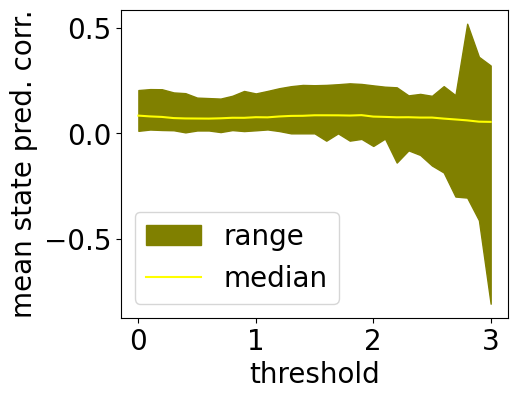

In [123]:
min_corr = torch.min(corr_lstsq_mean_state_region_feature_binarized, dim=0).values
median_corr = torch.median(corr_lstsq_mean_state_region_feature_binarized, dim=0).values
max_corr = torch.max(corr_lstsq_mean_state_region_feature_binarized, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
# ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('mean state pred. corr.')
# ax.set_xlim([0.0, 1.5])
ax.legend()

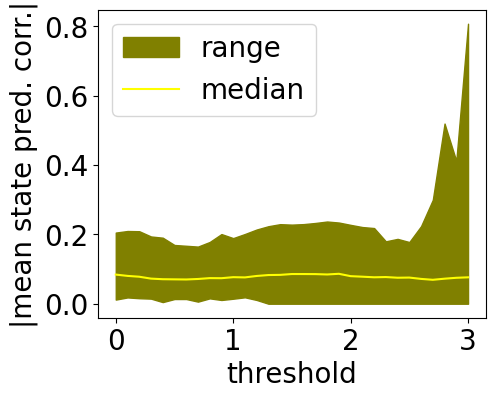

In [124]:
abs_corr_lstsq_mean_state_region_feature_binarized = corr_lstsq_mean_state_region_feature_binarized.abs()
min_abs_corr = torch.min(abs_corr_lstsq_mean_state_region_feature_binarized, dim=0).values
median_abs_corr = torch.median(abs_corr_lstsq_mean_state_region_feature_binarized, dim=0).values
max_abs_corr = torch.max(abs_corr_lstsq_mean_state_region_feature_binarized, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_abs_corr), depytorch(max_abs_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_abs_corr), color=[1.0, 1.0, 0.0], label='median' )
# ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('|mean state pred. corr.|')
# ax.set_xlim([0.0, 1.5])
ax.legend()

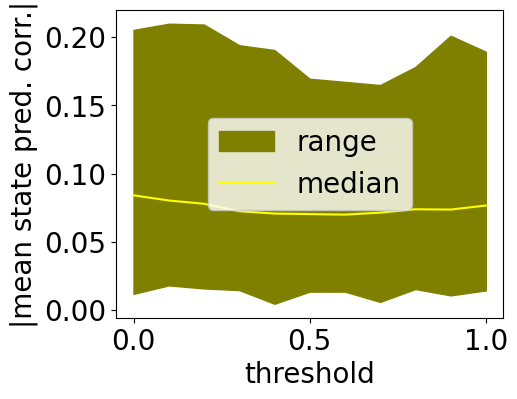

In [125]:
max_threshold = 1.0
max_thresh_index = get_closest_match(values=threshold, target=max_threshold) + 1
threshold_np = depytorch(threshold[:max_thresh_index])
abs_corr_lstsq_mean_state_region_feature_binarized = corr_lstsq_mean_state_region_feature_binarized[:,:max_thresh_index].abs()
min_abs_corr = torch.min(abs_corr_lstsq_mean_state_region_feature_binarized, dim=0).values
median_abs_corr = torch.median(abs_corr_lstsq_mean_state_region_feature_binarized, dim=0).values
max_abs_corr = torch.max(abs_corr_lstsq_mean_state_region_feature_binarized, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( threshold_np, depytorch(min_abs_corr), depytorch(max_abs_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( threshold_np, depytorch(median_abs_corr), color=[1.0, 1.0, 0.0], label='median' )
# ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('|mean state pred. corr.|')
# ax.set_xlim([0.0, 1.5])
ax.legend()

In [126]:
best_mean_state_corr_index = torch.argmax(median_abs_corr)
print(f'The best absolute value mean state prediction correlations occur at threshold {threshold[best_mean_state_corr_index]:.3g}, min {min_abs_corr[best_mean_state_corr_index]:.3g}, median {median_abs_corr[best_mean_state_corr_index]:.3g}, max {max_abs_corr[best_mean_state_corr_index]:.3g}.')

The best absolute value mean state prediction correlations occur at threshold 0, min 0.0119, median 0.0841, max 0.205.


In [127]:
corr_lstsq_mean_state_region_feature_as_is = torch.load( os.path.join(file_dir, 'corr_lstsq_mean_state_region_feature_as_is.pt'), weights_only=False ).squeeze(dim=-1)
print( corr_lstsq_mean_state_region_feature_as_is.size(), count_non_nan(corr_lstsq_mean_state_region_feature_as_is) )
abs_corr_lstsq_mean_state_region_feature_as_is = corr_lstsq_mean_state_region_feature_as_is.abs()
print(f'The absolute value unbinarized mean state prediction correlations have min {abs_corr_lstsq_mean_state_region_feature_as_is.min():.3g}, median {abs_corr_lstsq_mean_state_region_feature_as_is.median():.3g}, max {abs_corr_lstsq_mean_state_region_feature_as_is.max():.3g}.')

torch.Size([360]) 1.0
The absolute value unbinarized mean state prediction correlations have min 0.0348, median 0.116, max 0.303.


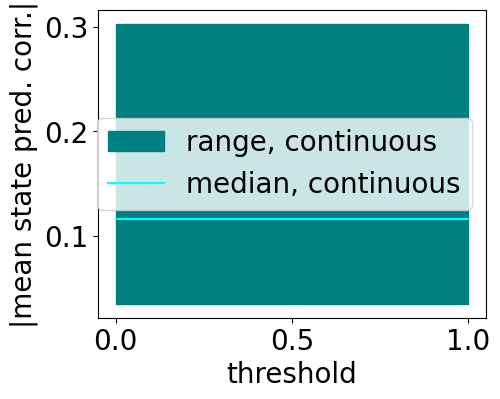

In [128]:
threshold_to_max = threshold[:max_thresh_index]
threshold_np = depytorch(threshold_to_max)
min_abs_corr = torch.full_like( input=threshold_to_max, fill_value=abs_corr_lstsq_mean_state_region_feature_as_is.min() )
median_abs_corr = torch.full_like( input=threshold_to_max, fill_value=abs_corr_lstsq_mean_state_region_feature_as_is.median() )
max_abs_corr = torch.full_like( input=threshold_to_max, fill_value=abs_corr_lstsq_mean_state_region_feature_as_is.max() )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( threshold_np, depytorch(min_abs_corr), depytorch(max_abs_corr), color=[0.0, 0.5, 0.5], label='range, continuous' )
ax.plot( threshold_np, depytorch(median_abs_corr), color=[0.0, 1.0, 1.0], label='median, continuous' )
# ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('|mean state pred. corr.|')
# ax.set_xlim([0.0, 1.5])
ax.legend()

In [129]:
# corr_mean_state_product_sc_as_is.pt
corr_mean_state_product_sc_as_is = torch.load( os.path.join(file_dir, 'corr_mean_state_product_sc_as_is.pt'), weights_only=False ).squeeze(dim=-1)
print( corr_mean_state_product_sc_as_is.size(), count_non_nan(corr_mean_state_product_sc_as_is) )
abs_corr_mean_state_product_sc_as_is = corr_mean_state_product_sc_as_is.abs()
print(f'The absolute value unbinarized mean state product v. SC correlations have min {abs_corr_mean_state_product_sc_as_is.min():.3g}, median {abs_corr_mean_state_product_sc_as_is.median():.3g}, max {abs_corr_mean_state_product_sc_as_is.max():.3g}.')

torch.Size([64620]) 1.0
The absolute value unbinarized mean state product v. SC correlations have min 8.41e-07, median 0.0337, max 0.278.


In [130]:
# corr_mean_state_product_sc_as_is.pt
corr_fc_sc_as_is = torch.load( os.path.join(file_dir, 'corr_fc_sc_as_is.pt'), weights_only=False ).squeeze(dim=-1)
print( corr_fc_sc_as_is.size(), count_non_nan(corr_fc_sc_as_is) )
abs_corr_fc_sc_as_is = corr_fc_sc_as_is.abs()
print(f'The absolute value unbinarized FC v. SC correlations have min {abs_corr_fc_sc_as_is.min():.3g}, median {abs_corr_fc_sc_as_is.median():.3g}, max {abs_corr_fc_sc_as_is.max():.3g}.')

torch.Size([64620]) 1.0
The absolute value unbinarized FC v. SC correlations have min 8.35e-07, median 0.0282, max 0.311.


In [131]:
num_thresholds = threshold.numel()
num_node_pairs = corr_fc_sc_as_is.size(dim=0)
corr_fc_sc_binarized = torch.zeros( (num_node_pairs, num_thresholds), dtype=corr_fc_sc_as_is.dtype, device=corr_fc_sc_as_is.device )
for threshold_index in range(num_thresholds):
    current_threshold = threshold[threshold_index]
    corr_fc_sc_binarized[:,threshold_index] = torch.load( os.path.join(file_dir, f'corr_fc_sc_thresh_{threshold[threshold_index]:.3g}.pt'), weights_only=False ).squeeze(dim=-1)
print( corr_fc_sc_binarized.size(), count_non_nan(corr_fc_sc_binarized) )

torch.Size([64620, 31]) 0.806648313999176


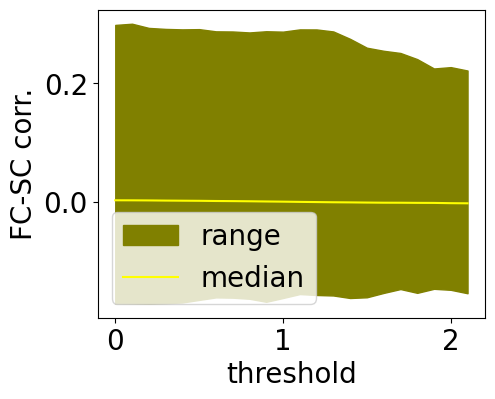

In [132]:
min_corr = torch.min(corr_fc_sc_binarized, dim=0).values
median_corr = torch.median(corr_fc_sc_binarized, dim=0).values
max_corr = torch.max(corr_fc_sc_binarized, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
# ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('FC-SC corr.')
# ax.set_xlim([0.0, 1.5])
ax.legend()

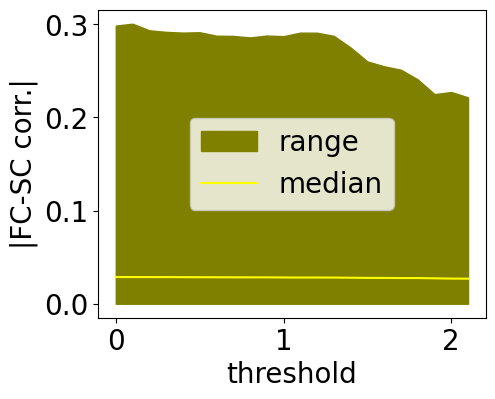

In [133]:
abs_corr_fc_sc_binarized = corr_fc_sc_binarized.abs()
min_abs_corr = torch.min(abs_corr_fc_sc_binarized, dim=0).values
median_abs_corr = torch.median(abs_corr_fc_sc_binarized, dim=0).values
max_abs_corr = torch.max(abs_corr_fc_sc_binarized, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_abs_corr), depytorch(max_abs_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_abs_corr), color=[1.0, 1.0, 0.0], label='median' )
# ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('|FC-SC corr.|')
# ax.set_xlim([0.0, 1.5])
ax.legend()

In [134]:
is_non_nan_median = torch.logical_not( torch.isnan(median_abs_corr) )
non_nan_min_abs_corr = min_abs_corr[is_non_nan_median]
non_nan_median_abs_corr = median_abs_corr[is_non_nan_median]
non_nan_max_abs_corr = max_abs_corr[is_non_nan_median]
non_nan_threshold = threshold[is_non_nan_median]
best_mean_state_corr_index = torch.argmax(non_nan_median_abs_corr)
print(f'The best absolute value FC-SC correlations occur at threshold {non_nan_threshold[best_mean_state_corr_index]:.3g}, min {non_nan_min_abs_corr[best_mean_state_corr_index]:.3g}, median {non_nan_median_abs_corr[best_mean_state_corr_index]:.3g}, max {non_nan_max_abs_corr[best_mean_state_corr_index]:.3g}.')

The best absolute value FC-SC correlations occur at threshold 0, min 6.08e-08, median 0.0286, max 0.299.


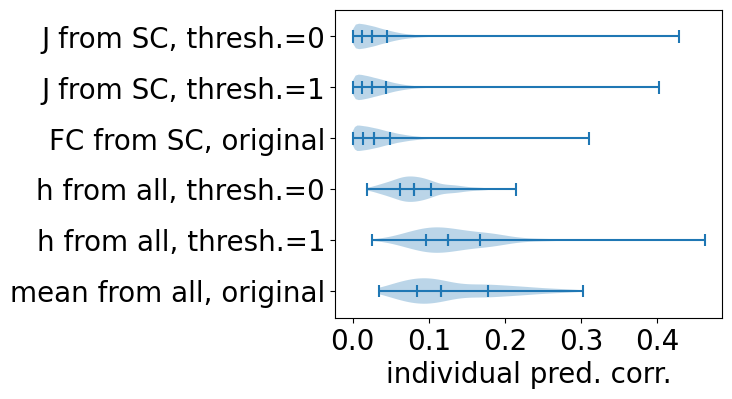

In [135]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
# corr_labels = ['h-predicted-h'] + ['h-thickness', 'h-myelination', 'h-curvature', 'h-sulcus depth'] + ['J-SC', 'FC-SC']
corr_labels = ['J from SC, thresh.=0', 'J from SC, thresh.=1', 'FC from SC, original', 'h from all, thresh.=0', 'h from all, thresh.=1', 'mean from all, original']
label_x = range( 1, len(corr_labels)+1 )
# all_corrs = [depytorch(local_h_pred_corr)] + [depytorch(h_node_feature_corr_tensor[:,feature_index]) for feature_index in range( h_node_feature_corr_tensor.size(dim=-1) )] + [depytorch(J_sc_corr), depytorch(fc_sc_corr)]
all_corrs = [depytorch(corr_SC_J_0_abs), depytorch(corr_SC_J_1_abs), depytorch(abs_corr_fc_sc_as_is), depytorch(lstsq_corr_all_h_0), depytorch(lstsq_corr_all_h_1), depytorch(abs_corr_lstsq_mean_state_region_feature_as_is)]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
axs.set_xticks( np.arange(0, 0.451, 0.1) )
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('individual pred. corr.')
plt.show()

In [136]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_1), depytorch(corr_lstsq_mean_state_region_feature_as_is), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(33775.0), pvalue=np.float64(0.2577383440607669))


In [137]:
print(  stats.wilcoxon(  depytorch(lstsq_corr_all_h_0), depytorch(corr_lstsq_mean_state_region_feature_as_is), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(8229.0), pvalue=np.float64(1.0))


In [138]:
print(  stats.wilcoxon(  depytorch(corr_SC_J_1_abs), depytorch(abs_corr_fc_sc_as_is), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(969784379.5), pvalue=np.float64(1.0))


In [139]:
print(  stats.wilcoxon(  depytorch(corr_SC_J_0_abs), depytorch(abs_corr_fc_sc_as_is), alternative='greater' )  )

WilcoxonResult(statistic=np.float64(990551723.0), pvalue=np.float64(1.0))


torch.Size([64620])
torch.Size([64620])
SD(J)=142SD(SC)+4.36, R^2=0.181, corr.=0.425


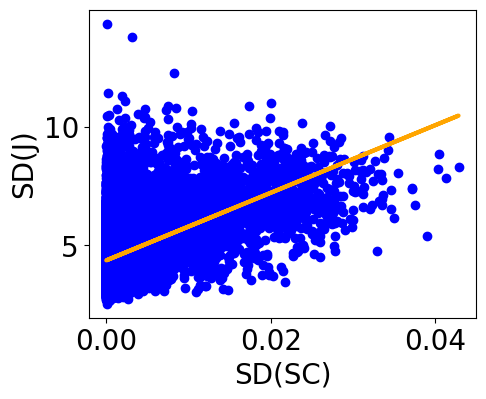

In [140]:
std_SC_all_as_is = torch.load( f=os.path.join(file_dir, 'std_SC_all_as_is.pt'), weights_only=False ).squeeze(dim=-1)
print( std_SC_all_as_is.size() )
std_J_all_as_is = torch.load( f=os.path.join(file_dir, 'std_J_all_as_is.pt'), weights_only=False ).squeeze(dim=-1)
print( std_J_all_as_is.size() )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax, feature=std_SC_all_as_is, param=std_J_all_as_is, feature_name='SD(SC)', param_name='SD(J)')

torch.Size([64620])
torch.Size([64620])
J from SC pred. corr.=3.62SD(SC)+0.0288, R^2=0.137, corr.=0.37


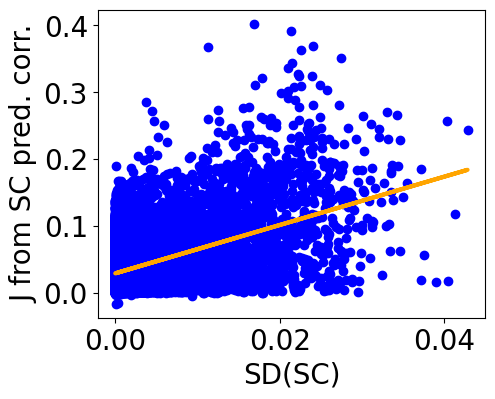

In [143]:
std_SC_all_as_is = torch.load( f=os.path.join(file_dir, 'std_SC_all_as_is.pt'), weights_only=False ).squeeze(dim=-1)
print( std_SC_all_as_is.size() )
lstsq_corr_SC_J = torch.load( f=os.path.join(file_dir, 'lstsq_corr_SC_J_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).squeeze(dim=-1)
print( lstsq_corr_SC_J.size() )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax, feature=std_SC_all_as_is, param=lstsq_corr_SC_J, feature_name='SD(SC)', param_name='J from SC pred. corr.')

torch.Size([360, 4])
torch.Size([360])
h from all. pred. corr.=0.23SD(sulcus depth)+0.0959, R^2=0.0817, corr.=0.285


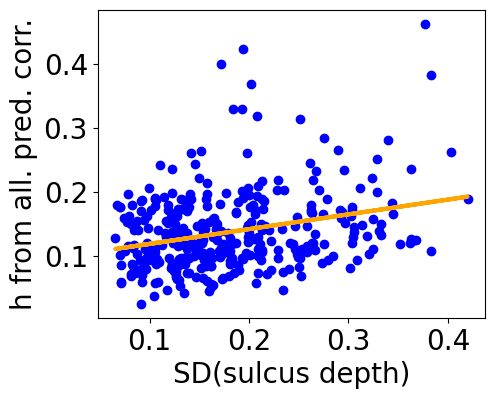

In [183]:
std_all_all_as_is = torch.load( f=os.path.join(file_dir, 'std_all_all_as_is.pt'), weights_only=False )
print( std_all_all_as_is.size() )
lstsq_corr_all_h = torch.load( f=os.path.join(file_dir, 'lstsq_corr_all_h_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).squeeze(dim=-1)
print( lstsq_corr_all_h.size() )
feature_index = 3
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax, feature=std_all_all_as_is[:,feature_index], param=lstsq_corr_all_h, feature_name=f'SD({feature_names[feature_index]})', param_name='h from all. pred. corr.')

torch.Size([360, 4])
torch.Size([360])
SD(h)=-3.93mean(myelination)+10.7, R^2=0.277, corr.=-0.524


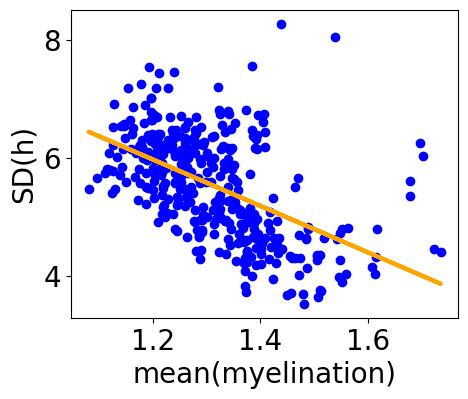

In [145]:
mean_all_all_as_is = torch.load( f=os.path.join(file_dir, 'mean_all_all_as_is.pt'), weights_only=False )
print( mean_all_all_as_is.size() )
std_individual_h = torch.load( f=os.path.join(file_dir, 'std_individual_h_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).squeeze(dim=-1)
print( std_individual_h.size() )
feature_index = 1
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax, feature=mean_all_all_as_is[:,feature_index], param=std_individual_h, feature_name=f'mean({feature_names[feature_index]})', param_name='SD(h)')

torch.Size([360, 4])
torch.Size([360])
SD(h)=-3.74mean(myelination)+6.28, R^2=0.205, corr.=-0.451


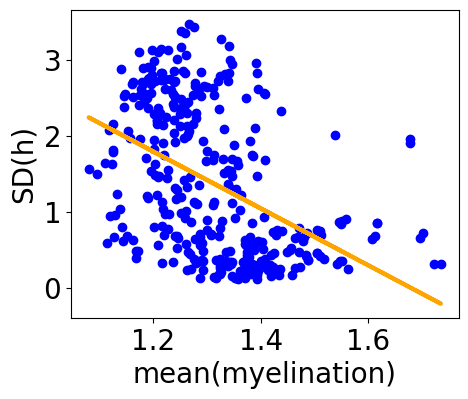

In [146]:
mean_all_all_as_is = torch.load( f=os.path.join(file_dir, 'mean_all_all_as_is.pt'), weights_only=False )
print( mean_all_all_as_is.size() )
std_group_h = torch.load( f=os.path.join(file_dir, 'std_group_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_threshold_index_10.pt'), weights_only=False ).squeeze(dim=-1)
print( std_group_h.size() )
feature_index = 1
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line(ax, feature=mean_all_all_as_is[:,feature_index], param=std_group_h, feature_name=f'mean({feature_names[feature_index]})', param_name='SD(h)')

In [19]:
mean_state = torch.load( os.path.join(file_dir, 'mean_state_all_mean_std_1.pt'), weights_only=False )
print( mean_state.size() )

torch.Size([4, 837, 360])


In [179]:
model_0_str = 'ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000'
model_1_str = 'ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000'

In [180]:
num_node_perms = 100
num_edge_perms = 100
# num_train_subjects = 419
# num_test_subjects = 418
num_train_subjects = 670
num_test_subjects = 167

In [181]:
# lstsq_corr_train_419_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_100.pt
lstsq_corr_train_all_mean_state_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_all_mean_state_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_all_mean_state_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_all_mean_state_1) ).item()  )
lstsq_corr_train_all_mean_state_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_all_mean_state_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_all_mean_state_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_all_mean_state_0) ).item()  )
lstsq_corr_train_all_h_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_all_h_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_all_h_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_all_h_1) ).item()  )
lstsq_corr_train_all_h_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_all_h_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_all_h_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_all_h_0) ).item()  )

torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0


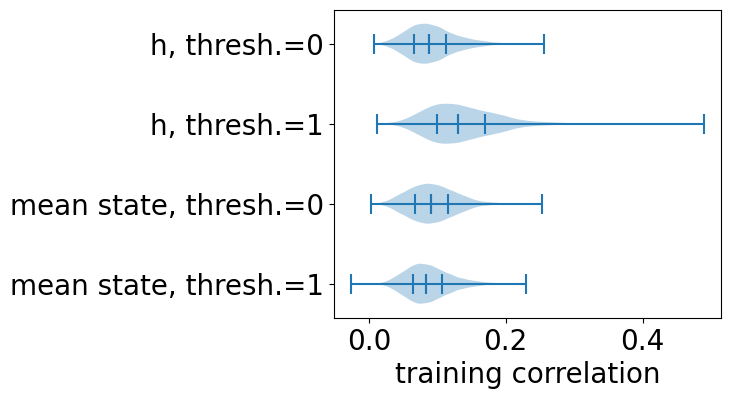

In [182]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs.flatten() ) for corrs in [lstsq_corr_train_all_h_0, lstsq_corr_train_all_h_1, lstsq_corr_train_all_mean_state_0, lstsq_corr_train_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

In [183]:
lstsq_corr_test_all_mean_state_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_all_mean_state_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_all_mean_state_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_all_mean_state_1) ).item()  )
lstsq_corr_test_all_mean_state_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_all_mean_state_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_all_mean_state_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_all_mean_state_0) ).item()  )
lstsq_corr_test_all_h_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_all_h_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_all_h_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_all_h_1) ).item()  )
lstsq_corr_test_all_h_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_all_h_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_all_h_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_all_h_0) ).item()  )

torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0


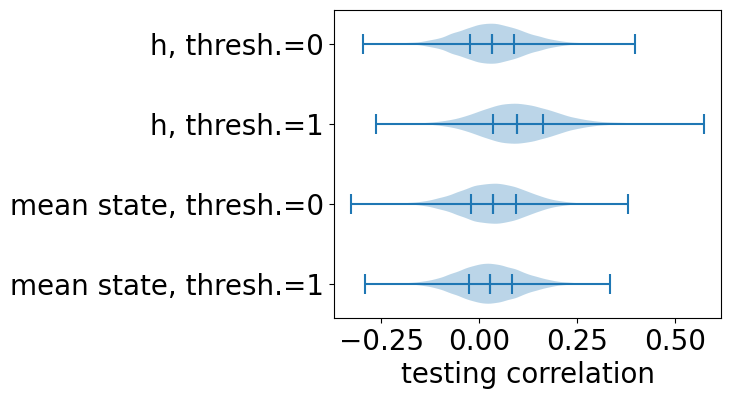

In [184]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs.flatten() ) for corrs in [lstsq_corr_test_all_h_0, lstsq_corr_test_all_h_1, lstsq_corr_test_all_mean_state_0, lstsq_corr_test_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

In [185]:
sc = torch.load( os.path.join(file_dir, 'edge_features_all_as_is.pt'), weights_only=False )[:,:,0]
sc_std = sc.std(dim=0)
print( sc.size(), sc_std.min().item() )
has_sufficient_sc_std = sc_std > 1e-7

torch.Size([837, 64620]) 1.292896740778815e-07


In [186]:
lstsq_corr_train_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_SC_FC_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_sc_fc_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_sc_fc_1) ).item()  )
lstsq_corr_train_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_SC_FC_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_sc_fc_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_sc_fc_0) ).item()  )
lstsq_corr_train_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_SC_J_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_sc_J_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_sc_J_1) ).item()  )
lstsq_corr_train_sc_J_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_train_{num_train_subjects}_SC_J_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_train_sc_J_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_train_sc_J_0) ).item()  )

torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0


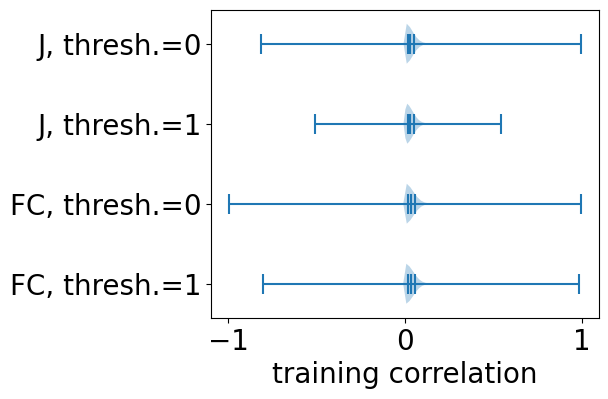

In [187]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch(    corrs[torch.logical_not(   torch.logical_or(  torch.logical_or( torch.isnan(corrs), torch.isinf(corrs) ), corrs.abs() > 1  )   )]    ) for corrs in [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

In [188]:
lstsq_corr_test_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_SC_FC_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_sc_fc_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_sc_fc_1) ).item()  )
lstsq_corr_test_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_SC_FC_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_sc_fc_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_sc_fc_0) ).item()  )
lstsq_corr_test_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_SC_J_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_sc_J_1.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_sc_J_1) ).item()  )
lstsq_corr_test_sc_J_0 = torch.load( os.path.join(file_dir,f'lstsq_corr_test_{num_test_subjects}_SC_J_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_corr_test_sc_J_0.size(), torch.count_nonzero( torch.isnan(lstsq_corr_test_sc_J_0) ).item()  )

torch.Size([64620, 100]) 17
torch.Size([64620, 100]) 19
torch.Size([64620, 100]) 11
torch.Size([64620, 100]) 8


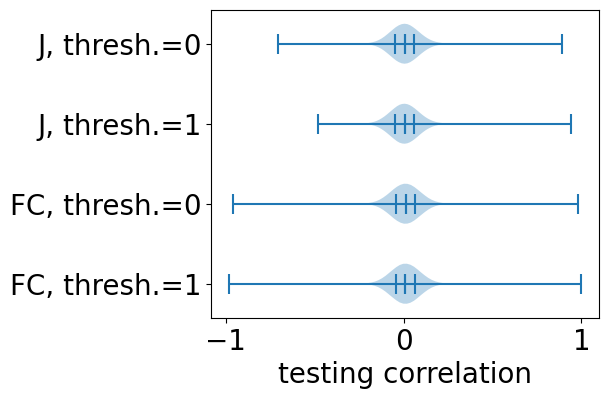

In [189]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch(    corrs[torch.logical_not(   torch.logical_or(  torch.logical_or( torch.isnan(corrs), torch.isinf(corrs) ), corrs.abs() > 1  )   )]    ) for corrs in [lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

In [190]:
edge_corr_list = [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1, lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1]
edge_corr_is_nan_list = [torch.logical_or(  torch.logical_or( torch.isnan(corrs), torch.isinf(corrs) ), corrs.abs() > 1  ) for corrs in edge_corr_list]
print('NaN counts')
print([ torch.count_nonzero(is_nan_bools).item() for is_nan_bools in edge_corr_is_nan_list ])
nan_count_per_edge_list = [torch.count_nonzero(is_nan_bools, dim=-1) for is_nan_bools in edge_corr_is_nan_list]
max_nan_count_list = [torch.max(nan_count).item() for nan_count in nan_count_per_edge_list]
print('max NaNs per edge')
print(max_nan_count_list)
has_nans_list = [nan_count > 0 for nan_count in nan_count_per_edge_list]
print('num edges with NaNs')
print([ torch.count_nonzero(has_nans).item() for has_nans in has_nans_list ])
print('min SD(SC)')
print( sc_std.min().item() )
print('max SD(SC) of regions with NaNs')
all_bad_sc_stds = torch.cat([ sc_std[has_nans] for has_nans in has_nans_list ], dim=0)
# print(all_bad_sc_stds)
max_bad_sc_std = all_bad_sc_stds.max()
has_sufficient_sc_std = sc_std > max_bad_sc_std
print( f'max bad SD(SC) {max_bad_sc_std:.3g}' )
print('num remaining edges')
print( torch.count_nonzero(has_sufficient_sc_std).item() )
filtered_edge_corr_list = [ corrs[has_sufficient_sc_std,:] for corrs in edge_corr_list ]
print('num NaN')
print([ torch.count_nonzero( torch.isnan(corrs) ).item() for corrs in filtered_edge_corr_list ])

NaN counts
[6, 2, 32, 29, 36, 37, 76, 74]
max NaNs per edge
[1, 1, 1, 1, 8, 6, 7, 10]
num edges with NaNs
[6, 2, 32, 29, 17, 15, 60, 47]
min SD(SC)
1.292896740778815e-07
max SD(SC) of regions with NaNs
max bad SD(SC) 0.0237
num remaining edges
202
num NaN
[0, 0, 0, 0, 0, 0, 0, 0]


In [191]:
edge_corr_list = [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1, lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1]
edge_corr_stack = torch.stack(edge_corr_list, dim=0)
edge_corr_stack_is_good = torch.logical_not(   torch.logical_or(  torch.logical_or( torch.isnan(edge_corr_stack), torch.isinf(edge_corr_stack) ), torch.abs(edge_corr_stack) > 1.0  )   )
print(f'number of valid correlations {torch.count_nonzero(edge_corr_stack_is_good)}')
edge_is_good = torch.all( torch.all(edge_corr_stack_is_good, dim=-1), dim=0 )
print(f'number of okay edges {torch.count_nonzero(edge_is_good)}')

number of valid correlations 51695708
number of okay edges 64484


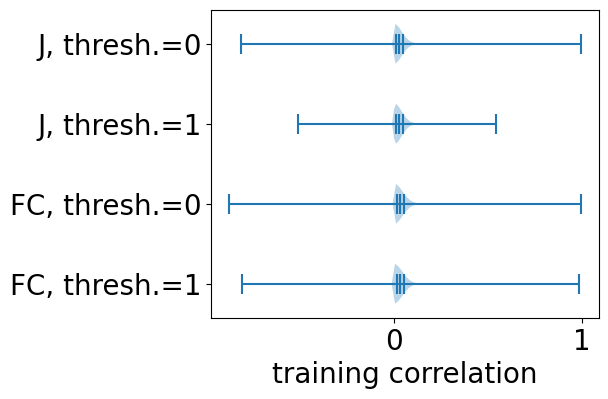

In [192]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs[edge_is_good,:].flatten() ) for corrs in [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

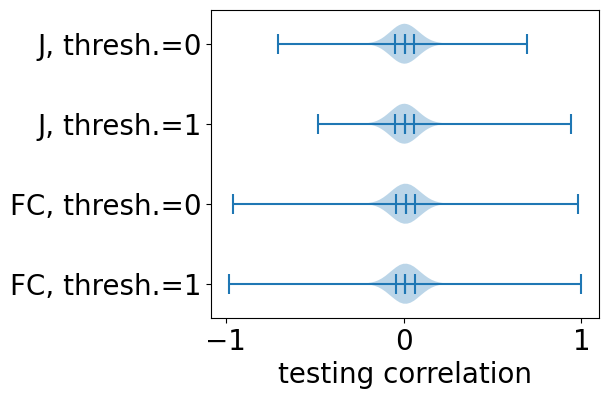

In [193]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs[edge_is_good,:].flatten() ) for corrs in [lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

In [194]:
for label, corrs in zip(['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1'],[lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1]):
    corr_is_nan = torch.isnan(corrs)
    corr_is_inf = torch.isinf(corrs)
    corr_is_big = torch.abs(corrs) > 1.0
    is_okay = torch.logical_not(  torch.logical_or( torch.logical_or(corr_is_nan, corr_is_inf), corr_is_big )  )
    corrs = corrs[is_okay]
    print( f'SC-{label} correlation, min {corrs.min().item():.3g}, median {corrs.median().item():.3g}, max {corrs.max().item():.3g}, num NaN {torch.count_nonzero(corr_is_nan)}, num Inf {torch.count_nonzero(corr_is_inf)}, num abs > 1 {torch.count_nonzero(corr_is_big)}' )

SC-J, thresh.=0 correlation, min -0.704, median 0.00684, max 0.892, num NaN 8, num Inf 23, num abs > 1 28
SC-J, thresh.=1 correlation, min -0.481, median 0.00583, max 0.94, num NaN 11, num Inf 25, num abs > 1 26
SC-FC, thresh.=0 correlation, min -0.956, median 0.0114, max 0.981, num NaN 19, num Inf 14, num abs > 1 57
SC-FC, thresh.=1 correlation, min -0.981, median 0.0109, max 0.999, num NaN 17, num Inf 24, num abs > 1 57


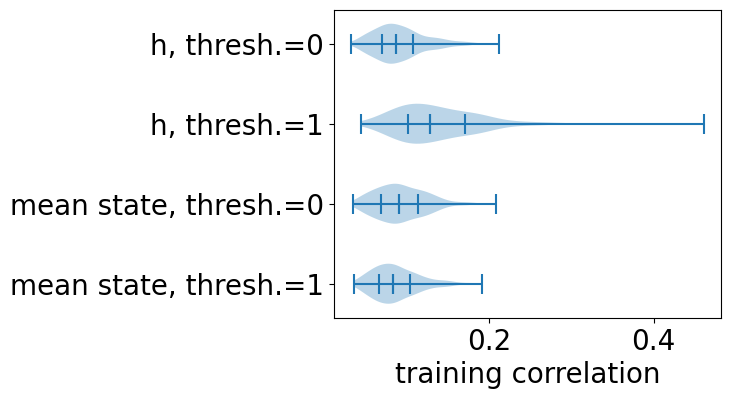

In [195]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs.nanmean(dim=-1) ) for corrs in [lstsq_corr_train_all_h_0, lstsq_corr_train_all_h_1, lstsq_corr_train_all_mean_state_0, lstsq_corr_train_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

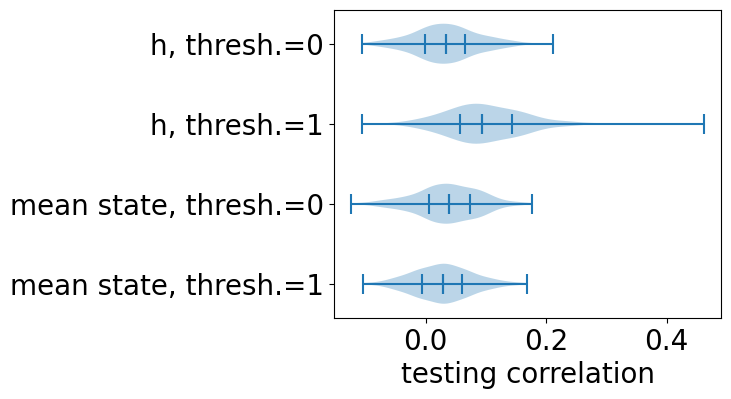

In [196]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs.nanmean(dim=-1) ) for corrs in [lstsq_corr_test_all_h_0, lstsq_corr_test_all_h_1, lstsq_corr_test_all_mean_state_0, lstsq_corr_test_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

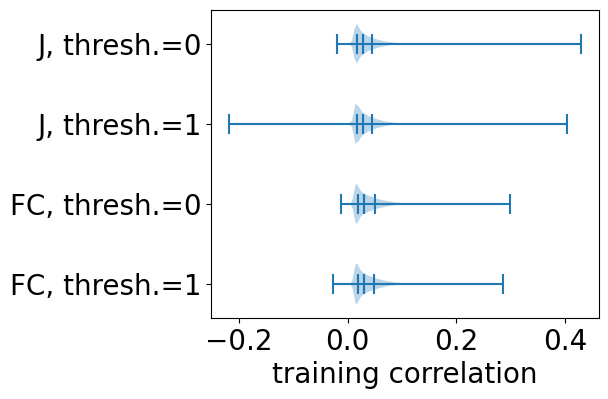

In [197]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs.nanmean(dim=-1) ) for corrs in [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

C:\Users\agcraig\Anaconda3\envs\torch_with_cuda\lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\agcraig\Anaconda3\envs\torch_with_cuda\lib\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


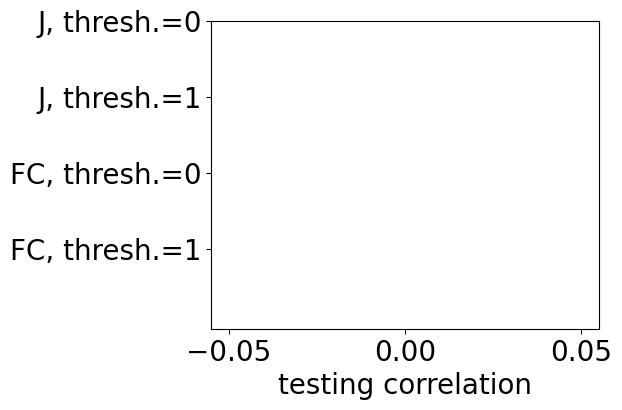

In [193]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( corrs.nanmean(dim=-1) ) for corrs in [lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

In [198]:
print([ torch.count_nonzero(  torch.isnan( corrs.nanmean(dim=-1) )  ).item() for corrs in [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1] ])

[0, 0, 0, 0]


In [199]:
print([ torch.count_nonzero(  torch.isnan( corrs.nanmean(dim=-1) )  ).item() for corrs in [lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1] ])

[4, 4, 1, 2]


In [200]:
print([ torch.count_nonzero(  torch.isinf( corrs.nanmean(dim=-1) )  ).item() for corrs in [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1] ])

[0, 0, 0, 0]


In [201]:
print([ torch.count_nonzero(  torch.isinf( corrs.nanmean(dim=-1) )  ).item() for corrs in [lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1] ])

[6, 9, 8, 11]


In [198]:
node_features = torch.load( os.path.join(file_dir, 'node_features_all_as_is.pt'), weights_only=False )[:,:,:4]
node_features_std = node_features.std(dim=0)
print( node_features.size(), node_features_std.min(dim=0).values.tolist() )

torch.Size([837, 360, 4]) [0.09672675281763077, 0.008244452998042107, 0.010398550890386105, 0.06557611376047134]


In [199]:
num_train = 670
num_subjects = node_features.size(dim=0)
for perm_index in range(10):
    perm = torch.randperm(n=num_subjects, dtype=int_type, device=node_features.device)
    node_features_perm = node_features[perm,:,:]
    node_features_std_train = node_features_perm[:num_train,:,:].std(dim=0)
    node_features_std_test = node_features_perm[num_train:,:,:].std(dim=0)
    print( node_features_std_train.min(dim=0).values.tolist(), node_features_std_test.min(dim=0).values.tolist() )

[0.09607986360788345, 0.00784551352262497, 0.010500664822757244, 0.06596917659044266] [0.0972263440489769, 0.009520172141492367, 0.00974035169929266, 0.06380484998226166]
[0.09595966339111328, 0.008056918159127235, 0.010442043654620647, 0.06601251661777496] [0.0908096507191658, 0.008978363126516342, 0.010242024436593056, 0.0635984018445015]
[0.0962425246834755, 0.008054514415562153, 0.010516957379877567, 0.06701241433620453] [0.09888814389705658, 0.00897621177136898, 0.009905187413096428, 0.0595916323363781]
[0.09660252183675766, 0.008596556261181831, 0.010255109518766403, 0.06453445553779602] [0.09042207151651382, 0.006638974882662296, 0.01098351739346981, 0.0665491595864296]
[0.09805832803249359, 0.008294660598039627, 0.010144215077161789, 0.06488741189241409] [0.08917933702468872, 0.008049306459724903, 0.011369597166776657, 0.06623775511980057]
[0.09452324360609055, 0.008335717022418976, 0.01033568661659956, 0.06565384566783905] [0.09952864795923233, 0.007888253778219223, 0.01067698

In [200]:
sc = torch.load( os.path.join(file_dir, 'edge_features_all_as_is.pt'), weights_only=False )[:,:,0]
sc_std = sc.std(dim=0)
print( sc.size(), sc_std.min().item() )

torch.Size([837, 64620]) 1.292896740778815e-07


In [201]:
num_train = 419
num_subjects = sc.size(dim=0)
for perm_index in range(100):
    perm = torch.randperm(n=num_subjects, dtype=int_type, device=node_features.device)
    sc_perm = sc[perm,:]
    sc_std_train = sc_perm[:num_train,:].std(dim=0)
    sc_std_test = sc_perm[num_train:,:].std(dim=0)
    print( sc_std_train.min().item(), sc_std_test.min().item() )

9.175384008131005e-08 1.243852381094257e-07
1.0582079568166591e-07 1.2625338285943144e-07
1.29290796735404e-07 1.0951762163813328e-07
9.17538471867374e-08 1.1076214434524445e-07
1.307232935232605e-07 1.1830850610294874e-07
1.0582078857623856e-07 1.2944347815846413e-07
1.0938780548030991e-07 1.1830850610294874e-07
1.1816861444913229e-07 1.2944349236931885e-07
1.29290796735404e-07 1.1814672973287088e-07
9.484668339609925e-08 1.1830850610294874e-07
1.1816861444913229e-07 1.2229645562911173e-07
1.0582078857623856e-07 1.1830849899752138e-07
9.175384008131005e-08 1.1814672262744352e-07
1.0582078857623856e-07 1.302963568150517e-07
1.1800839416764575e-07 1.1830849899752138e-07
1.2742223987061152e-07 1.0594637700478415e-07
1.1517659004312009e-07 1.388678469993465e-07
1.0582079568166591e-07 1.2229645562911173e-07
1.2423998896338162e-07 1.183085132083761e-07
1.0303415365342516e-07 1.1830850610294874e-07
1.0938780548030991e-07 1.1830849899752138e-07
1.1816862155455965e-07 9.186300076180487e-08
1.0

In [202]:
# lstsq_corr_train_419_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_100.pt
lstsq_rmse_train_all_mean_state_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_all_mean_state_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_all_mean_state_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_all_mean_state_1) ).item()  )
lstsq_rmse_train_all_mean_state_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_all_mean_state_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_all_mean_state_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_all_mean_state_0) ).item()  )
lstsq_rmse_train_all_h_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_all_h_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_all_h_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_all_h_1) ).item()  )
lstsq_rmse_train_all_h_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_all_h_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_all_h_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_all_h_0) ).item()  )

torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0


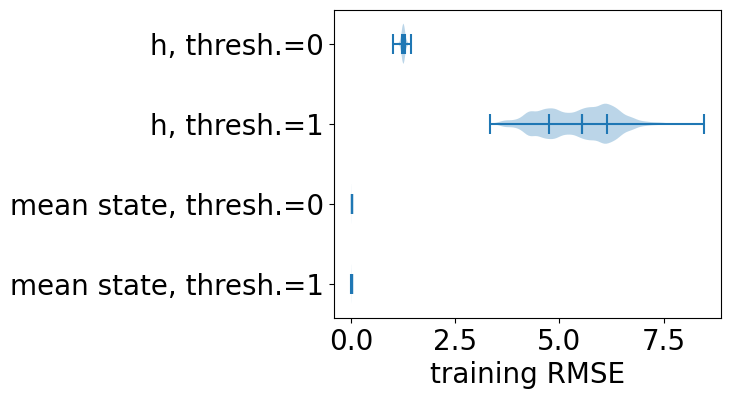

In [203]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rmse_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_rmses = [ depytorch( corrs.flatten() ) for corrs in [lstsq_rmse_train_all_h_0, lstsq_rmse_train_all_h_1, lstsq_rmse_train_all_mean_state_0, lstsq_rmse_train_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_rmses) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rmses), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rmse_labels) )  )
axs.set_xlabel('training RMSE')
plt.show()

In [204]:
# lstsq_corr_train_419_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_100.pt
lstsq_rmse_test_all_mean_state_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_all_mean_state_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_all_mean_state_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_all_mean_state_1) ).item()  )
lstsq_rmse_test_all_mean_state_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_all_mean_state_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_all_mean_state_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_all_mean_state_0) ).item()  )
lstsq_rmse_test_all_h_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_all_h_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_all_h_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_all_h_1) ).item()  )
lstsq_rmse_test_all_h_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_all_h_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_all_h_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_all_h_0) ).item()  )

torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0


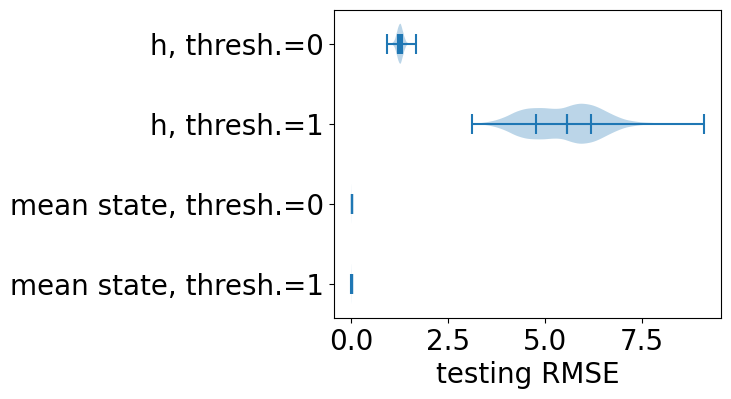

In [205]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rmse_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_rmses = [ depytorch( corrs.flatten() ) for corrs in [lstsq_rmse_test_all_h_0, lstsq_rmse_test_all_h_1, lstsq_rmse_test_all_mean_state_0, lstsq_rmse_test_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_rmses) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rmses), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rmse_labels) )  )
axs.set_xlabel('testing RMSE')
plt.show()

In [206]:
lstsq_rmse_train_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_SC_FC_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_sc_fc_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_sc_fc_1) ).item()  )
lstsq_rmse_train_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_SC_FC_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_sc_fc_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_sc_fc_0) ).item()  )
lstsq_rmse_train_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_SC_J_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_sc_J_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_sc_J_1) ).item()  )
lstsq_rmse_train_sc_J_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_train_{num_train_subjects}_SC_J_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_train_sc_J_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_train_sc_J_0) ).item()  )

torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0


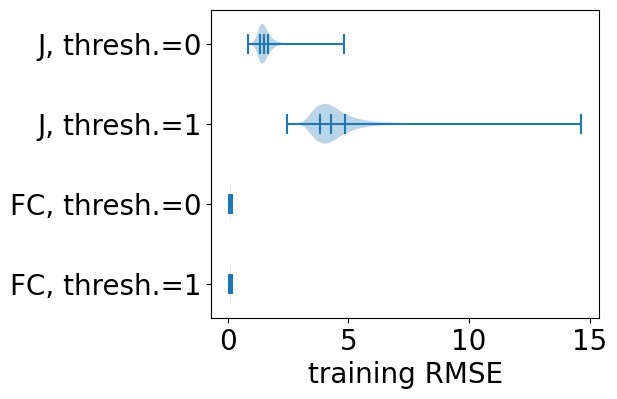

In [207]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rmse_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(rmse_labels)+1 )
all_rmses = [ depytorch( rmses.flatten() ) for rmses in [lstsq_rmse_train_sc_J_0, lstsq_rmse_train_sc_J_1, lstsq_rmse_train_sc_fc_0, lstsq_rmse_train_sc_fc_1] ]
axs.violinplot(  list( reversed(all_rmses) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rmses), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rmse_labels) )  )
axs.set_xlabel('training RMSE')
plt.show()

In [208]:
lstsq_rmse_test_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_SC_FC_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_sc_fc_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_sc_fc_1) ).item()  )
lstsq_rmse_test_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_SC_FC_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_sc_fc_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_sc_fc_0) ).item()  )
lstsq_rmse_test_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_SC_J_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_sc_J_1.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_sc_J_1) ).item()  )
lstsq_rmse_test_sc_J_0 = torch.load( os.path.join(file_dir,f'lstsq_rmse_test_{num_test_subjects}_SC_J_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rmse_test_sc_J_0.size(), torch.count_nonzero( torch.isnan(lstsq_rmse_test_sc_J_0) ).item()  )

torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0


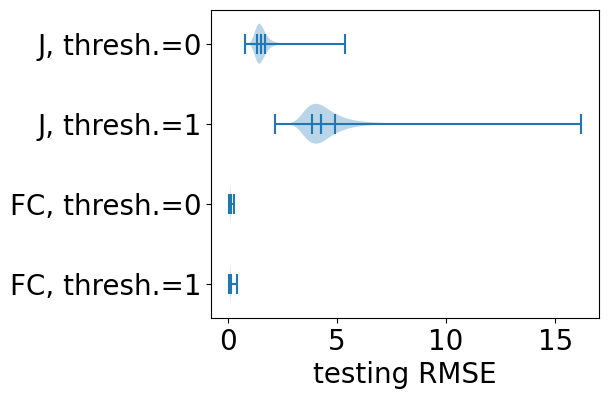

In [209]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rmse_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(rmse_labels)+1 )
all_rmses = [ depytorch( rmses.flatten() ) for rmses in [lstsq_rmse_test_sc_J_0, lstsq_rmse_test_sc_J_1, lstsq_rmse_test_sc_fc_0, lstsq_rmse_test_sc_fc_1] ]
axs.violinplot(  list( reversed(all_rmses) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rmses), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rmse_labels) )  )
axs.set_xlabel('testing RMSE')
plt.show()

In [210]:
# lstsq_corr_train_419_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_100.pt
lstsq_rsquared_train_all_mean_state_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_all_mean_state_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_all_mean_state_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_all_mean_state_1) ).item()  )
lstsq_rsquared_train_all_mean_state_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_all_mean_state_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_all_mean_state_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_all_mean_state_0) ).item()  )
lstsq_rsquared_train_all_h_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_all_h_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_all_h_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_all_h_1) ).item()  )
lstsq_rsquared_train_all_h_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_all_h_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_all_h_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_all_h_0) ).item()  )

torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0


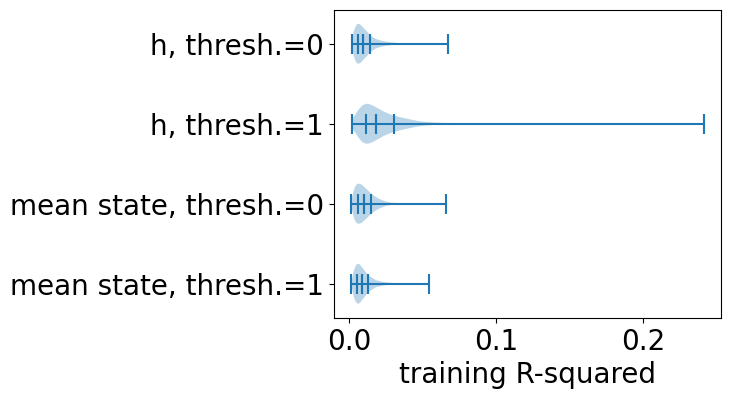

In [211]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rsquared_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_rsquareds = [ depytorch( rsquareds.flatten() ) for rsquareds in [lstsq_rsquared_train_all_h_0, lstsq_rsquared_train_all_h_1, lstsq_rsquared_train_all_mean_state_0, lstsq_rsquared_train_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_rsquareds) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rmses), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rsquared_labels) )  )
axs.set_xlabel('training R-squared')
plt.show()

In [212]:
# lstsq_corr_train_419_SC_FC_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_perms_100.pt
lstsq_rsquared_test_all_mean_state_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_all_mean_state_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_all_mean_state_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_all_mean_state_1) ).item()  )
lstsq_rsquared_test_all_mean_state_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_all_mean_state_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_all_mean_state_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_all_mean_state_0) ).item()  )
lstsq_rsquared_test_all_h_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_all_h_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_all_h_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_all_h_1) ).item()  )
lstsq_rsquared_test_all_h_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_all_h_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_all_h_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_all_h_0) ).item()  )

torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0
torch.Size([360, 100]) 0


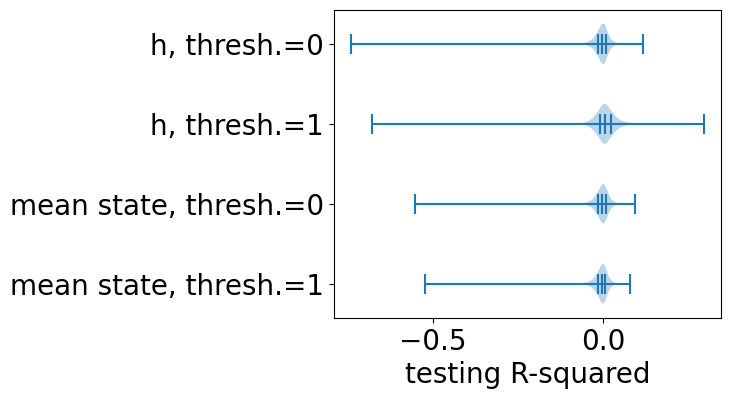

In [213]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rsquared_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
label_x = range( 1, len(corr_labels)+1 )
all_rsquareds = [ depytorch( corrs.flatten() ) for corrs in [lstsq_rsquared_test_all_h_0, lstsq_rsquared_test_all_h_1, lstsq_rsquared_test_all_mean_state_0, lstsq_rsquared_test_all_mean_state_1] ]
axs.violinplot(  list( reversed(all_rsquareds) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rsquareds), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rsquared_labels) )  )
axs.set_xlabel('testing R-squared')
plt.show()

In [214]:
lstsq_rsquared_train_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_SC_FC_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_sc_fc_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_sc_fc_1) ).item()  )
lstsq_rsquared_train_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_SC_FC_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_sc_fc_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_sc_fc_0) ).item()  )
lstsq_rsquared_train_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_SC_J_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_sc_J_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_sc_J_1) ).item()  )
lstsq_rsquared_train_sc_J_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_train_{num_train_subjects}_SC_J_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_train_sc_J_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_train_sc_J_0) ).item()  )

torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0


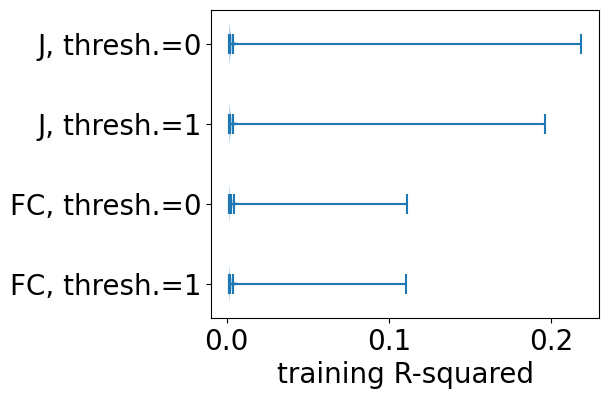

In [215]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rsquared_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(rsquared_labels)+1 )
all_rsquareds = [ depytorch( rmses.flatten() ) for rmses in [lstsq_rsquared_train_sc_J_0, lstsq_rsquared_train_sc_J_1, lstsq_rsquared_train_sc_fc_0, lstsq_rsquared_train_sc_fc_1] ]
axs.violinplot(  list( reversed(all_rsquareds) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rsquareds), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rsquared_labels) )  )
axs.set_xlabel('training R-squared')
plt.show()

In [216]:
lstsq_rsquared_test_sc_fc_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_SC_FC_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_sc_fc_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_sc_fc_1) ).item()  )
lstsq_rsquared_test_sc_fc_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_SC_FC_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_sc_fc_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_sc_fc_0) ).item()  )
lstsq_rsquared_test_sc_J_1 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_SC_J_{model_1_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_sc_J_1.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_sc_J_1) ).item()  )
lstsq_rsquared_test_sc_J_0 = torch.load( os.path.join(file_dir,f'lstsq_rsquared_test_{num_test_subjects}_SC_J_{model_0_str}_perms_{num_node_perms}.pt'), weights_only=False )
print(  lstsq_rsquared_test_sc_J_0.size(), torch.count_nonzero( torch.isnan(lstsq_rsquared_test_sc_J_0) ).item()  )

torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0
torch.Size([64620, 100]) 0


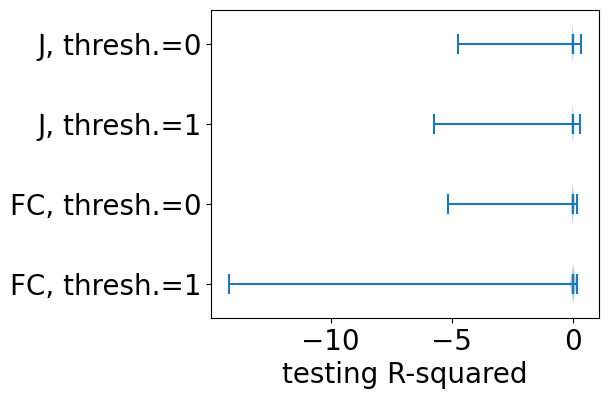

In [217]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
rsquared_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
label_x = range( 1, len(rsquared_labels)+1 )
all_rsquareds = [ depytorch( rsquareds.flatten() ) for rsquareds in [lstsq_rsquared_test_sc_J_0, lstsq_rsquared_test_sc_J_1, lstsq_rsquared_test_sc_fc_0, lstsq_rsquared_test_sc_fc_1] ]
axs.violinplot(  list( reversed(all_rsquareds) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_rsquareds), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(rsquared_labels) )  )
axs.set_xlabel('testing R-squared')
plt.show()

In [218]:
def corr_is_bad(corrs:torch.Tensor):
    return torch.logical_or(  torch.logical_or( torch.isnan(corrs), torch.isinf(corrs) ), torch.abs(corrs) > 1  )

In [219]:
p_value_h_all_0 = torch.load( os.path.join(file_dir, f'p_value_lstsq_corr_all_h_{model_0_str}_perms_1000000.pt'), weights_only=False )
num_nodes = p_value_h_all_0.numel()
alpha = 0.05/num_nodes
is_sig_h_all_0 = p_value_h_all_0 < alpha
print(f'h, threshold 0 significant correlations {torch.count_nonzero(is_sig_h_all_0)}')
p_value_h_all_1 = torch.load( os.path.join(file_dir, f'p_value_lstsq_corr_all_h_{model_1_str}_perms_1000000.pt'), weights_only=False )
is_sig_h_all_1 = p_value_h_all_1 < alpha
print(f'h, threshold 1 significant correlations {torch.count_nonzero(is_sig_h_all_1)}')
p_value_mean_state_all_0 = torch.load( os.path.join(file_dir, f'p_value_lstsq_corr_all_mean_state_{model_0_str}_perms_1000000.pt'), weights_only=False )
is_sig_mean_state_all_0 = p_value_mean_state_all_0 < alpha
print(f'mean state, threshold 0 significant correlations {torch.count_nonzero(is_sig_mean_state_all_0)}')
p_value_mean_state_all_1 = torch.load( os.path.join(file_dir, f'p_value_lstsq_corr_all_mean_state_{model_1_str}_perms_1000000.pt'), weights_only=False )
is_sig_mean_state_all_1 = p_value_mean_state_all_1 < alpha
print(f'mean state, threshold 1 significant correlations {torch.count_nonzero(is_sig_mean_state_all_1)}')

h, threshold 0 significant correlations 12
h, threshold 1 significant correlations 96
mean state, threshold 0 significant correlations 9
mean state, threshold 1 significant correlations 5


In [244]:
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
min_corr = 0.1
train_corr_list = [lstsq_corr_train_all_h_0, lstsq_corr_train_all_h_1, lstsq_corr_train_all_mean_state_0, lstsq_corr_train_all_mean_state_1]
test_corr_list = [lstsq_corr_test_all_h_0, lstsq_corr_test_all_h_1, lstsq_corr_test_all_mean_state_0, lstsq_corr_test_all_mean_state_1]
label_x = range( 1, len(corr_labels)+1 )
is_big_enough = [ is_sig_h_all_0, is_sig_h_all_1, is_sig_mean_state_all_0, is_sig_mean_state_all_1 ]
print(f'num training correlations that are at least {min_corr:.3g}')
print([ torch.count_nonzero(filt).item() for filt in is_big_enough])
big_train_corr_list = [ corrs[filt] for corrs, filt in zip(train_corr_list, is_big_enough) ]
big_test_corr_list = [ corrs[filt] for corrs, filt in zip(test_corr_list, is_big_enough) ]
print('bad training correlations after filtering')
print([ torch.count_nonzero( corr_is_bad(corrs) ).item() for corrs in big_train_corr_list ])
print('bad testing correlations after filtering')
print([ torch.count_nonzero( corr_is_bad(corrs) ).item() for corrs in big_test_corr_list ])

num training correlations that are at least 0.1
[12, 96, 9, 5]
bad training correlations after filtering
[0, 0, 0, 0]
bad testing correlations after filtering
[0, 0, 0, 0]


In [245]:
all_big_corrs = big_train_corr_list + big_test_corr_list
big_corr_min = min([ torch.min(corrs).item() for corrs in all_big_corrs ])
big_corr_max = max([ torch.max(corrs).item() for corrs in all_big_corrs ])
lim_margin = 0.05
cross_val_lim = [big_corr_min - lim_margin, big_corr_max + lim_margin]
cross_val_ticks = np.arange(-0.2, 0.8, 0.2)

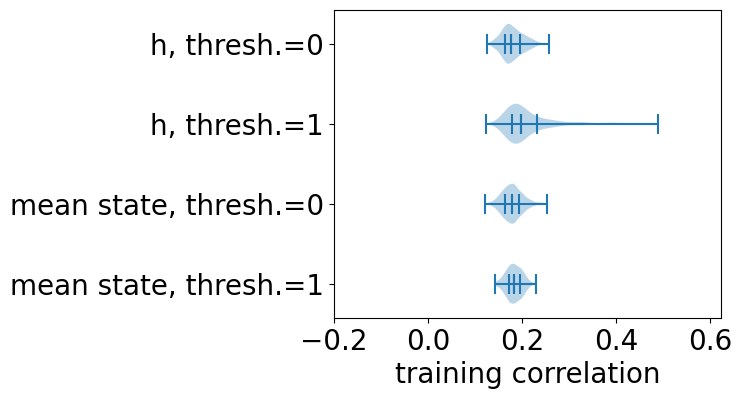

In [222]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
all_corrs = [ depytorch( corrs.flatten() ) for corrs in big_train_corr_list ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_xlim(cross_val_lim)
axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

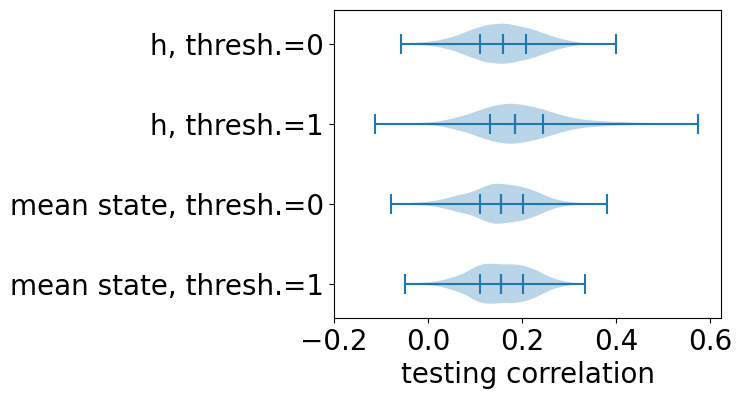

In [223]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
all_corrs = [ depytorch( corrs.flatten() ) for corrs in big_test_corr_list ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_xlim(cross_val_lim)
axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

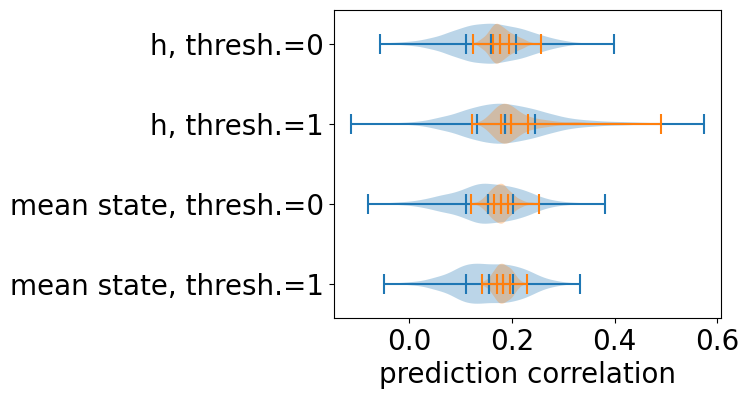

In [224]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
all_train_corrs = [ depytorch( corrs.flatten() ) for corrs in big_train_corr_list ]
all_test_corrs = [ depytorch( corrs.flatten() ) for corrs in big_test_corr_list ]
axs.violinplot(  list( reversed(all_test_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.violinplot(  list( reversed(all_train_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('prediction correlation')
plt.show()

testing correlation=0.531training correlation+-0.0152, R^2=0.0513, corr.=0.227
testing correlation=0.856training correlation+-0.0178, R^2=0.284, corr.=0.533
testing correlation=0.508training correlation+-0.0115, R^2=0.0453, corr.=0.213
testing correlation=0.406training correlation+-0.00727, R^2=0.0279, corr.=0.167


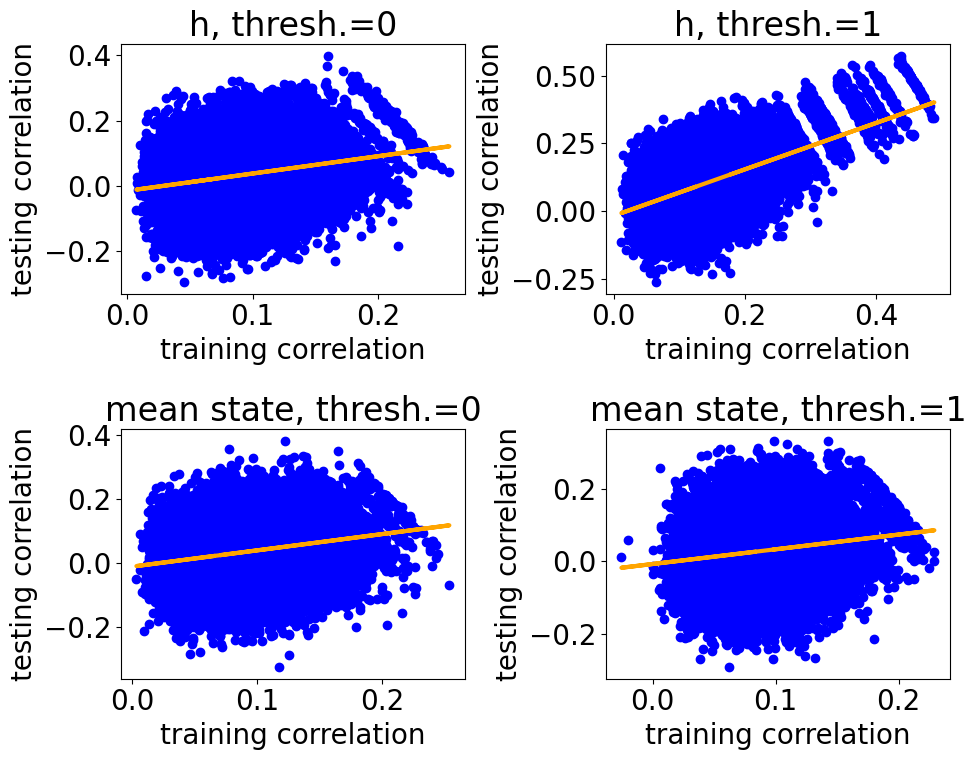

In [225]:
all_train_corrs = [ corrs.flatten() for corrs in train_corr_list ]
all_test_corrs = [ corrs.flatten() for corrs in test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(all_train_corrs,all_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

testing correlation=-1.52training correlation+0.432, R^2=0.242, corr.=-0.492
testing correlation=0.716training correlation+0.039, R^2=0.226, corr.=0.476
testing correlation=-2.15training correlation+0.539, R^2=0.446, corr.=-0.667
testing correlation=-3.2training correlation+0.742, R^2=0.724, corr.=-0.849


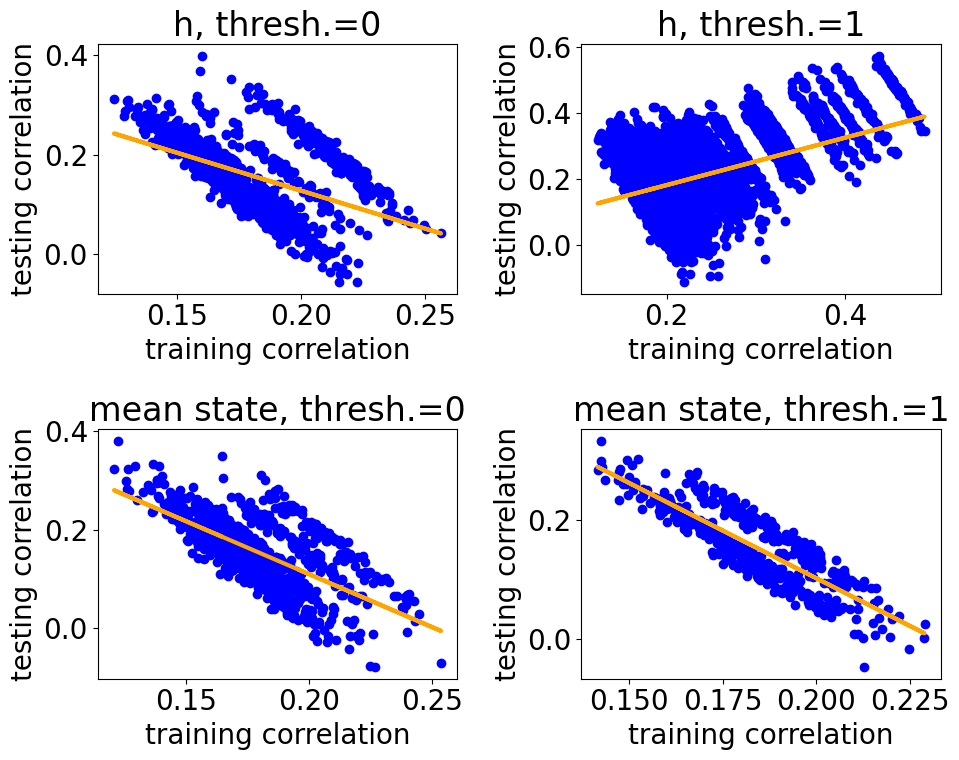

In [226]:
all_train_corrs = [ corrs.flatten() for corrs in big_train_corr_list ]
all_test_corrs = [ corrs.flatten() for corrs in big_test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(all_train_corrs,all_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

testing correlation=1.62training correlation+-0.116, R^2=0.934, corr.=0.964
testing correlation=1.22training correlation+-0.0692, R^2=0.966, corr.=0.98
testing correlation=1.65training correlation+-0.118, R^2=0.924, corr.=0.958
testing correlation=1.63training correlation+-0.115, R^2=0.921, corr.=0.957


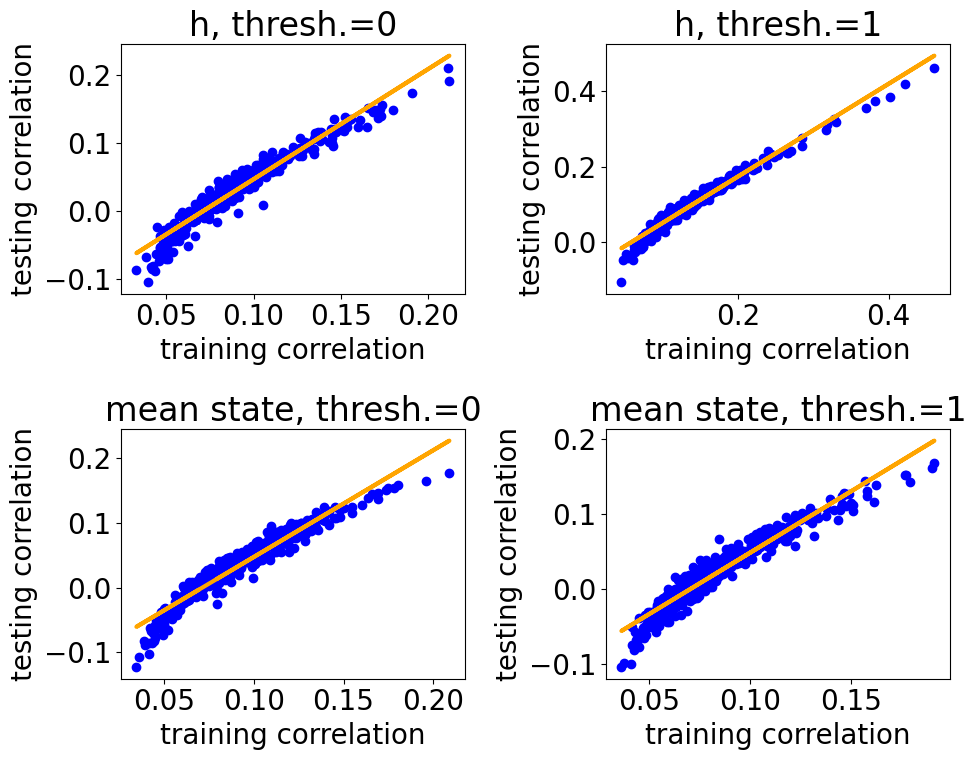

In [227]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in train_corr_list ]
mean_test_corrs = [ corrs.mean(dim=-1) for corrs in test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

testing correlation=1.3training correlation+-0.0765, R^2=0.87, corr.=0.855
testing correlation=1.08training correlation+-0.0394, R^2=0.984, corr.=0.982
testing correlation=0.78training correlation+0.0138, R^2=0.899, corr.=0.843
testing correlation=1.12training correlation+-0.05, R^2=0.699, corr.=0.669


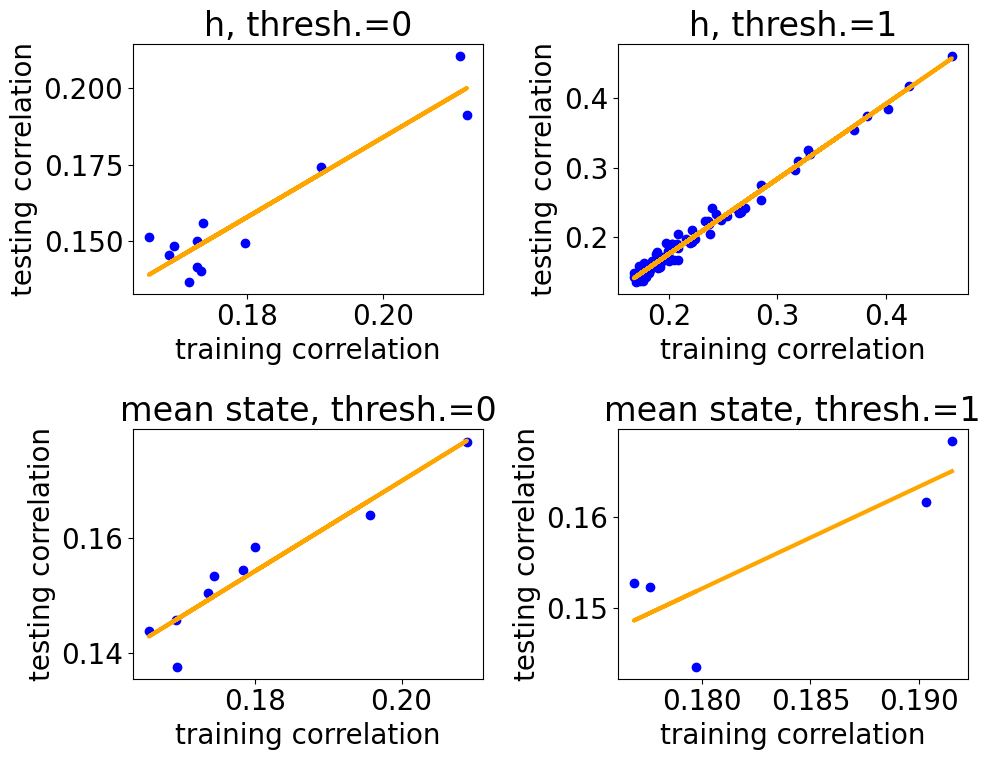

In [228]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in big_train_corr_list ]
mean_test_corrs = [ corrs.mean(dim=-1) for corrs in big_test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

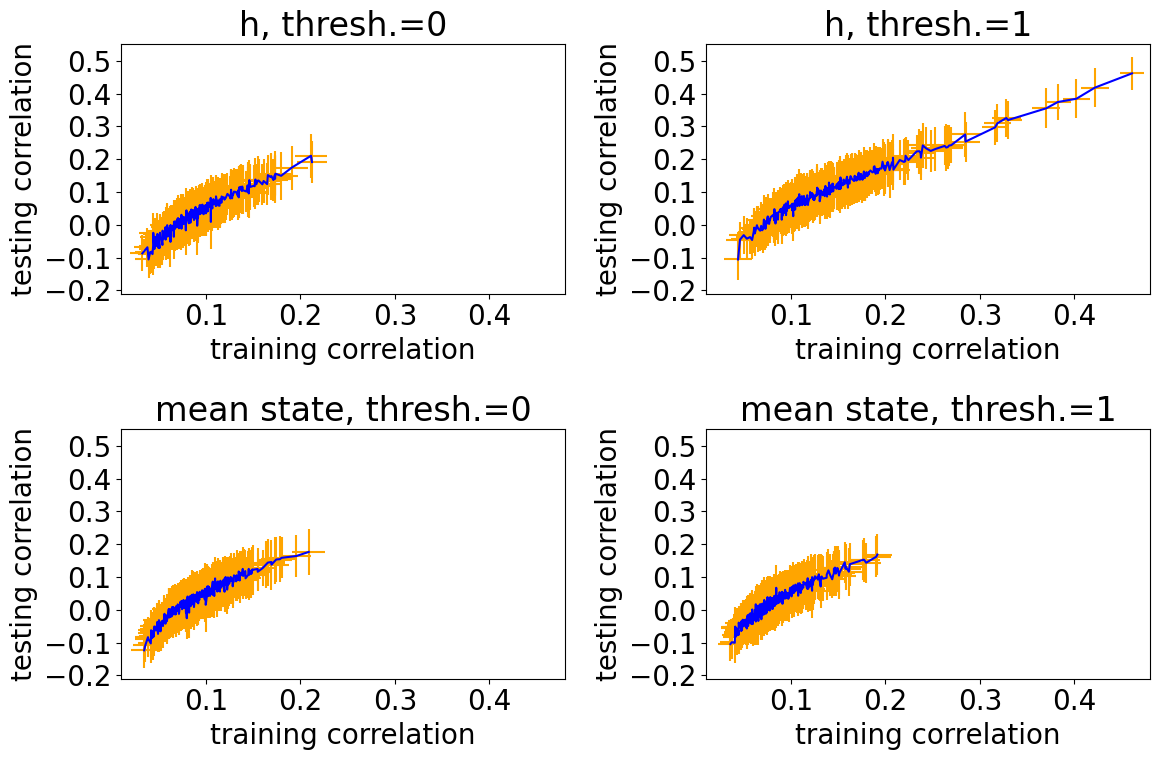

In [229]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in train_corr_list ]
corrs_orders = [ torch.sort(corrs).indices for corrs in mean_train_corrs ]
mean_train_corrs = [ corrs[indices] for corrs, indices in zip(mean_train_corrs,corrs_orders) ]
mean_test_corrs = [ corrs.mean(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
std_train_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(train_corr_list,corrs_orders) ]
std_test_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(12, 8) )
err_xlim = [0.01, 0.48]
err_xticks = np.arange(0.1, 0.45, 0.1)
err_ylim = [-0.21, 0.55]
err_yticks = np.arange(-0.2, 0.51, 0.1)
for train_mean, test_mean, train_std, test_std, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,std_train_corrs,std_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    ax.errorbar( x=depytorch(train_mean), y=depytorch(test_mean), xerr=depytorch(train_std), yerr=depytorch(test_std), color='blue', ecolor='orange' )
    ax.set_xlim(err_xlim)
    ax.set_xticks(err_xticks)
    ax.set_ylim(err_ylim)
    ax.set_yticks(err_yticks)
    ax.set_xlabel('training correlation')
    ax.set_ylabel('testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

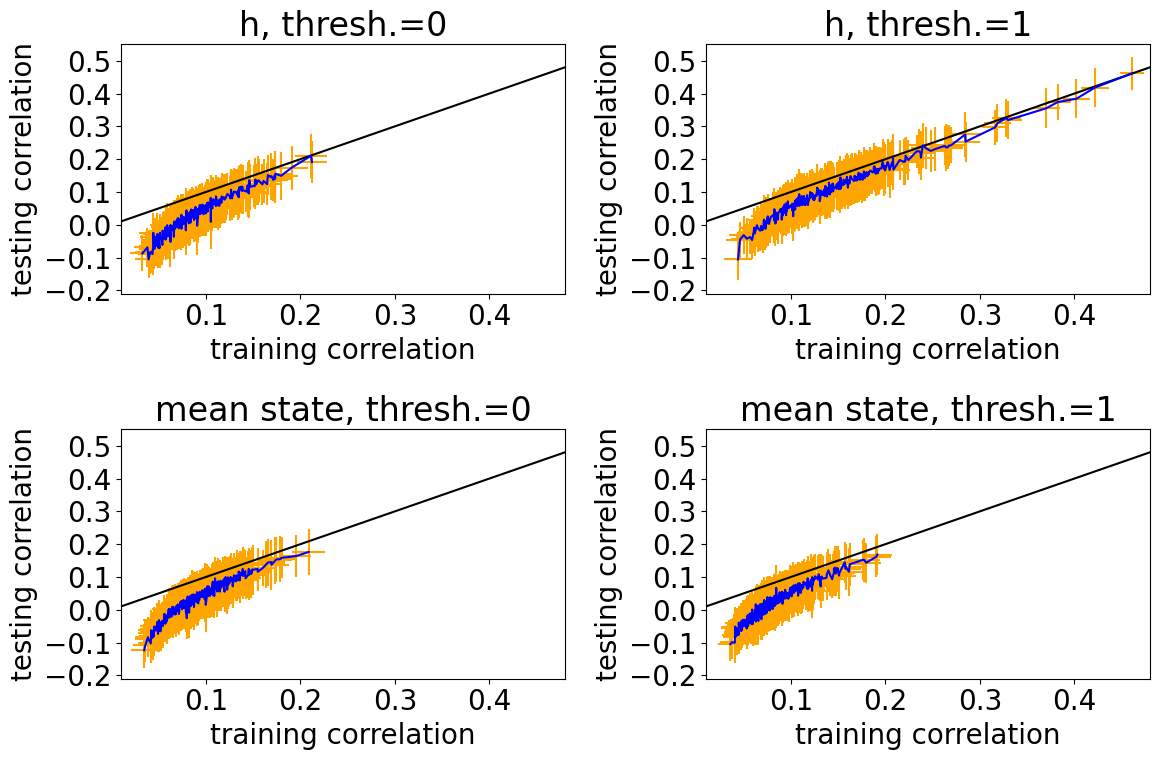

In [247]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in train_corr_list ]
corrs_orders = [ torch.sort(corrs).indices for corrs in mean_train_corrs ]
mean_train_corrs = [ corrs[indices] for corrs, indices in zip(mean_train_corrs,corrs_orders) ]
mean_test_corrs = [ corrs.mean(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
std_train_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(train_corr_list,corrs_orders) ]
std_test_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(12, 8) )
err_xlim = [0.01, 0.48]
err_xticks = np.arange(0.1, 0.45, 0.1)
err_ylim = [-0.21, 0.55]
err_yticks = np.arange(-0.2, 0.51, 0.1)
identity_line_endpoints = [0.0, 0.5]
for train_mean, test_mean, train_std, test_std, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,std_train_corrs,std_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    ax.errorbar( x=depytorch(train_mean), y=depytorch(test_mean), xerr=depytorch(train_std), yerr=depytorch(test_std), color='blue', ecolor='orange' )
    ax.plot(identity_line_endpoints, identity_line_endpoints, color='black', linestyle='solid')
    ax.set_xlim(err_xlim)
    ax.set_xticks(err_xticks)
    ax.set_ylim(err_ylim)
    ax.set_yticks(err_yticks)
    ax.set_xlabel('training correlation')
    ax.set_ylabel('testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

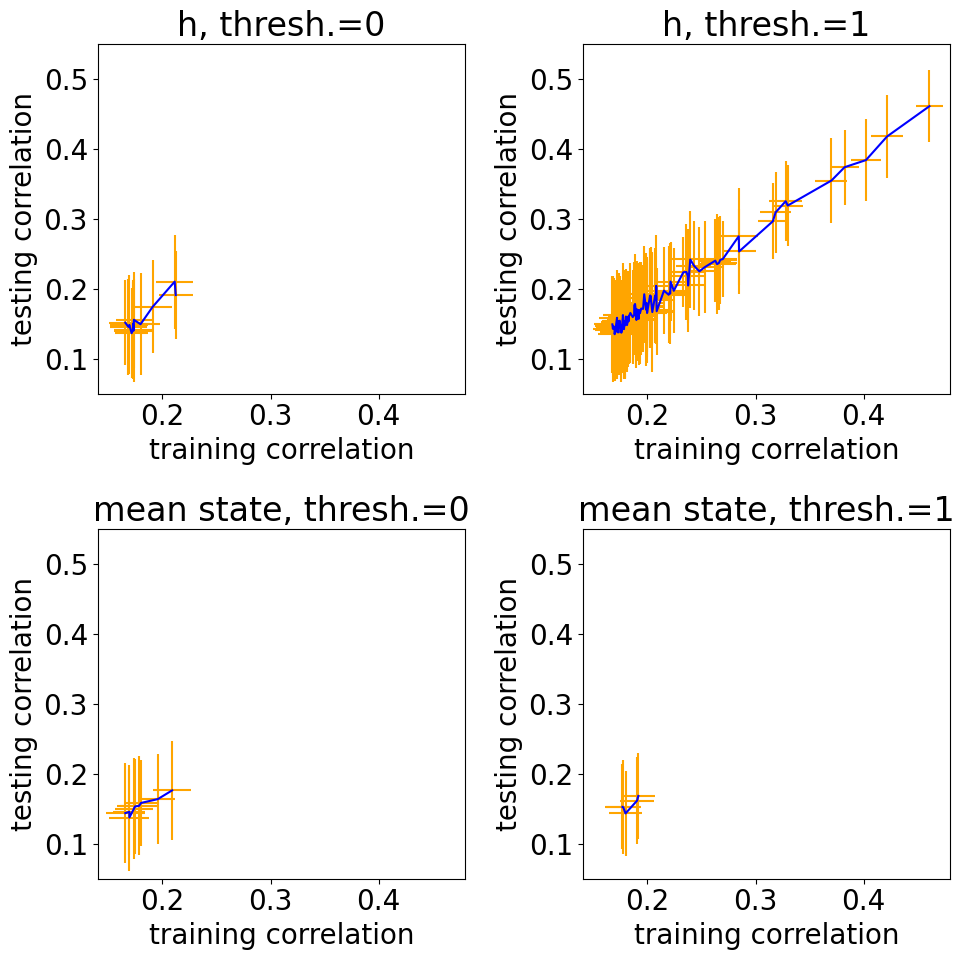

In [230]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in big_train_corr_list ]
corrs_orders = [ torch.sort(corrs).indices for corrs in mean_train_corrs ]
mean_train_corrs = [ corrs[indices] for corrs, indices in zip(mean_train_corrs,corrs_orders) ]
mean_test_corrs = [ corrs.mean(dim=-1)[indices] for corrs, indices in zip(big_test_corr_list,corrs_orders) ]
std_train_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(big_train_corr_list,corrs_orders) ]
std_test_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(big_test_corr_list,corrs_orders) ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 10) )
err_xlim = [0.14, 0.48]
err_xticks = np.arange(0.2, 0.45, 0.1)
err_ylim = [0.05, 0.55]
err_yticks = np.arange(0.1, 0.51, 0.1)
for train_mean, test_mean, train_std, test_std, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,std_train_corrs,std_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    ax.errorbar( x=depytorch(train_mean), y=depytorch(test_mean), xerr=depytorch(train_std), yerr=depytorch(test_std), color='blue', ecolor='orange' )
    ax.set_xlim(err_xlim)
    ax.set_xticks(err_xticks)
    ax.set_ylim(err_ylim)
    ax.set_yticks(err_yticks)
    ax.set_xlabel('training correlation')
    ax.set_ylabel('testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

In [231]:
p_value_J_sc_0 = torch.load( os.path.join(file_dir, f'p_value_corr_SC_J_{model_0_str}_perms_20000.pt'), weights_only=False )
num_edges = p_value_J_sc_0.numel()
alpha = 0.05/num_edges
is_sig_J_sc_0 = p_value_J_sc_0 < alpha
print(f'J, threshold 0 significant correlations {torch.count_nonzero(is_sig_J_sc_0)}')
p_value_J_sc_1 = torch.load( os.path.join(file_dir, f'p_value_corr_SC_J_{model_1_str}_perms_20000.pt'), weights_only=False )
is_sig_J_sc_1 = p_value_J_sc_1 < alpha
print(f'J, threshold 1 significant correlations {torch.count_nonzero(is_sig_J_sc_1)}')
p_value_fc_sc_0 = torch.load( os.path.join(file_dir, f'p_value_corr_SC_FC_{model_0_str}_perms_20000.pt'), weights_only=False )
is_sig_fc_sc_0 = p_value_fc_sc_0 < alpha
print(f'FC, threshold 0 significant correlations {torch.count_nonzero(is_sig_fc_sc_0)}')
p_value_fc_sc_1 = torch.load( os.path.join(file_dir, f'p_value_corr_SC_FC_{model_1_str}_perms_20000.pt'), weights_only=False )
is_sig_fc_sc_1 = p_value_fc_sc_1 < alpha
print(f'FC, threshold 1 significant correlations {torch.count_nonzero(is_sig_fc_sc_1)}')

J, threshold 0 significant correlations 602
J, threshold 1 significant correlations 495
FC, threshold 0 significant correlations 360
FC, threshold 1 significant correlations 310


In [251]:
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
min_corr = 0.1
train_corr_list = [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1]
test_corr_list = [lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1]
label_x = range( 1, len(corr_labels)+1 )
is_big_enough = [ is_sig_J_sc_0 , is_sig_J_sc_1, is_sig_fc_sc_0, is_sig_fc_sc_1 ]
print(f'num training correlations that are at least {min_corr:.3g}')
print([ torch.count_nonzero(filt).item() for filt in is_big_enough])
big_train_corr_list = [ corrs[filt] for corrs, filt in zip(train_corr_list, is_big_enough) ]
big_test_corr_list = [ corrs[filt] for corrs, filt in zip(test_corr_list, is_big_enough) ]
print('bad training correlations after filtering')
print([ torch.count_nonzero( corr_is_bad(corrs) ).item() for corrs in big_train_corr_list ])
print('bad testing correlations after filtering')
print([ torch.count_nonzero( corr_is_bad(corrs) ).item() for corrs in big_test_corr_list ])

num training correlations that are at least 0.1
[602, 495, 360, 310]
bad training correlations after filtering
[0, 0, 0, 0]
bad testing correlations after filtering
[0, 0, 0, 0]


In [252]:
all_big_corrs = big_train_corr_list + big_test_corr_list
big_corr_min = min([ torch.min(corrs).item() for corrs in all_big_corrs ])
big_corr_max = max([ torch.max(corrs).item() for corrs in all_big_corrs ])
lim_margin = 0.05
cross_val_lim = [big_corr_min - lim_margin, big_corr_max + lim_margin]
cross_val_ticks = np.arange(-0.2, 0.8, 0.2)

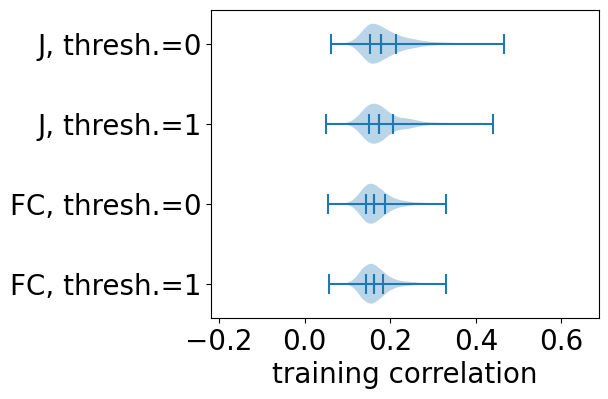

In [234]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
all_corrs = [ depytorch( corrs.flatten() ) for corrs in big_train_corr_list ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_xlim(cross_val_lim)
axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('training correlation')
plt.show()

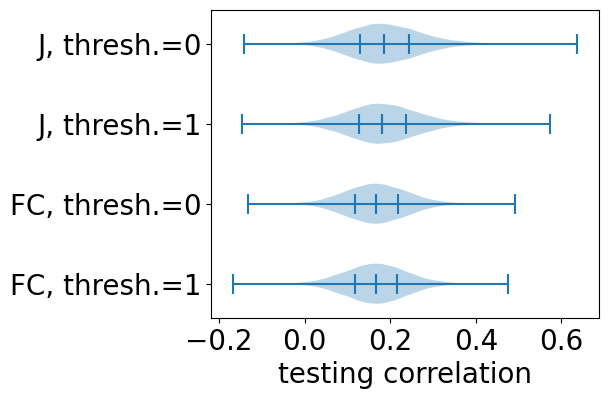

In [235]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
all_corrs = [ depytorch( corrs.flatten() ) for corrs in big_test_corr_list ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_xlim(cross_val_lim)
axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('testing correlation')
plt.show()

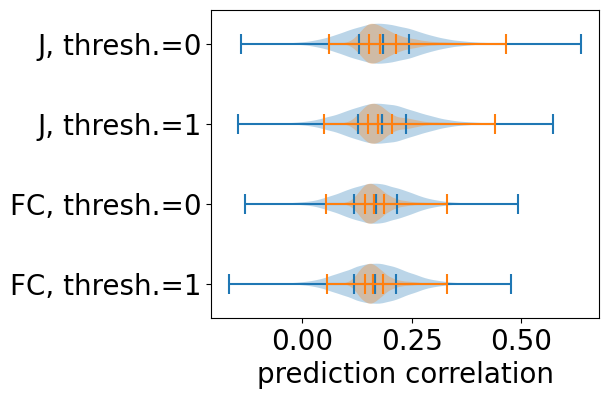

In [236]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
all_train_corrs = [ depytorch( corrs.flatten() ) for corrs in big_train_corr_list ]
all_test_corrs = [ depytorch( corrs.flatten() ) for corrs in big_test_corr_list ]
axs.violinplot(  list( reversed(all_test_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.violinplot(  list( reversed(all_train_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('prediction correlation')
plt.show()

testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan
testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan
testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan
testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan


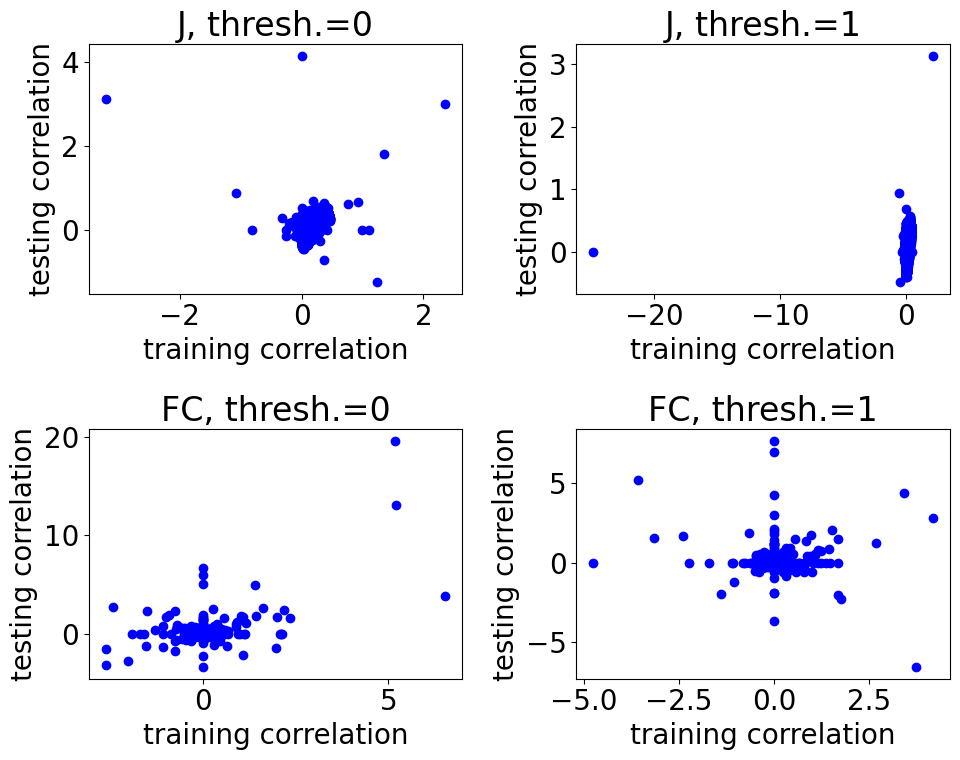

In [237]:
all_train_corrs = [ corrs.flatten() for corrs in train_corr_list ]
all_test_corrs = [ corrs.flatten() for corrs in test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(all_train_corrs,all_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

testing correlation=0.493training correlation+0.0946, R^2=0.0961, corr.=0.31
testing correlation=0.403training correlation+0.109, R^2=0.0583, corr.=0.241
testing correlation=-0.0169training correlation+0.171, R^2=6.91e-05, corr.=-0.00831
testing correlation=-0.182training correlation+0.197, R^2=0.00728, corr.=-0.0853


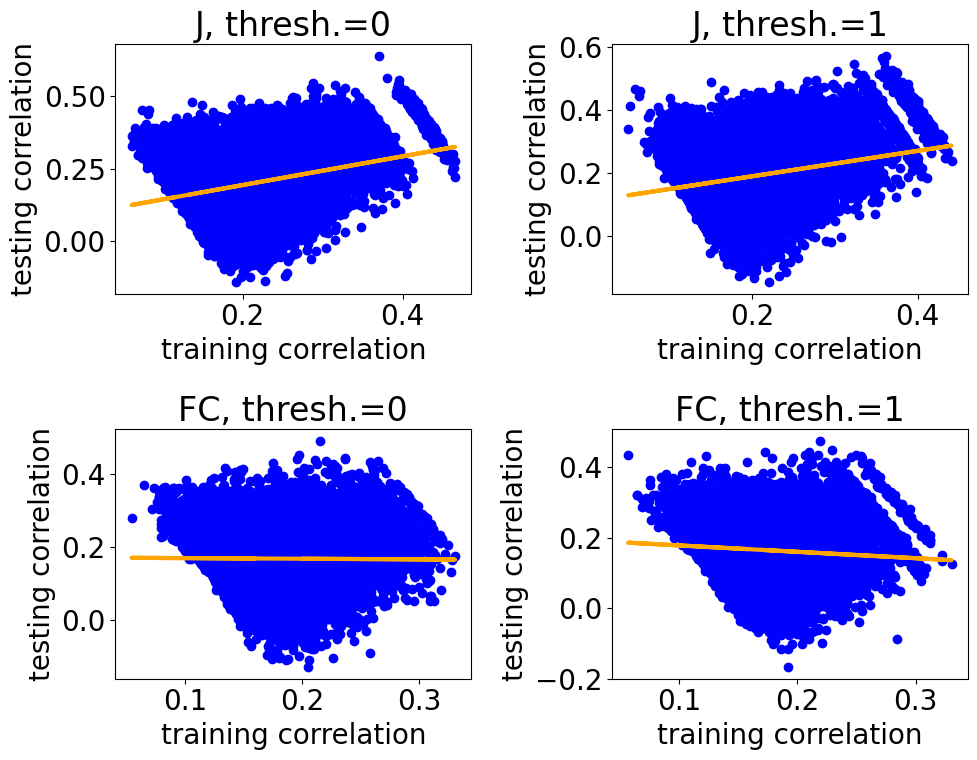

In [238]:
all_train_corrs = [ corrs.flatten() for corrs in big_train_corr_list ]
all_test_corrs = [ corrs.flatten() for corrs in big_test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(all_train_corrs,all_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan
testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan
testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan
testing correlation=nantraining correlation+nan, R^2=nan, corr.=nan


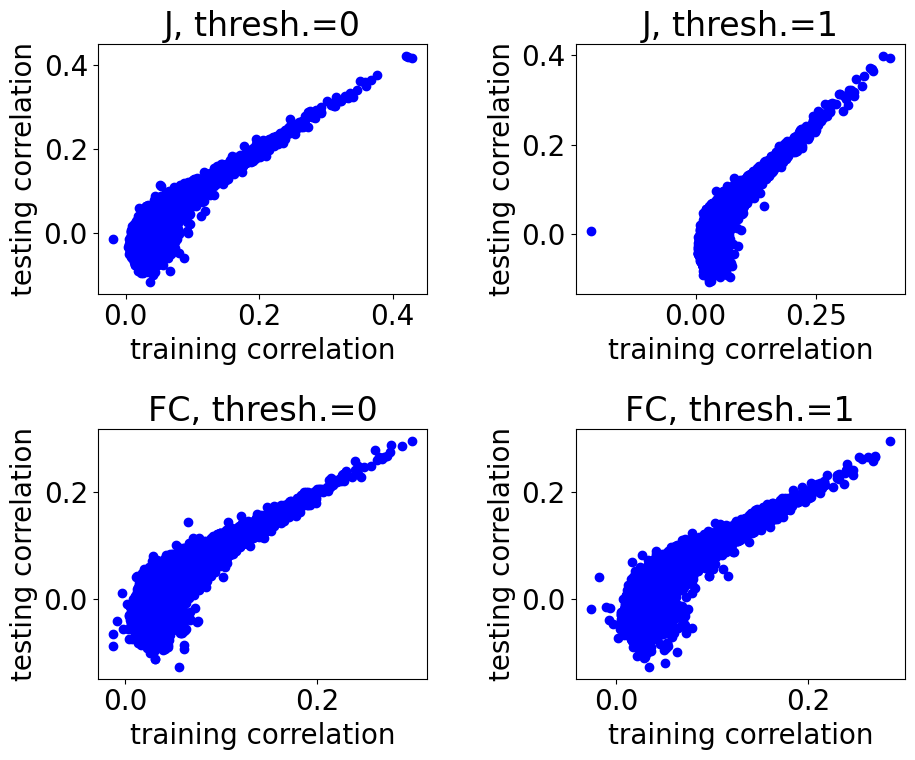

In [239]:
mean_train_corrs = [ corrs.nanmean(dim=-1) for corrs in train_corr_list ]
mean_test_corrs = [ corrs.nanmean(dim=-1) for corrs in test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

testing correlation=0.994training correlation+-0.0003, R^2=0.973, corr.=0.985
testing correlation=0.989training correlation+0.00103, R^2=0.958, corr.=0.977
testing correlation=0.996training correlation+-6.87e-05, R^2=0.941, corr.=0.967
testing correlation=0.972training correlation+0.00504, R^2=0.914, corr.=0.953


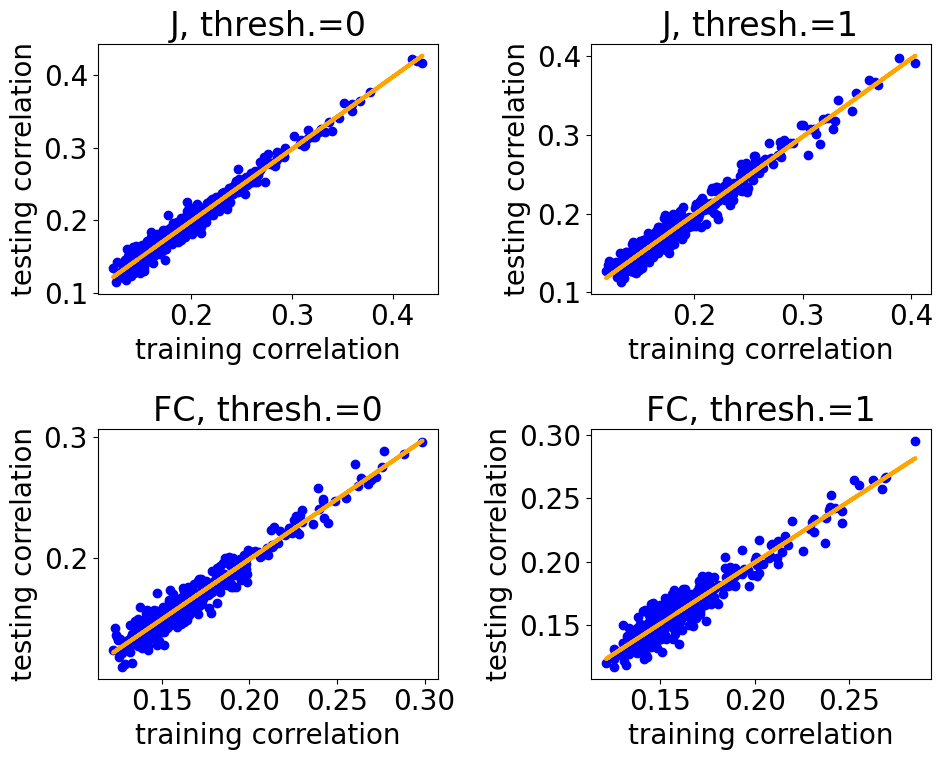

In [240]:
mean_train_corrs = [ corrs.nanmean(dim=-1) for corrs in big_train_corr_list ]
mean_test_corrs = [ corrs.nanmean(dim=-1) for corrs in big_test_corr_list ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 8) )
for train_corr, test_corr, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    make_scatter_plot_with_regression_line(ax, feature=train_corr, param=test_corr, feature_name='training correlation', param_name='testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

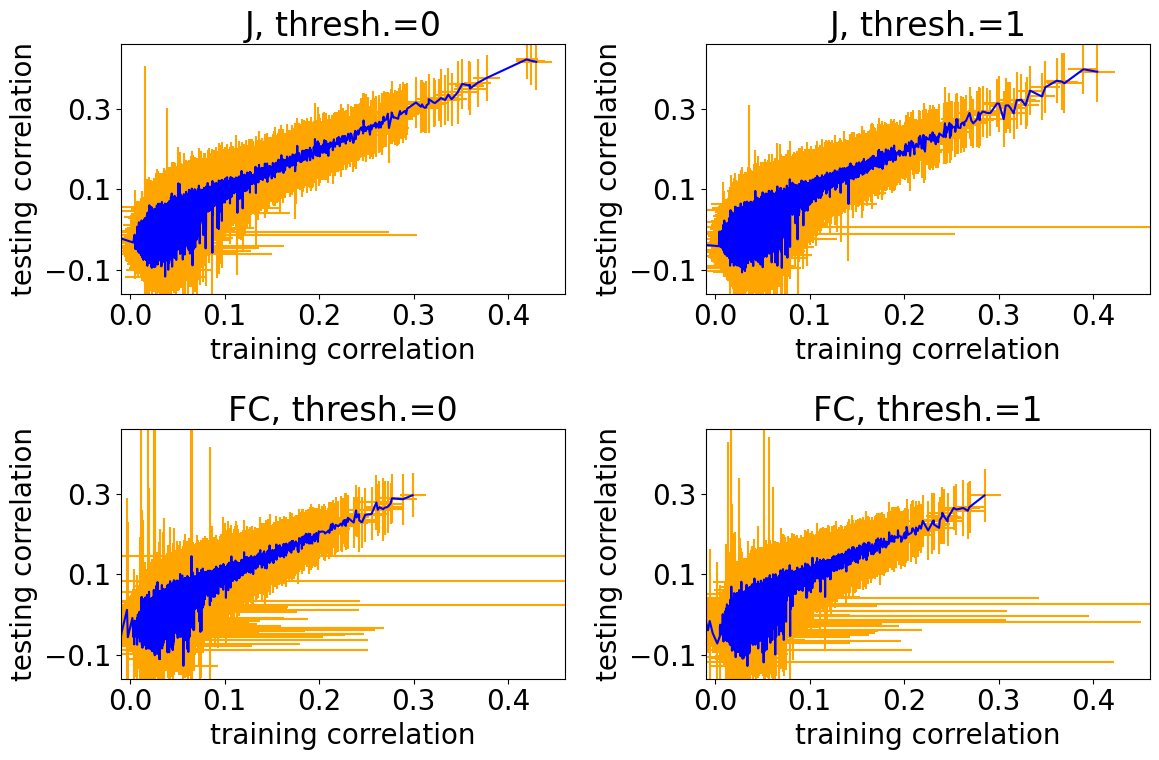

In [250]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in train_corr_list ]
corrs_orders = [ torch.sort(corrs).indices for corrs in mean_train_corrs ]
mean_train_corrs = [ corrs[indices] for corrs, indices in zip(mean_train_corrs,corrs_orders) ]
mean_test_corrs = [ corrs.mean(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
std_train_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(train_corr_list,corrs_orders) ]
std_test_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(12, 8) )
err_xlim = [-0.01, 0.46]
err_xticks = np.arange(0.0, 0.45, 0.1)
err_ylim = [-0.16, 0.46]
err_yticks = np.arange(-0.1, 0.45, 0.2)
for train_mean, test_mean, train_std, test_std, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,std_train_corrs,std_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    ax.errorbar( x=depytorch(train_mean), y=depytorch(test_mean), xerr=depytorch(train_std), yerr=depytorch(test_std), color='blue', ecolor='orange' )
    ax.set_xlim(err_xlim)
    ax.set_xticks(err_xticks)
    ax.set_ylim(err_ylim)
    ax.set_yticks(err_yticks)
    ax.set_xlabel('training correlation')
    ax.set_ylabel('testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

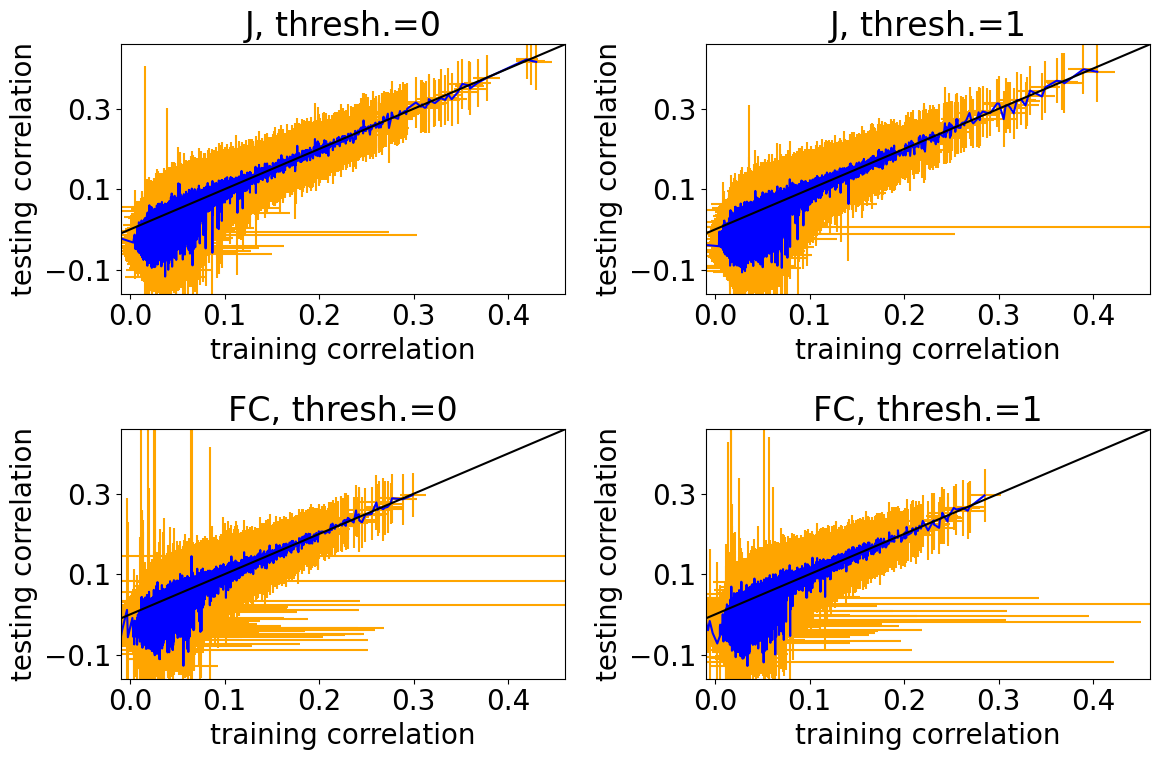

In [256]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in train_corr_list ]
corrs_orders = [ torch.sort(corrs).indices for corrs in mean_train_corrs ]
mean_train_corrs = [ corrs[indices] for corrs, indices in zip(mean_train_corrs,corrs_orders) ]
mean_test_corrs = [ corrs.mean(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
std_train_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(train_corr_list,corrs_orders) ]
std_test_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(test_corr_list,corrs_orders) ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(12, 8) )
err_xlim = [-0.01, 0.46]
err_xticks = np.arange(0.0, 0.45, 0.1)
err_ylim = [-0.16, 0.46]
err_yticks = np.arange(-0.1, 0.45, 0.2)
identity_line_endpoints = [-0.1, 0.5]
for train_mean, test_mean, train_std, test_std, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,std_train_corrs,std_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    ax.errorbar( x=depytorch(train_mean), y=depytorch(test_mean), xerr=depytorch(train_std), yerr=depytorch(test_std), color='blue', ecolor='orange' )
    ax.plot(identity_line_endpoints, identity_line_endpoints, color='black', linestyle='solid', zorder=10)
    ax.set_xlim(err_xlim)
    ax.set_xticks(err_xticks)
    ax.set_ylim(err_ylim)
    ax.set_yticks(err_yticks)
    ax.set_xlabel('training correlation')
    ax.set_ylabel('testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

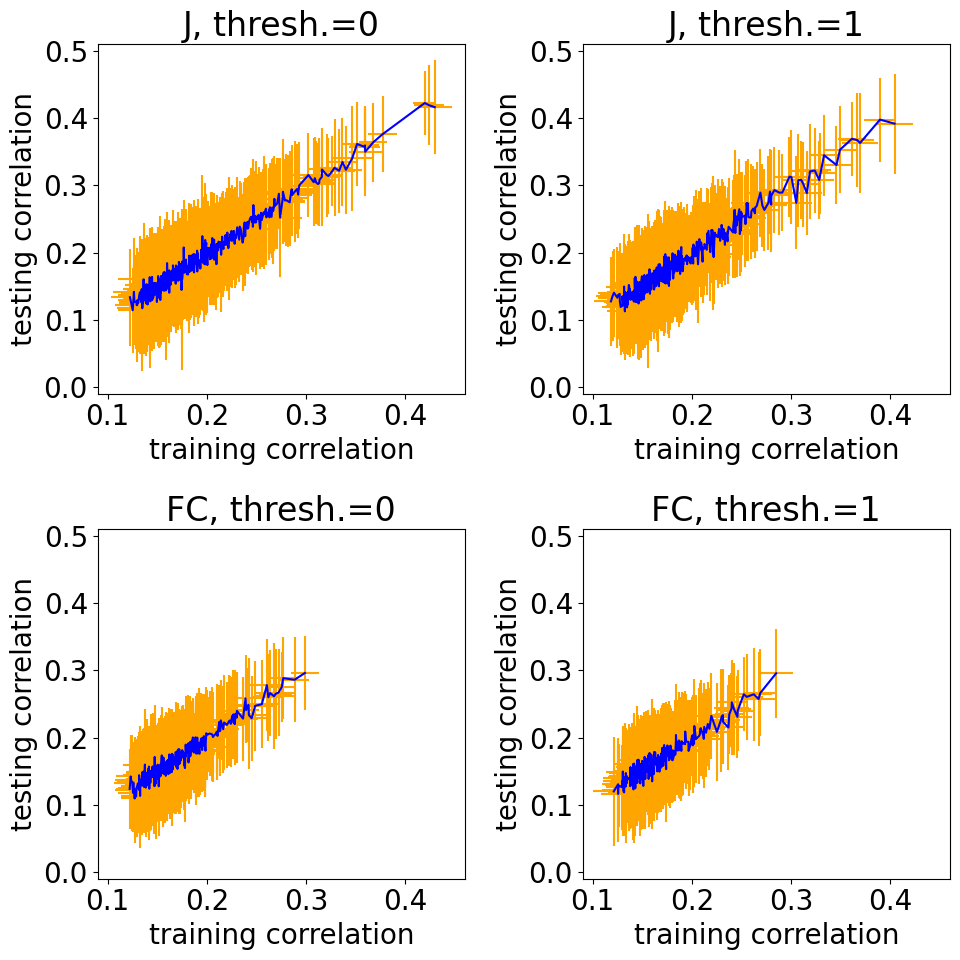

In [242]:
mean_train_corrs = [ corrs.mean(dim=-1) for corrs in big_train_corr_list ]
corrs_orders = [ torch.sort(corrs).indices for corrs in mean_train_corrs ]
mean_train_corrs = [ corrs[indices] for corrs, indices in zip(mean_train_corrs,corrs_orders) ]
mean_test_corrs = [ corrs.mean(dim=-1)[indices] for corrs, indices in zip(big_test_corr_list,corrs_orders) ]
std_train_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(big_train_corr_list,corrs_orders) ]
std_test_corrs = [ corrs.std(dim=-1)[indices] for corrs, indices in zip(big_test_corr_list,corrs_orders) ]
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(10, 10) )
err_xlim = [0.09, 0.46]
err_xticks = np.arange(0.1, 0.41, 0.1)
err_ylim = [-0.01, 0.51]
err_yticks = np.arange(0.0, 0.51, 0.1)
for train_mean, test_mean, train_std, test_std, plot_row, plot_col, corr_name in zip(mean_train_corrs,mean_test_corrs,std_train_corrs,std_test_corrs,[0,0,1,1],[0,1,0,1],corr_labels):
    ax = axs[plot_row,plot_col]
    ax.errorbar( x=depytorch(train_mean), y=depytorch(test_mean), xerr=depytorch(train_std), yerr=depytorch(test_std), color='blue', ecolor='orange' )
    ax.set_xlim(err_xlim)
    ax.set_xticks(err_xticks)
    ax.set_ylim(err_ylim)
    ax.set_yticks(err_yticks)
    ax.set_xlabel('training correlation')
    ax.set_ylabel('testing correlation')
    ax.set_title(corr_name)
plt.tight_layout()

In [329]:
def do_one_wilcoxon_for_each(train:torch.Tensor, test:torch.Tensor):
    num_tests, num_samples = train.size()
    p_values = torch.zeros( (num_tests,), dtype=train.dtype, device=train.device )
    for test_index in range(num_tests):
        _, p_values[test_index] = stats.wilcoxon( depytorch(train[test_index,:]), depytorch(test[test_index,:]), alternative='greater', nan_policy='omit' )
    return p_values

In [332]:
# train_corr_list = [lstsq_corr_train_all_h_0, lstsq_corr_train_all_h_1, lstsq_corr_train_all_mean_state_0, lstsq_corr_train_all_mean_state_1]
# test_corr_list = [lstsq_corr_test_all_h_0, lstsq_corr_test_all_h_1, lstsq_corr_test_all_mean_state_0, lstsq_corr_test_all_mean_state_1]
p_values_train_test_all_h_1 = do_one_wilcoxon_for_each(train=lstsq_corr_train_all_h_1, test=lstsq_corr_test_all_h_1)
num_nodes = p_values_train_test_all_h_1.size(dim=0)
alpha = 0.05/num_nodes
print( p_values_train_test_all_h_1.size(), p_values_train_test_all_h_1.min().item(), p_values_train_test_all_h_1.median().item(), p_values_train_test_all_h_1.max().item(), torch.count_nonzero(p_values_train_test_all_h_1 < alpha).item() )

torch.Size([360]) 2.0696869563077054e-18 6.580739136552438e-05 0.6600497961044312 201


In [339]:
lstsq_corr_train_all_h_1_sig = lstsq_corr_train_all_h_1[is_sig_h_all_1,:]
lstsq_corr_test_all_h_1_sig = lstsq_corr_test_all_h_1[is_sig_h_all_1,:]
p_values_train_test_all_h_1_sig = do_one_wilcoxon_for_each(train=lstsq_corr_train_all_h_1_sig, test=lstsq_corr_test_all_h_1_sig)
num_nodes = p_values_train_test_all_h_1_sig.size(dim=0)
alpha = 0.05/num_nodes
print( p_values_train_test_all_h_1_sig.size(), p_values_train_test_all_h_1_sig.min().item(), p_values_train_test_all_h_1_sig.median().item(), p_values_train_test_all_h_1_sig.max().item(), torch.count_nonzero(p_values_train_test_all_h_1_sig < alpha).item() )

torch.Size([96]) 8.948234153649537e-07 0.0034407677594572306 0.6600497961044312 23


In [334]:
print(   stats.wilcoxon(  depytorch( lstsq_corr_train_all_h_1.flatten() ), depytorch( lstsq_corr_test_all_h_1.flatten() ), alternative='greater', nan_policy='omit'  )   )

WilcoxonResult(statistic=np.float64(477307382.0), pvalue=np.float64(0.0))


In [340]:
print(   stats.wilcoxon(  depytorch( lstsq_corr_train_all_h_1_sig.flatten() ), depytorch( lstsq_corr_test_all_h_1_sig.flatten() ), alternative='greater', nan_policy='omit'  )   )

WilcoxonResult(statistic=np.float64(29810408.0), pvalue=np.float64(2.0646758665810407e-137))


In [342]:
lstsq_corr_train_test_diff_all_h_1 = lstsq_corr_train_all_h_1 - lstsq_corr_test_all_h_1
print( lstsq_corr_train_test_diff_all_h_1.size(), lstsq_corr_train_test_diff_all_h_1.min().item(), lstsq_corr_train_test_diff_all_h_1.median().item(), lstsq_corr_train_test_diff_all_h_1.max().item(), torch.count_nonzero(lstsq_corr_train_test_diff_all_h_1 > 0.0).item()/lstsq_corr_train_test_diff_all_h_1.numel() )

torch.Size([360, 100]) -0.2656545341014862 0.03788715600967407 0.40494680404663086 0.6728055555555555


In [345]:
lstsq_corr_train_test_diff_all_h_1_sig = lstsq_corr_train_all_h_1_sig - lstsq_corr_test_all_h_1_sig
print( lstsq_corr_train_all_h_1_sig.min().item(), lstsq_corr_train_all_h_1_sig.median().item(), lstsq_corr_train_all_h_1_sig.max().item() )
print( lstsq_corr_test_all_h_1_sig.min().item(), lstsq_corr_test_all_h_1_sig.median().item(), lstsq_corr_test_all_h_1_sig.max().item() )
print( lstsq_corr_train_test_diff_all_h_1_sig.size(), lstsq_corr_train_test_diff_all_h_1_sig.min().item(), lstsq_corr_train_test_diff_all_h_1_sig.median().item(), lstsq_corr_train_test_diff_all_h_1_sig.max().item(), torch.count_nonzero(lstsq_corr_train_test_diff_all_h_1_sig > 0.0).item()/lstsq_corr_train_test_diff_all_h_1_sig.numel() )

0.12244848161935806 0.19817546010017395 0.48943835496902466
-0.11206906288862228 0.18570439517498016 0.5733429789543152
torch.Size([96, 100]) -0.24601055681705475 0.021847814321517944 0.35147807002067566 0.6036458333333333


In [347]:
train_corr_list = [lstsq_corr_train_all_h_0, lstsq_corr_train_all_h_1, lstsq_corr_train_all_mean_state_0, lstsq_corr_train_all_mean_state_1]
test_corr_list = [lstsq_corr_test_all_h_0, lstsq_corr_test_all_h_1, lstsq_corr_test_all_mean_state_0, lstsq_corr_test_all_mean_state_1]
is_sig_list = [is_sig_h_all_0, is_sig_h_all_1, is_sig_mean_state_all_0, is_sig_mean_state_all_1]
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
for train, test, is_sig, label in zip(train_corr_list, test_corr_list, is_sig_list, corr_labels):
    train_sig = train[is_sig]
    test_sig = test[is_sig]
    sig_corr_diff = train_sig - test_sig
    print(f'{label} train - test min {sig_corr_diff.min().item():.3g}, median {sig_corr_diff.median().item():.3g}, max {sig_corr_diff.max().item():.3g}, median train {train_sig.median().item():.3g}, median test {test_sig.median().item():.3g}')

h, thresh.=0 train - test min -0.239, median 0.0211, max 0.279, median train 0.177, median test 0.159
h, thresh.=1 train - test min -0.246, median 0.0218, max 0.351, median train 0.198, median test 0.186
mean state, thresh.=0 train - test min -0.259, median 0.0233, max 0.323, median train 0.179, median test 0.154
mean state, thresh.=1 train - test min -0.19, median 0.0277, max 0.261, median train 0.183, median test 0.154


In [348]:
train_corr_list = [lstsq_corr_train_sc_J_0, lstsq_corr_train_sc_J_1, lstsq_corr_train_sc_fc_0, lstsq_corr_train_sc_fc_1]
test_corr_list = [lstsq_corr_test_sc_J_0, lstsq_corr_test_sc_J_1, lstsq_corr_test_sc_fc_0, lstsq_corr_test_sc_fc_1]
is_sig_list = [is_sig_J_sc_0, is_sig_J_sc_1, is_sig_fc_sc_0, is_sig_fc_sc_1]
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
for train, test, is_sig, label in zip(train_corr_list, test_corr_list, is_sig_list, corr_labels):
    train_sig = train[is_sig]
    test_sig = test[is_sig]
    sig_corr_diff = train_sig - test_sig
    print(f'{label} train - test min {sig_corr_diff.min().item():.3g}, median {sig_corr_diff.median().item():.3g}, max {sig_corr_diff.max().item():.3g}, median train {train_sig.median().item():.3g}, median test {test_sig.median().item():.3g}')

J, thresh.=0 train - test min -0.376, median 0.000795, max 0.373, median train 0.178, median test 0.184
J, thresh.=1 train - test min -0.407, median 0.000285, max 0.368, median train 0.174, median test 0.181
FC, thresh.=0 train - test min -0.304, median -0.000134, max 0.35, median train 0.163, median test 0.167
FC, thresh.=1 train - test min -0.38, median -0.00102, max 0.372, median train 0.161, median test 0.167


In [391]:
lstsq_corr_train_sc_J_1_sig = lstsq_corr_train_sc_J_1[is_sig_J_sc_1,:]
lstsq_corr_test_sc_J_1_sig = lstsq_corr_test_sc_J_1[is_sig_J_sc_1,:]
print(   stats.wilcoxon(  depytorch( lstsq_corr_train_sc_J_1_sig.flatten() ), depytorch( lstsq_corr_test_sc_J_1_sig.flatten() ), alternative='two-sided', nan_policy='omit'  )   )

WilcoxonResult(statistic=np.float64(607032644.0), pvalue=np.float64(0.08128911838704324))


In [350]:
p_values_train_test_sc_J_1_sig = do_one_wilcoxon_for_each(train=lstsq_corr_train_sc_J_1_sig, test=lstsq_corr_test_sc_J_1_sig)
num_edges = p_values_train_test_sc_J_1_sig.size(dim=0)
alpha = 0.05/num_edges
print( p_values_train_test_sc_J_1_sig.size(), p_values_train_test_sc_J_1_sig.min().item(), p_values_train_test_sc_J_1_sig.median().item(), p_values_train_test_sc_J_1_sig.max().item(), torch.count_nonzero(p_values_train_test_sc_J_1_sig < alpha).item() )

torch.Size([495]) 0.000525095674674958 0.4958849847316742 0.9948919415473938 0


In [396]:
h_all_corr = torch.load( f=os.path.join(file_dir, 'lstsq_corr_group_all_h_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( h_all_corr.size() )

torch.Size([31, 1])


In [403]:
print( h_all_corr[10,0] )

tensor(0.3778, device='cuda:0')


In [417]:
mean_state_all_corr = torch.load( f=os.path.join(file_dir, 'lstsq_corr_group_all_mean_state_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( mean_state_all_corr.size() )

torch.Size([31, 1])


In [418]:
print( mean_state_all_corr[0,0] )

tensor(0.3897, device='cuda:0')


In [399]:
J_sc_corr = torch.load( f=os.path.join(file_dir, 'corr_group_SC_J_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( J_sc_corr.size() )

torch.Size([31, 1])


In [405]:
print( J_sc_corr[10,0] )

tensor(0.5133, device='cuda:0')


In [407]:
h_all_corr_individual_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_all_to_h_model_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).squeeze(dim=-1)
print( h_all_corr_individual_1.size() )

torch.Size([837])


In [408]:
h_all_corr_individual_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_all_to_h_model_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=False ).squeeze(dim=-1)
print( h_all_corr_individual_0.size() )

torch.Size([837])


In [409]:
mean_state_all_corr_individual_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_all_to_mean_state_model_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).squeeze(dim=-1)
print( mean_state_all_corr_individual_1.size() )

torch.Size([837])


In [410]:
mean_state_all_corr_individual_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_all_to_mean_state_model_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=False ).squeeze(dim=-1)
print( mean_state_all_corr_individual_0.size() )

torch.Size([837])


In [411]:
J_SC_corr_individual_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_SC_to_J_model_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).squeeze(dim=-1)
print( J_SC_corr_individual_1.size() )

torch.Size([837])


In [412]:
J_SC_corr_individual_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_SC_to_J_model_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=False ).squeeze(dim=-1)
print( J_SC_corr_individual_0.size() )

torch.Size([837])


In [413]:
FC_SC_corr_individual_1 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_SC_to_FC_model_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False ).squeeze(dim=-1)
print( FC_SC_corr_individual_1.size() )

torch.Size([837])


In [414]:
FC_SC_corr_individual_0 = torch.load( f=os.path.join(file_dir, 'lstsq_corr_from_SC_to_FC_model_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=False ).squeeze(dim=-1)
print( FC_SC_corr_individual_0.size() )

torch.Size([837])


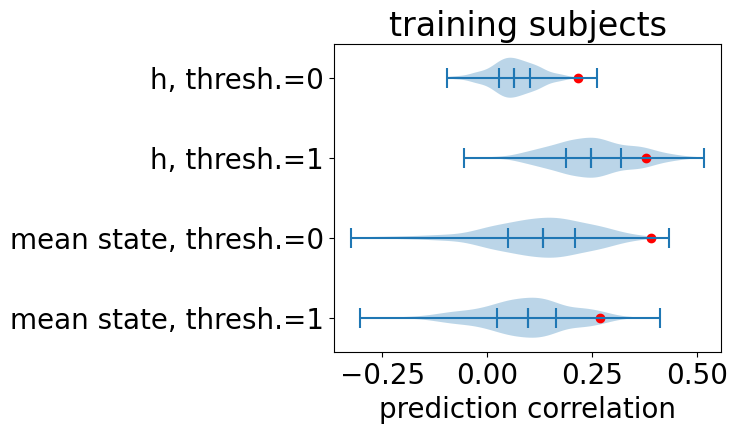

In [423]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
group_corrs = list( reversed([0.21509887278079987, 0.3776920735836029, 0.3906034231185913, 0.26756468415260315]) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
all_corrs = [ depytorch(corrs[:training_subject_end]) for corrs in [h_all_corr_individual_0, h_all_corr_individual_1, mean_state_all_corr_individual_0, mean_state_all_corr_individual_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.scatter( group_corrs, label_x, color='red' )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('prediction correlation')
axs.set_title('training subjects')
plt.show()

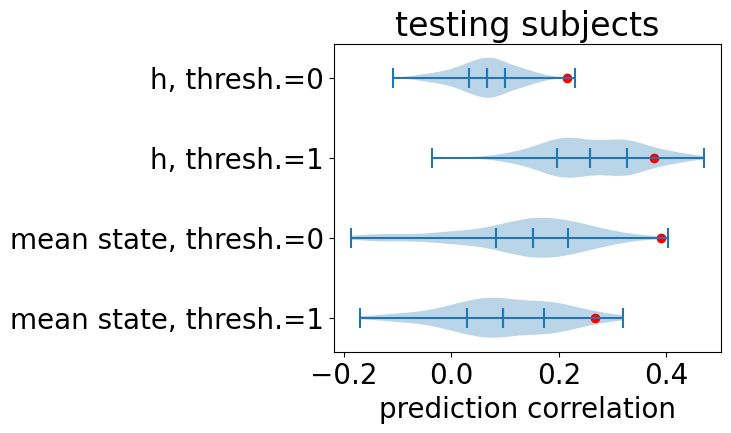

In [426]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
group_corrs = list( reversed([0.21509887278079987, 0.3776920735836029, 0.3906034231185913, 0.26756468415260315]) )
corr_labels = ['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1']
all_corrs = [ depytorch(corrs[training_subject_end:]) for corrs in [h_all_corr_individual_0, h_all_corr_individual_1, mean_state_all_corr_individual_0, mean_state_all_corr_individual_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.scatter( group_corrs, label_x, color='red' )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('prediction correlation')
axs.set_title('testing subjects')
plt.show()

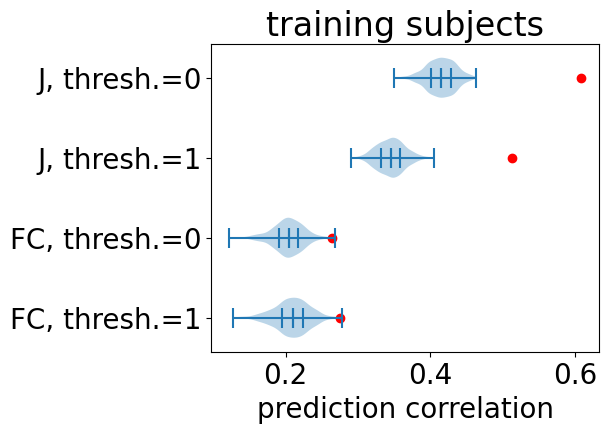

In [428]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
group_corrs = list( reversed([0.6087037920951843, 0.5133374333381653, 0.2639080584049225, 0.2754320204257965]) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
all_corrs = [ depytorch(corrs[:training_subject_end]) for corrs in [J_SC_corr_individual_0, J_SC_corr_individual_1, FC_SC_corr_individual_0, FC_SC_corr_individual_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.scatter( group_corrs, label_x, color='red' )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('prediction correlation')
axs.set_title('training subjects')
plt.show()

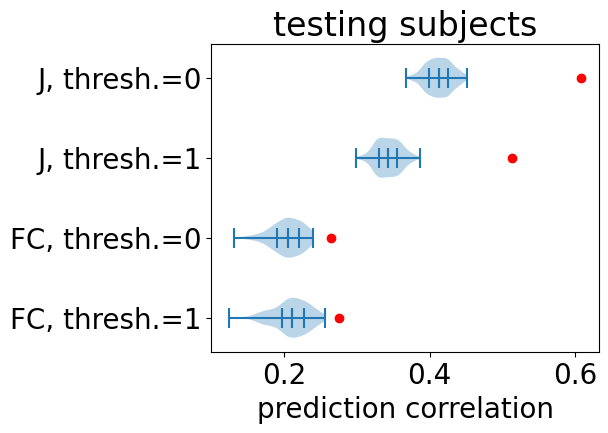

In [429]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
group_corrs = list( reversed([0.6087037920951843, 0.5133374333381653, 0.2639080584049225, 0.2754320204257965]) )
corr_labels = ['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1']
all_corrs = [ depytorch(corrs[training_subject_end:]) for corrs in [J_SC_corr_individual_0, J_SC_corr_individual_1, FC_SC_corr_individual_0, FC_SC_corr_individual_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.scatter( group_corrs, label_x, color='red' )
# axs.set_xlim(cross_val_lim)
# axs.set_xticks(cross_val_ticks)
axs.set_yticks(label_x)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('prediction correlation')
axs.set_title('testing subjects')
plt.show()

In [431]:
print('train > test?')
for name, corrs in zip(['J, thresh.=0', 'J, thresh.=1', 'FC, thresh.=0', 'FC, thresh.=1'],[J_SC_corr_individual_0, J_SC_corr_individual_1, FC_SC_corr_individual_0, FC_SC_corr_individual_1]):
    print( name, stats.mannwhitneyu( depytorch(corrs[:training_subject_end]), depytorch(corrs[training_subject_end:]), alternative='greater' )  )

train > test?
J, thresh.=0 MannwhitneyuResult(statistic=np.float64(59687.0), pvalue=np.float64(0.09036657405853188))
J, thresh.=1 MannwhitneyuResult(statistic=np.float64(60213.0), pvalue=np.float64(0.06342096166431396))
FC, thresh.=0 MannwhitneyuResult(statistic=np.float64(54288.0), pvalue=np.float64(0.7233965499529202))
FC, thresh.=1 MannwhitneyuResult(statistic=np.float64(53663.0), pvalue=np.float64(0.7929077072378508))


In [432]:
print('train > test?')
for name, corrs in zip(['h, thresh.=0', 'h, thresh.=1', 'mean state, thresh.=0', 'mean state, thresh.=1'],[h_all_corr_individual_0, h_all_corr_individual_1, mean_state_all_corr_individual_0, mean_state_all_corr_individual_1]):
    print( name, stats.mannwhitneyu( depytorch(corrs[:training_subject_end]), depytorch(corrs[training_subject_end:]), alternative='greater' )  )

train > test?
h, thresh.=0 MannwhitneyuResult(statistic=np.float64(55475.0), pvalue=np.float64(0.5668337543911278))
h, thresh.=1 MannwhitneyuResult(statistic=np.float64(52116.0), pvalue=np.float64(0.9146538330536673))
mean state, thresh.=0 MannwhitneyuResult(statistic=np.float64(51902.0), pvalue=np.float64(0.9259870886074456))
mean state, thresh.=1 MannwhitneyuResult(statistic=np.float64(54283.0), pvalue=np.float64(0.7239947853158315))


In [433]:
print( 'h thresh.=1 > mean state thresh.=0? (training)', stats.wilcoxon( depytorch(h_all_corr_individual_1[:training_subject_end]), depytorch(mean_state_all_corr_individual_0[:training_subject_end]), alternative='greater' )  )

h thresh.=1 > mean state thresh.=0? (training) WilcoxonResult(statistic=np.float64(203904.0), pvalue=np.float64(8.833045436898629e-75))


In [434]:
print( 'h thresh.=1 > mean state thresh.=0? (testing)', stats.wilcoxon( depytorch(h_all_corr_individual_1[training_subject_end:]), depytorch(mean_state_all_corr_individual_0[training_subject_end:]), alternative='greater' )  )

h thresh.=1 > mean state thresh.=0? (testing) WilcoxonResult(statistic=np.float64(12745.0), pvalue=np.float64(2.6433439087814338e-20))


In [435]:
print( 'h thresh.=1 > mean state thresh.=1? (training)', stats.wilcoxon( depytorch(h_all_corr_individual_1[:training_subject_end]), depytorch(mean_state_all_corr_individual_1[:training_subject_end]), alternative='greater' )  )

h thresh.=1 > mean state thresh.=1? (training) WilcoxonResult(statistic=np.float64(214761.0), pvalue=np.float64(5.028179937900225e-93))


In [436]:
print( 'h thresh.=1 > mean state thresh.=1? (testing)', stats.wilcoxon( depytorch(h_all_corr_individual_1[training_subject_end:]), depytorch(mean_state_all_corr_individual_1[training_subject_end:]), alternative='greater' )  )

h thresh.=1 > mean state thresh.=1? (testing) WilcoxonResult(statistic=np.float64(13497.0), pvalue=np.float64(1.8911160711489391e-25))


In [437]:
print( 'h thresh.=1 > h thresh.=0? (training)', stats.wilcoxon( depytorch(h_all_corr_individual_1[:training_subject_end]), depytorch(h_all_corr_individual_0[:training_subject_end]), alternative='greater' )  )

h thresh.=1 > h thresh.=0? (training) WilcoxonResult(statistic=np.float64(223650.0), pvalue=np.float64(1.7790769852484554e-109))


In [438]:
print( 'h thresh.=1 > h thresh.=0? (testing)', stats.wilcoxon( depytorch(h_all_corr_individual_1[training_subject_end:]), depytorch(h_all_corr_individual_0[training_subject_end:]), alternative='greater' )  )

h thresh.=1 > h thresh.=0? (testing) WilcoxonResult(statistic=np.float64(13924.0), pvalue=np.float64(1.1979757251485104e-28))


In [439]:
fc_corr = torch.load( os.path.join(file_dir, 'fc_corr_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_param_updates_33000_test_length_120000.pt'), weights_only=False )
print( fc_corr.size() )

torch.Size([101, 31])


In [441]:
fc_corr_std, fc_corr_mean = torch.std_mean( fc_corr, dim=0 )
print( 'threshold', threshold.tolist() )
print( 'FC corr. mean', fc_corr_mean.tolist() )
print( 'FC corr. SD', fc_corr_std.tolist() )

threshold [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.9000000357627869, 1.0, 1.100000023841858, 1.2000000476837158, 1.3000000715255737, 1.399999976158142, 1.5, 1.600000023841858, 1.6999999284744263, 1.7999999523162842, 1.899999976158142, 2.0, 2.0999999046325684, 2.200000047683716, 2.299999952316284, 2.4000000953674316, 2.5, 2.5999999046325684, 2.700000047683716, 2.799999952316284, 2.9000000953674316, 3.0]
FC corr. mean [0.9965534806251526, 0.9966906905174255, 0.9964523315429688, 0.9968249201774597, 0.9961842894554138, 0.9960218667984009, 0.9948760867118835, 0.9932947158813477, 0.9903595447540283, 0.9853684902191162, 0.9739295244216919, 0.9551355242729187, 0.9163405299186707, 0.8853029012680054, 0.8067528605461121, 0.7099735140800476, 0.5489045977592468, 0.4809894859790802, 0.42800936102867126, 0.3358997702598572, 0.28260692954063416, 0.19941359758377075, 0.12559236586093903, 0.